In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_roi_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 1040)
(3944610, 8)
validation
(464344, 1040)
(464344, 8)
test
(574820, 1040)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1040)]            0         


 dense (Dense)               (None, 1024)              1065984   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1756040 (6.70 MB)


Trainable params: 1756040 (6.70 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 12:21 - loss: 2.4492 - STD: 0.0949 - MAE: 0.2202

  3/395 [..............................] - ETA: 11s - loss: 2.2473 - STD: 0.0655 - MAE: 0.2184  

  5/395 [..............................] - ETA: 11s - loss: 2.1734 - STD: 0.0591 - MAE: 0.2173

  7/395 [..............................] - ETA: 11s - loss: 2.1488 - STD: 0.0564 - MAE: 0.2170

  9/395 [..............................] - ETA: 11s - loss: 2.1388 - STD: 0.0550 - MAE: 0.2169

 11/395 [..............................] - ETA: 11s - loss: 2.1277 - STD: 0.0537 - MAE: 0.2168

 13/395 [..............................] - ETA: 11s - loss: 2.1177 - STD: 0.0524 - MAE: 0.2167

 15/395 [>.............................] - ETA: 11s - loss: 2.1090 - STD: 0.0506 - MAE: 0.2166

 17/395 [>.............................] - ETA: 11s - loss: 2.1020 - STD: 0.0485 - MAE: 0.2166

 19/395 [>.............................] - ETA: 11s - loss: 2.0972 - STD: 0.0465 - MAE: 0.2166

 21/395 [>.............................] - ETA: 11s - loss: 2.0932 - STD: 0.0449 - MAE: 0.2167

 23/395 [>.............................] - ETA: 11s - loss: 2.0898 - STD: 0.0437 - MAE: 0.2167

 25/395 [>.............................] - ETA: 11s - loss: 2.0868 - STD: 0.0429 - MAE: 0.2167

 27/395 [=>............................] - ETA: 11s - loss: 2.0836 - STD: 0.0422 - MAE: 0.2167

 29/395 [=>............................] - ETA: 11s - loss: 2.0805 - STD: 0.0415 - MAE: 0.2166

 31/395 [=>............................] - ETA: 11s - loss: 2.0777 - STD: 0.0411 - MAE: 0.2166

 33/395 [=>............................] - ETA: 11s - loss: 2.0753 - STD: 0.0408 - MAE: 0.2165

 35/395 [=>............................] - ETA: 11s - loss: 2.0724 - STD: 0.0405 - MAE: 0.2165

 37/395 [=>............................] - ETA: 11s - loss: 2.0695 - STD: 0.0402 - MAE: 0.2164

 39/395 [=>............................] - ETA: 10s - loss: 2.0662 - STD: 0.0399 - MAE: 0.2163

 41/395 [==>...........................] - ETA: 10s - loss: 2.0625 - STD: 0.0398 - MAE: 0.2162

 43/395 [==>...........................] - ETA: 10s - loss: 2.0584 - STD: 0.0398 - MAE: 0.2161

 45/395 [==>...........................] - ETA: 10s - loss: 2.0540 - STD: 0.0400 - MAE: 0.2160

 47/395 [==>...........................] - ETA: 10s - loss: 2.0491 - STD: 0.0404 - MAE: 0.2158

 49/395 [==>...........................] - ETA: 10s - loss: 2.0437 - STD: 0.0409 - MAE: 0.2156

 51/395 [==>...........................] - ETA: 10s - loss: 2.0380 - STD: 0.0415 - MAE: 0.2153

 53/395 [===>..........................] - ETA: 10s - loss: 2.0320 - STD: 0.0423 - MAE: 0.2151

 55/395 [===>..........................] - ETA: 10s - loss: 2.0258 - STD: 0.0432 - MAE: 0.2148

 57/395 [===>..........................] - ETA: 10s - loss: 2.0193 - STD: 0.0442 - MAE: 0.2144

 59/395 [===>..........................] - ETA: 10s - loss: 2.0126 - STD: 0.0452 - MAE: 0.2141

 61/395 [===>..........................] - ETA: 10s - loss: 2.0059 - STD: 0.0463 - MAE: 0.2138

 63/395 [===>..........................] - ETA: 10s - loss: 1.9990 - STD: 0.0473 - MAE: 0.2134

 65/395 [===>..........................] - ETA: 10s - loss: 1.9917 - STD: 0.0484 - MAE: 0.2131

 67/395 [====>.........................] - ETA: 10s - loss: 1.9840 - STD: 0.0495 - MAE: 0.2127

 69/395 [====>.........................] - ETA: 10s - loss: 1.9758 - STD: 0.0506 - MAE: 0.2123

 71/395 [====>.........................] - ETA: 10s - loss: 1.9668 - STD: 0.0518 - MAE: 0.2118

 73/395 [====>.........................] - ETA: 9s - loss: 1.9575 - STD: 0.0530 - MAE: 0.2113 

 75/395 [====>.........................] - ETA: 9s - loss: 1.9478 - STD: 0.0543 - MAE: 0.2108

 77/395 [====>.........................] - ETA: 9s - loss: 1.9378 - STD: 0.0556 - MAE: 0.2103

 79/395 [=====>........................] - ETA: 9s - loss: 1.9276 - STD: 0.0570 - MAE: 0.2098

 81/395 [=====>........................] - ETA: 9s - loss: 1.9174 - STD: 0.0584 - MAE: 0.2092

 83/395 [=====>........................] - ETA: 9s - loss: 1.9072 - STD: 0.0599 - MAE: 0.2086

 85/395 [=====>........................] - ETA: 9s - loss: 1.8973 - STD: 0.0614 - MAE: 0.2080

 87/395 [=====>........................] - ETA: 9s - loss: 1.8875 - STD: 0.0628 - MAE: 0.2074

 89/395 [=====>........................] - ETA: 9s - loss: 1.8777 - STD: 0.0643 - MAE: 0.2069

 91/395 [=====>........................] - ETA: 9s - loss: 1.8683 - STD: 0.0658 - MAE: 0.2063

 93/395 [======>.......................] - ETA: 9s - loss: 1.8590 - STD: 0.0673 - MAE: 0.2057

 95/395 [======>.......................] - ETA: 9s - loss: 1.8499 - STD: 0.0687 - MAE: 0.2051

 97/395 [======>.......................] - ETA: 9s - loss: 1.8411 - STD: 0.0701 - MAE: 0.2046

 99/395 [======>.......................] - ETA: 9s - loss: 1.8324 - STD: 0.0714 - MAE: 0.2040

101/395 [======>.......................] - ETA: 9s - loss: 1.8239 - STD: 0.0727 - MAE: 0.2035

103/395 [======>.......................] - ETA: 9s - loss: 1.8156 - STD: 0.0740 - MAE: 0.2030

105/395 [======>.......................] - ETA: 8s - loss: 1.8073 - STD: 0.0753 - MAE: 0.2025

107/395 [=======>......................] - ETA: 8s - loss: 1.7991 - STD: 0.0765 - MAE: 0.2019

109/395 [=======>......................] - ETA: 8s - loss: 1.7913 - STD: 0.0777 - MAE: 0.2014

111/395 [=======>......................] - ETA: 8s - loss: 1.7840 - STD: 0.0789 - MAE: 0.2009

113/395 [=======>......................] - ETA: 8s - loss: 1.7766 - STD: 0.0800 - MAE: 0.2004

115/395 [=======>......................] - ETA: 8s - loss: 1.7693 - STD: 0.0812 - MAE: 0.2000

117/395 [=======>......................] - ETA: 8s - loss: 1.7623 - STD: 0.0823 - MAE: 0.1995

119/395 [========>.....................] - ETA: 8s - loss: 1.7552 - STD: 0.0833 - MAE: 0.1990

121/395 [========>.....................] - ETA: 8s - loss: 1.7484 - STD: 0.0844 - MAE: 0.1986

123/395 [========>.....................] - ETA: 8s - loss: 1.7418 - STD: 0.0854 - MAE: 0.1981

125/395 [========>.....................] - ETA: 8s - loss: 1.7354 - STD: 0.0864 - MAE: 0.1977

127/395 [========>.....................] - ETA: 8s - loss: 1.7290 - STD: 0.0874 - MAE: 0.1973

129/395 [========>.....................] - ETA: 8s - loss: 1.7227 - STD: 0.0884 - MAE: 0.1968

131/395 [========>.....................] - ETA: 8s - loss: 1.7167 - STD: 0.0893 - MAE: 0.1964

133/395 [=========>....................] - ETA: 8s - loss: 1.7108 - STD: 0.0903 - MAE: 0.1960

135/395 [=========>....................] - ETA: 8s - loss: 1.7048 - STD: 0.0912 - MAE: 0.1956

137/395 [=========>....................] - ETA: 8s - loss: 1.6992 - STD: 0.0921 - MAE: 0.1952

139/395 [=========>....................] - ETA: 7s - loss: 1.6937 - STD: 0.0930 - MAE: 0.1948

141/395 [=========>....................] - ETA: 7s - loss: 1.6881 - STD: 0.0939 - MAE: 0.1944

143/395 [=========>....................] - ETA: 7s - loss: 1.6829 - STD: 0.0947 - MAE: 0.1940

145/395 [==========>...................] - ETA: 7s - loss: 1.6777 - STD: 0.0956 - MAE: 0.1937

147/395 [==========>...................] - ETA: 7s - loss: 1.6724 - STD: 0.0964 - MAE: 0.1933

149/395 [==========>...................] - ETA: 7s - loss: 1.6673 - STD: 0.0972 - MAE: 0.1929

151/395 [==========>...................] - ETA: 7s - loss: 1.6623 - STD: 0.0980 - MAE: 0.1925

152/395 [==========>...................] - ETA: 9s - loss: 1.6612 - STD: 0.0984 - MAE: 0.1924

154/395 [==========>...................] - ETA: 8s - loss: 1.6564 - STD: 0.0992 - MAE: 0.1920

156/395 [==========>...................] - ETA: 8s - loss: 1.6516 - STD: 0.1000 - MAE: 0.1917

158/395 [===========>..................] - ETA: 8s - loss: 1.6469 - STD: 0.1007 - MAE: 0.1913

160/395 [===========>..................] - ETA: 8s - loss: 1.6421 - STD: 0.1015 - MAE: 0.1910

162/395 [===========>..................] - ETA: 8s - loss: 1.6375 - STD: 0.1022 - MAE: 0.1906

164/395 [===========>..................] - ETA: 8s - loss: 1.6330 - STD: 0.1030 - MAE: 0.1903

166/395 [===========>..................] - ETA: 8s - loss: 1.6287 - STD: 0.1037 - MAE: 0.1900

168/395 [===========>..................] - ETA: 8s - loss: 1.6242 - STD: 0.1044 - MAE: 0.1896

170/395 [===========>..................] - ETA: 8s - loss: 1.6199 - STD: 0.1051 - MAE: 0.1893

172/395 [============>.................] - ETA: 8s - loss: 1.6156 - STD: 0.1058 - MAE: 0.1890

174/395 [============>.................] - ETA: 8s - loss: 1.6116 - STD: 0.1065 - MAE: 0.1887

176/395 [============>.................] - ETA: 7s - loss: 1.6077 - STD: 0.1071 - MAE: 0.1884

178/395 [============>.................] - ETA: 7s - loss: 1.6037 - STD: 0.1078 - MAE: 0.1881

180/395 [============>.................] - ETA: 7s - loss: 1.5997 - STD: 0.1084 - MAE: 0.1878

182/395 [============>.................] - ETA: 7s - loss: 1.5958 - STD: 0.1090 - MAE: 0.1875

184/395 [============>.................] - ETA: 7s - loss: 1.5921 - STD: 0.1097 - MAE: 0.1872

186/395 [=============>................] - ETA: 7s - loss: 1.5882 - STD: 0.1103 - MAE: 0.1869

188/395 [=============>................] - ETA: 7s - loss: 1.5845 - STD: 0.1109 - MAE: 0.1866

190/395 [=============>................] - ETA: 7s - loss: 1.5807 - STD: 0.1115 - MAE: 0.1863

192/395 [=============>................] - ETA: 7s - loss: 1.5770 - STD: 0.1121 - MAE: 0.1860

194/395 [=============>................] - ETA: 7s - loss: 1.5734 - STD: 0.1127 - MAE: 0.1857

196/395 [=============>................] - ETA: 7s - loss: 1.5698 - STD: 0.1132 - MAE: 0.1855

198/395 [==============>...............] - ETA: 7s - loss: 1.5663 - STD: 0.1138 - MAE: 0.1852

200/395 [==============>...............] - ETA: 6s - loss: 1.5628 - STD: 0.1144 - MAE: 0.1849

202/395 [==============>...............] - ETA: 6s - loss: 1.5594 - STD: 0.1149 - MAE: 0.1846

204/395 [==============>...............] - ETA: 6s - loss: 1.5559 - STD: 0.1155 - MAE: 0.1844

206/395 [==============>...............] - ETA: 6s - loss: 1.5526 - STD: 0.1160 - MAE: 0.1841

208/395 [==============>...............] - ETA: 6s - loss: 1.5493 - STD: 0.1165 - MAE: 0.1838

210/395 [==============>...............] - ETA: 6s - loss: 1.5460 - STD: 0.1171 - MAE: 0.1836

212/395 [===============>..............] - ETA: 6s - loss: 1.5428 - STD: 0.1176 - MAE: 0.1833

214/395 [===============>..............] - ETA: 6s - loss: 1.5395 - STD: 0.1181 - MAE: 0.1830

216/395 [===============>..............] - ETA: 6s - loss: 1.5362 - STD: 0.1186 - MAE: 0.1828

218/395 [===============>..............] - ETA: 6s - loss: 1.5330 - STD: 0.1192 - MAE: 0.1825

220/395 [===============>..............] - ETA: 6s - loss: 1.5299 - STD: 0.1197 - MAE: 0.1823

222/395 [===============>..............] - ETA: 6s - loss: 1.5268 - STD: 0.1202 - MAE: 0.1820

224/395 [================>.............] - ETA: 5s - loss: 1.5239 - STD: 0.1207 - MAE: 0.1818

226/395 [================>.............] - ETA: 5s - loss: 1.5207 - STD: 0.1211 - MAE: 0.1815

228/395 [================>.............] - ETA: 5s - loss: 1.5177 - STD: 0.1216 - MAE: 0.1813

230/395 [================>.............] - ETA: 5s - loss: 1.5148 - STD: 0.1221 - MAE: 0.1810

232/395 [================>.............] - ETA: 5s - loss: 1.5118 - STD: 0.1226 - MAE: 0.1808

234/395 [================>.............] - ETA: 5s - loss: 1.5089 - STD: 0.1231 - MAE: 0.1806

236/395 [================>.............] - ETA: 5s - loss: 1.5062 - STD: 0.1235 - MAE: 0.1803

238/395 [=================>............] - ETA: 5s - loss: 1.5033 - STD: 0.1240 - MAE: 0.1801

240/395 [=================>............] - ETA: 5s - loss: 1.5006 - STD: 0.1245 - MAE: 0.1798

242/395 [=================>............] - ETA: 5s - loss: 1.4979 - STD: 0.1249 - MAE: 0.1796

244/395 [=================>............] - ETA: 5s - loss: 1.4952 - STD: 0.1253 - MAE: 0.1794

246/395 [=================>............] - ETA: 5s - loss: 1.4925 - STD: 0.1258 - MAE: 0.1792

248/395 [=================>............] - ETA: 5s - loss: 1.4900 - STD: 0.1262 - MAE: 0.1789

250/395 [=================>............] - ETA: 5s - loss: 1.4877 - STD: 0.1267 - MAE: 0.1787

252/395 [==================>...........] - ETA: 4s - loss: 1.4851 - STD: 0.1271 - MAE: 0.1785

254/395 [==================>...........] - ETA: 4s - loss: 1.4826 - STD: 0.1275 - MAE: 0.1783

256/395 [==================>...........] - ETA: 4s - loss: 1.4801 - STD: 0.1279 - MAE: 0.1781

258/395 [==================>...........] - ETA: 4s - loss: 1.4776 - STD: 0.1283 - MAE: 0.1779

260/395 [==================>...........] - ETA: 4s - loss: 1.4753 - STD: 0.1287 - MAE: 0.1777

262/395 [==================>...........] - ETA: 4s - loss: 1.4728 - STD: 0.1291 - MAE: 0.1775

264/395 [===================>..........] - ETA: 4s - loss: 1.4705 - STD: 0.1295 - MAE: 0.1773

266/395 [===================>..........] - ETA: 4s - loss: 1.4681 - STD: 0.1299 - MAE: 0.1771

268/395 [===================>..........] - ETA: 4s - loss: 1.4656 - STD: 0.1303 - MAE: 0.1769

270/395 [===================>..........] - ETA: 4s - loss: 1.4631 - STD: 0.1307 - MAE: 0.1766

272/395 [===================>..........] - ETA: 4s - loss: 1.4607 - STD: 0.1311 - MAE: 0.1764

274/395 [===================>..........] - ETA: 4s - loss: 1.4585 - STD: 0.1315 - MAE: 0.1762

276/395 [===================>..........] - ETA: 4s - loss: 1.4562 - STD: 0.1319 - MAE: 0.1760

278/395 [====================>.........] - ETA: 4s - loss: 1.4539 - STD: 0.1322 - MAE: 0.1758

280/395 [====================>.........] - ETA: 3s - loss: 1.4516 - STD: 0.1326 - MAE: 0.1756

282/395 [====================>.........] - ETA: 3s - loss: 1.4495 - STD: 0.1330 - MAE: 0.1755

284/395 [====================>.........] - ETA: 3s - loss: 1.4472 - STD: 0.1333 - MAE: 0.1753

286/395 [====================>.........] - ETA: 3s - loss: 1.4450 - STD: 0.1337 - MAE: 0.1751

288/395 [====================>.........] - ETA: 3s - loss: 1.4428 - STD: 0.1341 - MAE: 0.1749

290/395 [=====================>........] - ETA: 3s - loss: 1.4407 - STD: 0.1344 - MAE: 0.1747

292/395 [=====================>........] - ETA: 3s - loss: 1.4386 - STD: 0.1348 - MAE: 0.1745

294/395 [=====================>........] - ETA: 3s - loss: 1.4365 - STD: 0.1351 - MAE: 0.1743

296/395 [=====================>........] - ETA: 3s - loss: 1.4344 - STD: 0.1355 - MAE: 0.1741

298/395 [=====================>........] - ETA: 3s - loss: 1.4323 - STD: 0.1358 - MAE: 0.1739

300/395 [=====================>........] - ETA: 3s - loss: 1.4303 - STD: 0.1361 - MAE: 0.1738

302/395 [=====================>........] - ETA: 3s - loss: 1.4282 - STD: 0.1365 - MAE: 0.1736

304/395 [======================>.......] - ETA: 3s - loss: 1.4262 - STD: 0.1368 - MAE: 0.1734

306/395 [======================>.......] - ETA: 3s - loss: 1.4242 - STD: 0.1371 - MAE: 0.1732

308/395 [======================>.......] - ETA: 2s - loss: 1.4222 - STD: 0.1375 - MAE: 0.1730

310/395 [======================>.......] - ETA: 2s - loss: 1.4202 - STD: 0.1378 - MAE: 0.1729

312/395 [======================>.......] - ETA: 2s - loss: 1.4182 - STD: 0.1381 - MAE: 0.1727

314/395 [======================>.......] - ETA: 2s - loss: 1.4162 - STD: 0.1384 - MAE: 0.1725

316/395 [=======================>......] - ETA: 2s - loss: 1.4143 - STD: 0.1387 - MAE: 0.1723

318/395 [=======================>......] - ETA: 2s - loss: 1.4124 - STD: 0.1391 - MAE: 0.1722

320/395 [=======================>......] - ETA: 2s - loss: 1.4105 - STD: 0.1394 - MAE: 0.1720

322/395 [=======================>......] - ETA: 2s - loss: 1.4086 - STD: 0.1397 - MAE: 0.1718

324/395 [=======================>......] - ETA: 2s - loss: 1.4068 - STD: 0.1400 - MAE: 0.1717

326/395 [=======================>......] - ETA: 2s - loss: 1.4049 - STD: 0.1403 - MAE: 0.1715

328/395 [=======================>......] - ETA: 2s - loss: 1.4030 - STD: 0.1406 - MAE: 0.1713

330/395 [========================>.....] - ETA: 2s - loss: 1.4012 - STD: 0.1409 - MAE: 0.1712

332/395 [========================>.....] - ETA: 2s - loss: 1.3993 - STD: 0.1412 - MAE: 0.1710

334/395 [========================>.....] - ETA: 2s - loss: 1.3975 - STD: 0.1415 - MAE: 0.1708

336/395 [========================>.....] - ETA: 1s - loss: 1.3957 - STD: 0.1418 - MAE: 0.1707

338/395 [========================>.....] - ETA: 1s - loss: 1.3939 - STD: 0.1420 - MAE: 0.1705

340/395 [========================>.....] - ETA: 1s - loss: 1.3922 - STD: 0.1423 - MAE: 0.1704

342/395 [========================>.....] - ETA: 1s - loss: 1.3905 - STD: 0.1426 - MAE: 0.1702

344/395 [=========================>....] - ETA: 1s - loss: 1.3888 - STD: 0.1429 - MAE: 0.1701

346/395 [=========================>....] - ETA: 1s - loss: 1.3872 - STD: 0.1432 - MAE: 0.1699

348/395 [=========================>....] - ETA: 1s - loss: 1.3855 - STD: 0.1435 - MAE: 0.1697

350/395 [=========================>....] - ETA: 1s - loss: 1.3839 - STD: 0.1438 - MAE: 0.1696

352/395 [=========================>....] - ETA: 1s - loss: 1.3822 - STD: 0.1440 - MAE: 0.1694

354/395 [=========================>....] - ETA: 1s - loss: 1.3805 - STD: 0.1443 - MAE: 0.1693

356/395 [==========================>...] - ETA: 1s - loss: 1.3788 - STD: 0.1446 - MAE: 0.1691

358/395 [==========================>...] - ETA: 1s - loss: 1.3772 - STD: 0.1448 - MAE: 0.1690

360/395 [==========================>...] - ETA: 1s - loss: 1.3756 - STD: 0.1451 - MAE: 0.1688

362/395 [==========================>...] - ETA: 1s - loss: 1.3740 - STD: 0.1454 - MAE: 0.1687

364/395 [==========================>...] - ETA: 1s - loss: 1.3724 - STD: 0.1456 - MAE: 0.1685

366/395 [==========================>...] - ETA: 0s - loss: 1.3708 - STD: 0.1459 - MAE: 0.1684

368/395 [==========================>...] - ETA: 0s - loss: 1.3692 - STD: 0.1461 - MAE: 0.1683

370/395 [===========================>..] - ETA: 0s - loss: 1.3676 - STD: 0.1464 - MAE: 0.1681

372/395 [===========================>..] - ETA: 0s - loss: 1.3662 - STD: 0.1466 - MAE: 0.1680

374/395 [===========================>..] - ETA: 0s - loss: 1.3646 - STD: 0.1469 - MAE: 0.1678

376/395 [===========================>..] - ETA: 0s - loss: 1.3631 - STD: 0.1472 - MAE: 0.1677

378/395 [===========================>..] - ETA: 0s - loss: 1.3616 - STD: 0.1474 - MAE: 0.1675

380/395 [===========================>..] - ETA: 0s - loss: 1.3602 - STD: 0.1477 - MAE: 0.1674

382/395 [============================>.] - ETA: 0s - loss: 1.3587 - STD: 0.1479 - MAE: 0.1673

384/395 [============================>.] - ETA: 0s - loss: 1.3572 - STD: 0.1481 - MAE: 0.1671

386/395 [============================>.] - ETA: 0s - loss: 1.3557 - STD: 0.1484 - MAE: 0.1670

388/395 [============================>.] - ETA: 0s - loss: 1.3542 - STD: 0.1486 - MAE: 0.1669

390/395 [============================>.] - ETA: 0s - loss: 1.3527 - STD: 0.1489 - MAE: 0.1667

392/395 [============================>.] - ETA: 0s - loss: 1.3514 - STD: 0.1491 - MAE: 0.1666

394/395 [============================>.] - ETA: 0s - loss: 1.3500 - STD: 0.1493 - MAE: 0.1665

395/395 [==============================] - 17s 38ms/step - loss: 1.3493 - STD: 0.1494 - MAE: 0.1664 - val_loss: 1.1970 - val_STD: 0.1967 - val_MAE: 0.1440


Epoch 2/10000


  1/395 [..............................] - ETA: 30s - loss: 1.0743 - STD: 0.1933 - MAE: 0.1413

  3/395 [..............................] - ETA: 12s - loss: 1.0715 - STD: 0.1943 - MAE: 0.1408

  5/395 [..............................] - ETA: 12s - loss: 1.0672 - STD: 0.1953 - MAE: 0.1402

  7/395 [..............................] - ETA: 12s - loss: 1.0683 - STD: 0.1957 - MAE: 0.1401

  9/395 [..............................] - ETA: 12s - loss: 1.0686 - STD: 0.1957 - MAE: 0.1401

 11/395 [..............................] - ETA: 12s - loss: 1.0657 - STD: 0.1958 - MAE: 0.1399

 13/395 [..............................] - ETA: 12s - loss: 1.0637 - STD: 0.1959 - MAE: 0.1398

 15/395 [>.............................] - ETA: 12s - loss: 1.0609 - STD: 0.1960 - MAE: 0.1395

 17/395 [>.............................] - ETA: 12s - loss: 1.0589 - STD: 0.1961 - MAE: 0.1394

 19/395 [>.............................] - ETA: 12s - loss: 1.0576 - STD: 0.1962 - MAE: 0.1393

 21/395 [>.............................] - ETA: 12s - loss: 1.0581 - STD: 0.1963 - MAE: 0.1393

 23/395 [>.............................] - ETA: 11s - loss: 1.0579 - STD: 0.1965 - MAE: 0.1392

 25/395 [>.............................] - ETA: 11s - loss: 1.0568 - STD: 0.1966 - MAE: 0.1391

 27/395 [=>............................] - ETA: 11s - loss: 1.0573 - STD: 0.1966 - MAE: 0.1391

 29/395 [=>............................] - ETA: 11s - loss: 1.0583 - STD: 0.1967 - MAE: 0.1392

 31/395 [=>............................] - ETA: 11s - loss: 1.0583 - STD: 0.1968 - MAE: 0.1391

 33/395 [=>............................] - ETA: 11s - loss: 1.0588 - STD: 0.1968 - MAE: 0.1391

 35/395 [=>............................] - ETA: 11s - loss: 1.0587 - STD: 0.1968 - MAE: 0.1391

 37/395 [=>............................] - ETA: 11s - loss: 1.0590 - STD: 0.1968 - MAE: 0.1391

 39/395 [=>............................] - ETA: 11s - loss: 1.0595 - STD: 0.1968 - MAE: 0.1392

 41/395 [==>...........................] - ETA: 11s - loss: 1.0593 - STD: 0.1969 - MAE: 0.1391

 43/395 [==>...........................] - ETA: 11s - loss: 1.0592 - STD: 0.1969 - MAE: 0.1391

 45/395 [==>...........................] - ETA: 10s - loss: 1.0581 - STD: 0.1971 - MAE: 0.1390

 47/395 [==>...........................] - ETA: 10s - loss: 1.0578 - STD: 0.1972 - MAE: 0.1389

 49/395 [==>...........................] - ETA: 10s - loss: 1.0574 - STD: 0.1972 - MAE: 0.1389

 51/395 [==>...........................] - ETA: 10s - loss: 1.0577 - STD: 0.1972 - MAE: 0.1389

 53/395 [===>..........................] - ETA: 10s - loss: 1.0567 - STD: 0.1973 - MAE: 0.1388

 55/395 [===>..........................] - ETA: 10s - loss: 1.0557 - STD: 0.1974 - MAE: 0.1387

 57/395 [===>..........................] - ETA: 10s - loss: 1.0549 - STD: 0.1975 - MAE: 0.1386

 59/395 [===>..........................] - ETA: 10s - loss: 1.0550 - STD: 0.1976 - MAE: 0.1386

 61/395 [===>..........................] - ETA: 10s - loss: 1.0547 - STD: 0.1977 - MAE: 0.1386

 63/395 [===>..........................] - ETA: 10s - loss: 1.0543 - STD: 0.1977 - MAE: 0.1385

 65/395 [===>..........................] - ETA: 10s - loss: 1.0536 - STD: 0.1978 - MAE: 0.1384

 67/395 [====>.........................] - ETA: 10s - loss: 1.0531 - STD: 0.1979 - MAE: 0.1384

 69/395 [====>.........................] - ETA: 10s - loss: 1.0526 - STD: 0.1980 - MAE: 0.1383

 71/395 [====>.........................] - ETA: 10s - loss: 1.0525 - STD: 0.1980 - MAE: 0.1383

 73/395 [====>.........................] - ETA: 9s - loss: 1.0522 - STD: 0.1981 - MAE: 0.1382 

 75/395 [====>.........................] - ETA: 9s - loss: 1.0519 - STD: 0.1981 - MAE: 0.1382

 77/395 [====>.........................] - ETA: 9s - loss: 1.0526 - STD: 0.1982 - MAE: 0.1382

 79/395 [=====>........................] - ETA: 9s - loss: 1.0520 - STD: 0.1982 - MAE: 0.1382

 81/395 [=====>........................] - ETA: 9s - loss: 1.0513 - STD: 0.1983 - MAE: 0.1381

 83/395 [=====>........................] - ETA: 9s - loss: 1.0505 - STD: 0.1983 - MAE: 0.1380

 85/395 [=====>........................] - ETA: 9s - loss: 1.0499 - STD: 0.1984 - MAE: 0.1380

 87/395 [=====>........................] - ETA: 9s - loss: 1.0493 - STD: 0.1984 - MAE: 0.1379

 89/395 [=====>........................] - ETA: 9s - loss: 1.0489 - STD: 0.1985 - MAE: 0.1379

 91/395 [=====>........................] - ETA: 9s - loss: 1.0486 - STD: 0.1986 - MAE: 0.1378

 93/395 [======>.......................] - ETA: 9s - loss: 1.0480 - STD: 0.1986 - MAE: 0.1378

 95/395 [======>.......................] - ETA: 9s - loss: 1.0476 - STD: 0.1986 - MAE: 0.1378

 97/395 [======>.......................] - ETA: 9s - loss: 1.0474 - STD: 0.1987 - MAE: 0.1377

 99/395 [======>.......................] - ETA: 9s - loss: 1.0471 - STD: 0.1988 - MAE: 0.1377

101/395 [======>.......................] - ETA: 9s - loss: 1.0469 - STD: 0.1989 - MAE: 0.1376

103/395 [======>.......................] - ETA: 9s - loss: 1.0463 - STD: 0.1989 - MAE: 0.1376

105/395 [======>.......................] - ETA: 8s - loss: 1.0460 - STD: 0.1990 - MAE: 0.1375

107/395 [=======>......................] - ETA: 8s - loss: 1.0454 - STD: 0.1990 - MAE: 0.1375

109/395 [=======>......................] - ETA: 8s - loss: 1.0449 - STD: 0.1991 - MAE: 0.1374

111/395 [=======>......................] - ETA: 8s - loss: 1.0444 - STD: 0.1992 - MAE: 0.1373

113/395 [=======>......................] - ETA: 8s - loss: 1.0437 - STD: 0.1992 - MAE: 0.1373

115/395 [=======>......................] - ETA: 8s - loss: 1.0431 - STD: 0.1993 - MAE: 0.1372

117/395 [=======>......................] - ETA: 8s - loss: 1.0425 - STD: 0.1994 - MAE: 0.1372

119/395 [========>.....................] - ETA: 8s - loss: 1.0419 - STD: 0.1994 - MAE: 0.1371

121/395 [========>.....................] - ETA: 8s - loss: 1.0418 - STD: 0.1995 - MAE: 0.1371

123/395 [========>.....................] - ETA: 8s - loss: 1.0417 - STD: 0.1996 - MAE: 0.1370

125/395 [========>.....................] - ETA: 8s - loss: 1.0411 - STD: 0.1996 - MAE: 0.1370

127/395 [========>.....................] - ETA: 8s - loss: 1.0405 - STD: 0.1997 - MAE: 0.1369

129/395 [========>.....................] - ETA: 8s - loss: 1.0402 - STD: 0.1998 - MAE: 0.1369

131/395 [========>.....................] - ETA: 8s - loss: 1.0397 - STD: 0.1998 - MAE: 0.1368

133/395 [=========>....................] - ETA: 8s - loss: 1.0394 - STD: 0.1999 - MAE: 0.1368

135/395 [=========>....................] - ETA: 7s - loss: 1.0389 - STD: 0.1999 - MAE: 0.1367

137/395 [=========>....................] - ETA: 7s - loss: 1.0384 - STD: 0.2000 - MAE: 0.1367

139/395 [=========>....................] - ETA: 7s - loss: 1.0383 - STD: 0.2001 - MAE: 0.1366

141/395 [=========>....................] - ETA: 7s - loss: 1.0381 - STD: 0.2001 - MAE: 0.1366

143/395 [=========>....................] - ETA: 7s - loss: 1.0381 - STD: 0.2002 - MAE: 0.1366

145/395 [==========>...................] - ETA: 7s - loss: 1.0381 - STD: 0.2002 - MAE: 0.1366

147/395 [==========>...................] - ETA: 7s - loss: 1.0377 - STD: 0.2003 - MAE: 0.1365

149/395 [==========>...................] - ETA: 7s - loss: 1.0374 - STD: 0.2003 - MAE: 0.1365

151/395 [==========>...................] - ETA: 7s - loss: 1.0372 - STD: 0.2004 - MAE: 0.1364

154/395 [==========>...................] - ETA: 7s - loss: 1.0369 - STD: 0.2005 - MAE: 0.1364

156/395 [==========>...................] - ETA: 7s - loss: 1.0365 - STD: 0.2006 - MAE: 0.1363

158/395 [===========>..................] - ETA: 7s - loss: 1.0362 - STD: 0.2006 - MAE: 0.1363

160/395 [===========>..................] - ETA: 7s - loss: 1.0358 - STD: 0.2006 - MAE: 0.1363

162/395 [===========>..................] - ETA: 7s - loss: 1.0354 - STD: 0.2007 - MAE: 0.1362

164/395 [===========>..................] - ETA: 7s - loss: 1.0353 - STD: 0.2007 - MAE: 0.1362

166/395 [===========>..................] - ETA: 7s - loss: 1.0350 - STD: 0.2008 - MAE: 0.1362

168/395 [===========>..................] - ETA: 6s - loss: 1.0346 - STD: 0.2008 - MAE: 0.1361

170/395 [===========>..................] - ETA: 6s - loss: 1.0343 - STD: 0.2009 - MAE: 0.1361

172/395 [============>.................] - ETA: 6s - loss: 1.0338 - STD: 0.2009 - MAE: 0.1360

174/395 [============>.................] - ETA: 6s - loss: 1.0335 - STD: 0.2010 - MAE: 0.1360

176/395 [============>.................] - ETA: 6s - loss: 1.0332 - STD: 0.2010 - MAE: 0.1360

178/395 [============>.................] - ETA: 6s - loss: 1.0327 - STD: 0.2011 - MAE: 0.1359

180/395 [============>.................] - ETA: 6s - loss: 1.0324 - STD: 0.2011 - MAE: 0.1359

182/395 [============>.................] - ETA: 6s - loss: 1.0321 - STD: 0.2012 - MAE: 0.1358

184/395 [============>.................] - ETA: 6s - loss: 1.0315 - STD: 0.2013 - MAE: 0.1358

186/395 [=============>................] - ETA: 6s - loss: 1.0311 - STD: 0.2013 - MAE: 0.1357

188/395 [=============>................] - ETA: 6s - loss: 1.0307 - STD: 0.2014 - MAE: 0.1357

190/395 [=============>................] - ETA: 6s - loss: 1.0303 - STD: 0.2014 - MAE: 0.1356

192/395 [=============>................] - ETA: 6s - loss: 1.0298 - STD: 0.2015 - MAE: 0.1356

194/395 [=============>................] - ETA: 6s - loss: 1.0294 - STD: 0.2015 - MAE: 0.1355

196/395 [=============>................] - ETA: 6s - loss: 1.0289 - STD: 0.2016 - MAE: 0.1355

198/395 [==============>...............] - ETA: 6s - loss: 1.0286 - STD: 0.2016 - MAE: 0.1355

200/395 [==============>...............] - ETA: 5s - loss: 1.0282 - STD: 0.2017 - MAE: 0.1354

202/395 [==============>...............] - ETA: 5s - loss: 1.0279 - STD: 0.2017 - MAE: 0.1354

204/395 [==============>...............] - ETA: 5s - loss: 1.0274 - STD: 0.2018 - MAE: 0.1353

206/395 [==============>...............] - ETA: 5s - loss: 1.0270 - STD: 0.2018 - MAE: 0.1353

208/395 [==============>...............] - ETA: 5s - loss: 1.0264 - STD: 0.2019 - MAE: 0.1352

210/395 [==============>...............] - ETA: 5s - loss: 1.0260 - STD: 0.2019 - MAE: 0.1352

212/395 [===============>..............] - ETA: 5s - loss: 1.0259 - STD: 0.2020 - MAE: 0.1351

214/395 [===============>..............] - ETA: 5s - loss: 1.0256 - STD: 0.2020 - MAE: 0.1351

216/395 [===============>..............] - ETA: 5s - loss: 1.0251 - STD: 0.2021 - MAE: 0.1351

218/395 [===============>..............] - ETA: 5s - loss: 1.0247 - STD: 0.2022 - MAE: 0.1350

220/395 [===============>..............] - ETA: 5s - loss: 1.0243 - STD: 0.2022 - MAE: 0.1350

222/395 [===============>..............] - ETA: 5s - loss: 1.0240 - STD: 0.2023 - MAE: 0.1349

224/395 [================>.............] - ETA: 5s - loss: 1.0237 - STD: 0.2023 - MAE: 0.1349

226/395 [================>.............] - ETA: 5s - loss: 1.0237 - STD: 0.2024 - MAE: 0.1349

228/395 [================>.............] - ETA: 5s - loss: 1.0239 - STD: 0.2024 - MAE: 0.1348

230/395 [================>.............] - ETA: 5s - loss: 1.0235 - STD: 0.2025 - MAE: 0.1348

232/395 [================>.............] - ETA: 4s - loss: 1.0233 - STD: 0.2026 - MAE: 0.1348

234/395 [================>.............] - ETA: 4s - loss: 1.0229 - STD: 0.2026 - MAE: 0.1347

236/395 [================>.............] - ETA: 4s - loss: 1.0227 - STD: 0.2027 - MAE: 0.1347

238/395 [=================>............] - ETA: 4s - loss: 1.0224 - STD: 0.2027 - MAE: 0.1346

240/395 [=================>............] - ETA: 4s - loss: 1.0222 - STD: 0.2028 - MAE: 0.1346

242/395 [=================>............] - ETA: 4s - loss: 1.0220 - STD: 0.2028 - MAE: 0.1346

244/395 [=================>............] - ETA: 4s - loss: 1.0216 - STD: 0.2029 - MAE: 0.1345

246/395 [=================>............] - ETA: 4s - loss: 1.0213 - STD: 0.2029 - MAE: 0.1345

248/395 [=================>............] - ETA: 4s - loss: 1.0210 - STD: 0.2030 - MAE: 0.1345

250/395 [=================>............] - ETA: 4s - loss: 1.0205 - STD: 0.2030 - MAE: 0.1344

252/395 [==================>...........] - ETA: 4s - loss: 1.0201 - STD: 0.2031 - MAE: 0.1344

254/395 [==================>...........] - ETA: 4s - loss: 1.0196 - STD: 0.2031 - MAE: 0.1343

256/395 [==================>...........] - ETA: 4s - loss: 1.0192 - STD: 0.2032 - MAE: 0.1343

258/395 [==================>...........] - ETA: 4s - loss: 1.0188 - STD: 0.2032 - MAE: 0.1342

260/395 [==================>...........] - ETA: 4s - loss: 1.0185 - STD: 0.2032 - MAE: 0.1342

262/395 [==================>...........] - ETA: 4s - loss: 1.0182 - STD: 0.2033 - MAE: 0.1342

264/395 [===================>..........] - ETA: 3s - loss: 1.0178 - STD: 0.2033 - MAE: 0.1341

266/395 [===================>..........] - ETA: 3s - loss: 1.0173 - STD: 0.2034 - MAE: 0.1341

268/395 [===================>..........] - ETA: 3s - loss: 1.0170 - STD: 0.2034 - MAE: 0.1340

270/395 [===================>..........] - ETA: 3s - loss: 1.0165 - STD: 0.2035 - MAE: 0.1340

272/395 [===================>..........] - ETA: 3s - loss: 1.0161 - STD: 0.2035 - MAE: 0.1340

274/395 [===================>..........] - ETA: 3s - loss: 1.0157 - STD: 0.2036 - MAE: 0.1339

276/395 [===================>..........] - ETA: 3s - loss: 1.0154 - STD: 0.2036 - MAE: 0.1339

278/395 [====================>.........] - ETA: 3s - loss: 1.0150 - STD: 0.2037 - MAE: 0.1338

280/395 [====================>.........] - ETA: 3s - loss: 1.0147 - STD: 0.2037 - MAE: 0.1338

282/395 [====================>.........] - ETA: 3s - loss: 1.0143 - STD: 0.2038 - MAE: 0.1337

284/395 [====================>.........] - ETA: 3s - loss: 1.0141 - STD: 0.2038 - MAE: 0.1337

286/395 [====================>.........] - ETA: 3s - loss: 1.0138 - STD: 0.2039 - MAE: 0.1337

288/395 [====================>.........] - ETA: 3s - loss: 1.0135 - STD: 0.2039 - MAE: 0.1336

290/395 [=====================>........] - ETA: 3s - loss: 1.0133 - STD: 0.2040 - MAE: 0.1336

292/395 [=====================>........] - ETA: 3s - loss: 1.0131 - STD: 0.2040 - MAE: 0.1336

294/395 [=====================>........] - ETA: 3s - loss: 1.0128 - STD: 0.2041 - MAE: 0.1335

296/395 [=====================>........] - ETA: 3s - loss: 1.0123 - STD: 0.2041 - MAE: 0.1335

298/395 [=====================>........] - ETA: 2s - loss: 1.0119 - STD: 0.2042 - MAE: 0.1334

300/395 [=====================>........] - ETA: 2s - loss: 1.0115 - STD: 0.2042 - MAE: 0.1334

302/395 [=====================>........] - ETA: 2s - loss: 1.0112 - STD: 0.2043 - MAE: 0.1334

304/395 [======================>.......] - ETA: 2s - loss: 1.0108 - STD: 0.2043 - MAE: 0.1333

306/395 [======================>.......] - ETA: 2s - loss: 1.0105 - STD: 0.2044 - MAE: 0.1333

308/395 [======================>.......] - ETA: 2s - loss: 1.0101 - STD: 0.2044 - MAE: 0.1332

310/395 [======================>.......] - ETA: 2s - loss: 1.0098 - STD: 0.2045 - MAE: 0.1332

312/395 [======================>.......] - ETA: 2s - loss: 1.0095 - STD: 0.2045 - MAE: 0.1332

314/395 [======================>.......] - ETA: 2s - loss: 1.0092 - STD: 0.2046 - MAE: 0.1331

316/395 [=======================>......] - ETA: 2s - loss: 1.0088 - STD: 0.2046 - MAE: 0.1331

318/395 [=======================>......] - ETA: 2s - loss: 1.0086 - STD: 0.2047 - MAE: 0.1330

320/395 [=======================>......] - ETA: 2s - loss: 1.0082 - STD: 0.2047 - MAE: 0.1330

322/395 [=======================>......] - ETA: 2s - loss: 1.0078 - STD: 0.2048 - MAE: 0.1330

324/395 [=======================>......] - ETA: 2s - loss: 1.0074 - STD: 0.2048 - MAE: 0.1329

326/395 [=======================>......] - ETA: 2s - loss: 1.0071 - STD: 0.2049 - MAE: 0.1329

328/395 [=======================>......] - ETA: 2s - loss: 1.0068 - STD: 0.2049 - MAE: 0.1329

330/395 [========================>.....] - ETA: 1s - loss: 1.0066 - STD: 0.2050 - MAE: 0.1328

332/395 [========================>.....] - ETA: 1s - loss: 1.0065 - STD: 0.2050 - MAE: 0.1328

334/395 [========================>.....] - ETA: 1s - loss: 1.0065 - STD: 0.2051 - MAE: 0.1328

336/395 [========================>.....] - ETA: 1s - loss: 1.0063 - STD: 0.2051 - MAE: 0.1327

338/395 [========================>.....] - ETA: 1s - loss: 1.0060 - STD: 0.2051 - MAE: 0.1327

340/395 [========================>.....] - ETA: 1s - loss: 1.0059 - STD: 0.2052 - MAE: 0.1327

342/395 [========================>.....] - ETA: 1s - loss: 1.0057 - STD: 0.2052 - MAE: 0.1327

344/395 [=========================>....] - ETA: 1s - loss: 1.0055 - STD: 0.2053 - MAE: 0.1326

346/395 [=========================>....] - ETA: 1s - loss: 1.0053 - STD: 0.2053 - MAE: 0.1326

348/395 [=========================>....] - ETA: 1s - loss: 1.0051 - STD: 0.2054 - MAE: 0.1326

350/395 [=========================>....] - ETA: 1s - loss: 1.0051 - STD: 0.2054 - MAE: 0.1325

352/395 [=========================>....] - ETA: 1s - loss: 1.0049 - STD: 0.2054 - MAE: 0.1325

354/395 [=========================>....] - ETA: 1s - loss: 1.0047 - STD: 0.2055 - MAE: 0.1325

356/395 [==========================>...] - ETA: 1s - loss: 1.0046 - STD: 0.2055 - MAE: 0.1325

358/395 [==========================>...] - ETA: 1s - loss: 1.0046 - STD: 0.2055 - MAE: 0.1325

360/395 [==========================>...] - ETA: 1s - loss: 1.0044 - STD: 0.2056 - MAE: 0.1324

362/395 [==========================>...] - ETA: 1s - loss: 1.0042 - STD: 0.2056 - MAE: 0.1324

364/395 [==========================>...] - ETA: 0s - loss: 1.0042 - STD: 0.2056 - MAE: 0.1324

366/395 [==========================>...] - ETA: 0s - loss: 1.0040 - STD: 0.2057 - MAE: 0.1324

368/395 [==========================>...] - ETA: 0s - loss: 1.0039 - STD: 0.2057 - MAE: 0.1323

370/395 [===========================>..] - ETA: 0s - loss: 1.0037 - STD: 0.2058 - MAE: 0.1323

372/395 [===========================>..] - ETA: 0s - loss: 1.0035 - STD: 0.2058 - MAE: 0.1323

374/395 [===========================>..] - ETA: 0s - loss: 1.0035 - STD: 0.2058 - MAE: 0.1323

376/395 [===========================>..] - ETA: 0s - loss: 1.0032 - STD: 0.2059 - MAE: 0.1323

378/395 [===========================>..] - ETA: 0s - loss: 1.0031 - STD: 0.2059 - MAE: 0.1322

380/395 [===========================>..] - ETA: 0s - loss: 1.0028 - STD: 0.2059 - MAE: 0.1322

382/395 [============================>.] - ETA: 0s - loss: 1.0026 - STD: 0.2060 - MAE: 0.1322

384/395 [============================>.] - ETA: 0s - loss: 1.0023 - STD: 0.2060 - MAE: 0.1321

386/395 [============================>.] - ETA: 0s - loss: 1.0020 - STD: 0.2060 - MAE: 0.1321

388/395 [============================>.] - ETA: 0s - loss: 1.0017 - STD: 0.2061 - MAE: 0.1321

390/395 [============================>.] - ETA: 0s - loss: 1.0014 - STD: 0.2061 - MAE: 0.1320

392/395 [============================>.] - ETA: 0s - loss: 1.0011 - STD: 0.2061 - MAE: 0.1320

394/395 [============================>.] - ETA: 0s - loss: 1.0008 - STD: 0.2062 - MAE: 0.1320

395/395 [==============================] - 13s 34ms/step - loss: 1.0006 - STD: 0.2062 - MAE: 0.1320 - val_loss: 1.1115 - val_STD: 0.2163 - val_MAE: 0.1309


Epoch 3/10000


  1/395 [..............................] - ETA: 28s - loss: 0.9362 - STD: 0.2120 - MAE: 0.1259

  3/395 [..............................] - ETA: 13s - loss: 0.9283 - STD: 0.2125 - MAE: 0.1251

  5/395 [..............................] - ETA: 12s - loss: 0.9286 - STD: 0.2130 - MAE: 0.1250

  7/395 [..............................] - ETA: 12s - loss: 0.9292 - STD: 0.2133 - MAE: 0.1248

  9/395 [..............................] - ETA: 12s - loss: 0.9285 - STD: 0.2134 - MAE: 0.1247

 11/395 [..............................] - ETA: 12s - loss: 0.9288 - STD: 0.2135 - MAE: 0.1246

 13/395 [..............................] - ETA: 12s - loss: 0.9298 - STD: 0.2136 - MAE: 0.1247

 15/395 [>.............................] - ETA: 12s - loss: 0.9298 - STD: 0.2138 - MAE: 0.1246

 17/395 [>.............................] - ETA: 11s - loss: 0.9297 - STD: 0.2141 - MAE: 0.1244

 19/395 [>.............................] - ETA: 11s - loss: 0.9283 - STD: 0.2142 - MAE: 0.1243

 21/395 [>.............................] - ETA: 11s - loss: 0.9292 - STD: 0.2143 - MAE: 0.1243

 23/395 [>.............................] - ETA: 11s - loss: 0.9300 - STD: 0.2143 - MAE: 0.1243

 25/395 [>.............................] - ETA: 11s - loss: 0.9306 - STD: 0.2145 - MAE: 0.1243

 27/395 [=>............................] - ETA: 11s - loss: 0.9306 - STD: 0.2145 - MAE: 0.1243

 29/395 [=>............................] - ETA: 11s - loss: 0.9315 - STD: 0.2145 - MAE: 0.1244

 31/395 [=>............................] - ETA: 11s - loss: 0.9315 - STD: 0.2145 - MAE: 0.1244

 33/395 [=>............................] - ETA: 11s - loss: 0.9312 - STD: 0.2146 - MAE: 0.1243

 35/395 [=>............................] - ETA: 11s - loss: 0.9310 - STD: 0.2147 - MAE: 0.1243

 37/395 [=>............................] - ETA: 11s - loss: 0.9311 - STD: 0.2147 - MAE: 0.1243

 39/395 [=>............................] - ETA: 11s - loss: 0.9311 - STD: 0.2147 - MAE: 0.1243

 41/395 [==>...........................] - ETA: 11s - loss: 0.9321 - STD: 0.2148 - MAE: 0.1243

 43/395 [==>...........................] - ETA: 11s - loss: 0.9320 - STD: 0.2148 - MAE: 0.1243

 45/395 [==>...........................] - ETA: 10s - loss: 0.9327 - STD: 0.2148 - MAE: 0.1243

 47/395 [==>...........................] - ETA: 10s - loss: 0.9324 - STD: 0.2149 - MAE: 0.1243

 49/395 [==>...........................] - ETA: 10s - loss: 0.9327 - STD: 0.2150 - MAE: 0.1243

 51/395 [==>...........................] - ETA: 10s - loss: 0.9325 - STD: 0.2151 - MAE: 0.1242

 53/395 [===>..........................] - ETA: 10s - loss: 0.9329 - STD: 0.2151 - MAE: 0.1242

 55/395 [===>..........................] - ETA: 10s - loss: 0.9327 - STD: 0.2152 - MAE: 0.1242

 57/395 [===>..........................] - ETA: 10s - loss: 0.9330 - STD: 0.2152 - MAE: 0.1242

 59/395 [===>..........................] - ETA: 10s - loss: 0.9325 - STD: 0.2152 - MAE: 0.1241

 61/395 [===>..........................] - ETA: 10s - loss: 0.9326 - STD: 0.2153 - MAE: 0.1241

 63/395 [===>..........................] - ETA: 10s - loss: 0.9324 - STD: 0.2153 - MAE: 0.1241

 65/395 [===>..........................] - ETA: 10s - loss: 0.9320 - STD: 0.2153 - MAE: 0.1241

 67/395 [====>.........................] - ETA: 10s - loss: 0.9320 - STD: 0.2154 - MAE: 0.1240

 69/395 [====>.........................] - ETA: 10s - loss: 0.9315 - STD: 0.2154 - MAE: 0.1240

 71/395 [====>.........................] - ETA: 10s - loss: 0.9313 - STD: 0.2155 - MAE: 0.1240

 73/395 [====>.........................] - ETA: 9s - loss: 0.9311 - STD: 0.2155 - MAE: 0.1239 

 75/395 [====>.........................] - ETA: 9s - loss: 0.9308 - STD: 0.2156 - MAE: 0.1239

 77/395 [====>.........................] - ETA: 9s - loss: 0.9306 - STD: 0.2156 - MAE: 0.1239

 79/395 [=====>........................] - ETA: 9s - loss: 0.9306 - STD: 0.2157 - MAE: 0.1239

 81/395 [=====>........................] - ETA: 9s - loss: 0.9308 - STD: 0.2157 - MAE: 0.1239

 83/395 [=====>........................] - ETA: 9s - loss: 0.9307 - STD: 0.2157 - MAE: 0.1238

 85/395 [=====>........................] - ETA: 9s - loss: 0.9307 - STD: 0.2157 - MAE: 0.1238

 87/395 [=====>........................] - ETA: 9s - loss: 0.9304 - STD: 0.2158 - MAE: 0.1238

 89/395 [=====>........................] - ETA: 9s - loss: 0.9304 - STD: 0.2159 - MAE: 0.1237

 91/395 [=====>........................] - ETA: 9s - loss: 0.9301 - STD: 0.2159 - MAE: 0.1237

 93/395 [======>.......................] - ETA: 9s - loss: 0.9300 - STD: 0.2159 - MAE: 0.1237

 95/395 [======>.......................] - ETA: 9s - loss: 0.9295 - STD: 0.2159 - MAE: 0.1237

 97/395 [======>.......................] - ETA: 9s - loss: 0.9296 - STD: 0.2160 - MAE: 0.1237

 99/395 [======>.......................] - ETA: 9s - loss: 0.9295 - STD: 0.2160 - MAE: 0.1236

101/395 [======>.......................] - ETA: 9s - loss: 0.9296 - STD: 0.2161 - MAE: 0.1236

103/395 [======>.......................] - ETA: 8s - loss: 0.9295 - STD: 0.2161 - MAE: 0.1236

105/395 [======>.......................] - ETA: 8s - loss: 0.9294 - STD: 0.2161 - MAE: 0.1236

107/395 [=======>......................] - ETA: 8s - loss: 0.9290 - STD: 0.2162 - MAE: 0.1235

109/395 [=======>......................] - ETA: 8s - loss: 0.9291 - STD: 0.2162 - MAE: 0.1235

111/395 [=======>......................] - ETA: 8s - loss: 0.9287 - STD: 0.2162 - MAE: 0.1235

113/395 [=======>......................] - ETA: 8s - loss: 0.9286 - STD: 0.2163 - MAE: 0.1235

115/395 [=======>......................] - ETA: 8s - loss: 0.9282 - STD: 0.2163 - MAE: 0.1234

117/395 [=======>......................] - ETA: 8s - loss: 0.9280 - STD: 0.2163 - MAE: 0.1234

119/395 [========>.....................] - ETA: 8s - loss: 0.9278 - STD: 0.2164 - MAE: 0.1234

121/395 [========>.....................] - ETA: 8s - loss: 0.9276 - STD: 0.2164 - MAE: 0.1233

123/395 [========>.....................] - ETA: 8s - loss: 0.9275 - STD: 0.2164 - MAE: 0.1233

125/395 [========>.....................] - ETA: 8s - loss: 0.9276 - STD: 0.2165 - MAE: 0.1233

127/395 [========>.....................] - ETA: 8s - loss: 0.9277 - STD: 0.2165 - MAE: 0.1233

129/395 [========>.....................] - ETA: 8s - loss: 0.9277 - STD: 0.2165 - MAE: 0.1233

131/395 [========>.....................] - ETA: 8s - loss: 0.9276 - STD: 0.2166 - MAE: 0.1233

133/395 [=========>....................] - ETA: 7s - loss: 0.9277 - STD: 0.2166 - MAE: 0.1233

135/395 [=========>....................] - ETA: 7s - loss: 0.9275 - STD: 0.2166 - MAE: 0.1232

137/395 [=========>....................] - ETA: 7s - loss: 0.9272 - STD: 0.2167 - MAE: 0.1232

139/395 [=========>....................] - ETA: 7s - loss: 0.9271 - STD: 0.2167 - MAE: 0.1232

141/395 [=========>....................] - ETA: 7s - loss: 0.9269 - STD: 0.2167 - MAE: 0.1232

143/395 [=========>....................] - ETA: 7s - loss: 0.9267 - STD: 0.2167 - MAE: 0.1232

145/395 [==========>...................] - ETA: 7s - loss: 0.9267 - STD: 0.2168 - MAE: 0.1232

147/395 [==========>...................] - ETA: 7s - loss: 0.9264 - STD: 0.2168 - MAE: 0.1231

149/395 [==========>...................] - ETA: 7s - loss: 0.9265 - STD: 0.2168 - MAE: 0.1231

151/395 [==========>...................] - ETA: 7s - loss: 0.9265 - STD: 0.2168 - MAE: 0.1231

153/395 [==========>...................] - ETA: 7s - loss: 0.9262 - STD: 0.2169 - MAE: 0.1231

155/395 [==========>...................] - ETA: 7s - loss: 0.9262 - STD: 0.2169 - MAE: 0.1231

157/395 [==========>...................] - ETA: 7s - loss: 0.9260 - STD: 0.2169 - MAE: 0.1230

159/395 [===========>..................] - ETA: 7s - loss: 0.9259 - STD: 0.2169 - MAE: 0.1230

161/395 [===========>..................] - ETA: 7s - loss: 0.9258 - STD: 0.2170 - MAE: 0.1230

163/395 [===========>..................] - ETA: 7s - loss: 0.9255 - STD: 0.2170 - MAE: 0.1230

165/395 [===========>..................] - ETA: 6s - loss: 0.9253 - STD: 0.2171 - MAE: 0.1229

167/395 [===========>..................] - ETA: 6s - loss: 0.9250 - STD: 0.2171 - MAE: 0.1229

169/395 [===========>..................] - ETA: 6s - loss: 0.9249 - STD: 0.2171 - MAE: 0.1229

171/395 [===========>..................] - ETA: 6s - loss: 0.9248 - STD: 0.2172 - MAE: 0.1229

173/395 [============>.................] - ETA: 6s - loss: 0.9248 - STD: 0.2172 - MAE: 0.1229

175/395 [============>.................] - ETA: 6s - loss: 0.9247 - STD: 0.2172 - MAE: 0.1228

177/395 [============>.................] - ETA: 6s - loss: 0.9246 - STD: 0.2172 - MAE: 0.1228

179/395 [============>.................] - ETA: 6s - loss: 0.9244 - STD: 0.2173 - MAE: 0.1228

181/395 [============>.................] - ETA: 6s - loss: 0.9244 - STD: 0.2173 - MAE: 0.1228

183/395 [============>.................] - ETA: 6s - loss: 0.9244 - STD: 0.2173 - MAE: 0.1228

185/395 [=============>................] - ETA: 6s - loss: 0.9242 - STD: 0.2173 - MAE: 0.1227

187/395 [=============>................] - ETA: 6s - loss: 0.9242 - STD: 0.2174 - MAE: 0.1227

189/395 [=============>................] - ETA: 6s - loss: 0.9241 - STD: 0.2174 - MAE: 0.1227

191/395 [=============>................] - ETA: 6s - loss: 0.9242 - STD: 0.2174 - MAE: 0.1227

193/395 [=============>................] - ETA: 6s - loss: 0.9239 - STD: 0.2174 - MAE: 0.1227

195/395 [=============>................] - ETA: 6s - loss: 0.9239 - STD: 0.2175 - MAE: 0.1227

197/395 [=============>................] - ETA: 6s - loss: 0.9237 - STD: 0.2175 - MAE: 0.1227

199/395 [==============>...............] - ETA: 5s - loss: 0.9237 - STD: 0.2175 - MAE: 0.1226

201/395 [==============>...............] - ETA: 5s - loss: 0.9236 - STD: 0.2175 - MAE: 0.1226

203/395 [==============>...............] - ETA: 5s - loss: 0.9234 - STD: 0.2176 - MAE: 0.1226

205/395 [==============>...............] - ETA: 5s - loss: 0.9233 - STD: 0.2176 - MAE: 0.1226

207/395 [==============>...............] - ETA: 5s - loss: 0.9231 - STD: 0.2176 - MAE: 0.1226

209/395 [==============>...............] - ETA: 5s - loss: 0.9229 - STD: 0.2176 - MAE: 0.1225

211/395 [===============>..............] - ETA: 5s - loss: 0.9227 - STD: 0.2176 - MAE: 0.1225

213/395 [===============>..............] - ETA: 5s - loss: 0.9225 - STD: 0.2177 - MAE: 0.1225

215/395 [===============>..............] - ETA: 5s - loss: 0.9223 - STD: 0.2177 - MAE: 0.1225

217/395 [===============>..............] - ETA: 5s - loss: 0.9221 - STD: 0.2177 - MAE: 0.1225

219/395 [===============>..............] - ETA: 5s - loss: 0.9220 - STD: 0.2177 - MAE: 0.1225

221/395 [===============>..............] - ETA: 5s - loss: 0.9218 - STD: 0.2177 - MAE: 0.1224

223/395 [===============>..............] - ETA: 5s - loss: 0.9217 - STD: 0.2178 - MAE: 0.1224

225/395 [================>.............] - ETA: 5s - loss: 0.9215 - STD: 0.2178 - MAE: 0.1224

227/395 [================>.............] - ETA: 5s - loss: 0.9214 - STD: 0.2178 - MAE: 0.1224

229/395 [================>.............] - ETA: 5s - loss: 0.9213 - STD: 0.2179 - MAE: 0.1223

231/395 [================>.............] - ETA: 4s - loss: 0.9210 - STD: 0.2179 - MAE: 0.1223

233/395 [================>.............] - ETA: 4s - loss: 0.9208 - STD: 0.2179 - MAE: 0.1223

236/395 [================>.............] - ETA: 4s - loss: 0.9206 - STD: 0.2180 - MAE: 0.1223

238/395 [=================>............] - ETA: 4s - loss: 0.9205 - STD: 0.2180 - MAE: 0.1222

240/395 [=================>............] - ETA: 4s - loss: 0.9203 - STD: 0.2180 - MAE: 0.1222

242/395 [=================>............] - ETA: 4s - loss: 0.9202 - STD: 0.2180 - MAE: 0.1222

244/395 [=================>............] - ETA: 4s - loss: 0.9200 - STD: 0.2180 - MAE: 0.1222

246/395 [=================>............] - ETA: 4s - loss: 0.9198 - STD: 0.2181 - MAE: 0.1222

248/395 [=================>............] - ETA: 4s - loss: 0.9197 - STD: 0.2181 - MAE: 0.1221

250/395 [=================>............] - ETA: 4s - loss: 0.9197 - STD: 0.2181 - MAE: 0.1221

252/395 [==================>...........] - ETA: 4s - loss: 0.9197 - STD: 0.2182 - MAE: 0.1221

254/395 [==================>...........] - ETA: 4s - loss: 0.9195 - STD: 0.2182 - MAE: 0.1221

256/395 [==================>...........] - ETA: 4s - loss: 0.9194 - STD: 0.2182 - MAE: 0.1221

258/395 [==================>...........] - ETA: 4s - loss: 0.9192 - STD: 0.2182 - MAE: 0.1221

260/395 [==================>...........] - ETA: 4s - loss: 0.9190 - STD: 0.2182 - MAE: 0.1220

262/395 [==================>...........] - ETA: 4s - loss: 0.9189 - STD: 0.2183 - MAE: 0.1220

264/395 [===================>..........] - ETA: 3s - loss: 0.9186 - STD: 0.2183 - MAE: 0.1220

266/395 [===================>..........] - ETA: 3s - loss: 0.9185 - STD: 0.2183 - MAE: 0.1220

268/395 [===================>..........] - ETA: 3s - loss: 0.9183 - STD: 0.2183 - MAE: 0.1220

270/395 [===================>..........] - ETA: 3s - loss: 0.9182 - STD: 0.2184 - MAE: 0.1219

272/395 [===================>..........] - ETA: 3s - loss: 0.9180 - STD: 0.2184 - MAE: 0.1219

274/395 [===================>..........] - ETA: 3s - loss: 0.9179 - STD: 0.2184 - MAE: 0.1219

276/395 [===================>..........] - ETA: 3s - loss: 0.9177 - STD: 0.2184 - MAE: 0.1219

278/395 [====================>.........] - ETA: 3s - loss: 0.9175 - STD: 0.2184 - MAE: 0.1219

280/395 [====================>.........] - ETA: 3s - loss: 0.9173 - STD: 0.2185 - MAE: 0.1218

282/395 [====================>.........] - ETA: 3s - loss: 0.9171 - STD: 0.2185 - MAE: 0.1218

284/395 [====================>.........] - ETA: 3s - loss: 0.9170 - STD: 0.2185 - MAE: 0.1218

286/395 [====================>.........] - ETA: 3s - loss: 0.9168 - STD: 0.2185 - MAE: 0.1218

288/395 [====================>.........] - ETA: 3s - loss: 0.9166 - STD: 0.2186 - MAE: 0.1218

290/395 [=====================>........] - ETA: 3s - loss: 0.9163 - STD: 0.2186 - MAE: 0.1217

292/395 [=====================>........] - ETA: 3s - loss: 0.9163 - STD: 0.2186 - MAE: 0.1217

294/395 [=====================>........] - ETA: 3s - loss: 0.9162 - STD: 0.2186 - MAE: 0.1217

296/395 [=====================>........] - ETA: 3s - loss: 0.9161 - STD: 0.2187 - MAE: 0.1217

298/395 [=====================>........] - ETA: 2s - loss: 0.9160 - STD: 0.2187 - MAE: 0.1217

300/395 [=====================>........] - ETA: 2s - loss: 0.9158 - STD: 0.2187 - MAE: 0.1216

302/395 [=====================>........] - ETA: 2s - loss: 0.9157 - STD: 0.2187 - MAE: 0.1216

304/395 [======================>.......] - ETA: 2s - loss: 0.9156 - STD: 0.2188 - MAE: 0.1216

306/395 [======================>.......] - ETA: 2s - loss: 0.9155 - STD: 0.2188 - MAE: 0.1216

308/395 [======================>.......] - ETA: 2s - loss: 0.9154 - STD: 0.2188 - MAE: 0.1216

310/395 [======================>.......] - ETA: 2s - loss: 0.9152 - STD: 0.2188 - MAE: 0.1216

312/395 [======================>.......] - ETA: 2s - loss: 0.9150 - STD: 0.2189 - MAE: 0.1215

314/395 [======================>.......] - ETA: 2s - loss: 0.9148 - STD: 0.2189 - MAE: 0.1215

316/395 [=======================>......] - ETA: 2s - loss: 0.9145 - STD: 0.2189 - MAE: 0.1215

318/395 [=======================>......] - ETA: 2s - loss: 0.9142 - STD: 0.2189 - MAE: 0.1215

320/395 [=======================>......] - ETA: 2s - loss: 0.9141 - STD: 0.2189 - MAE: 0.1214

322/395 [=======================>......] - ETA: 2s - loss: 0.9139 - STD: 0.2190 - MAE: 0.1214

324/395 [=======================>......] - ETA: 2s - loss: 0.9137 - STD: 0.2190 - MAE: 0.1214

326/395 [=======================>......] - ETA: 2s - loss: 0.9136 - STD: 0.2190 - MAE: 0.1214

328/395 [=======================>......] - ETA: 2s - loss: 0.9134 - STD: 0.2190 - MAE: 0.1214

330/395 [========================>.....] - ETA: 1s - loss: 0.9133 - STD: 0.2191 - MAE: 0.1213

332/395 [========================>.....] - ETA: 1s - loss: 0.9134 - STD: 0.2191 - MAE: 0.1213

334/395 [========================>.....] - ETA: 1s - loss: 0.9133 - STD: 0.2191 - MAE: 0.1213

336/395 [========================>.....] - ETA: 1s - loss: 0.9135 - STD: 0.2191 - MAE: 0.1213

338/395 [========================>.....] - ETA: 1s - loss: 0.9135 - STD: 0.2192 - MAE: 0.1213

340/395 [========================>.....] - ETA: 1s - loss: 0.9135 - STD: 0.2192 - MAE: 0.1213

342/395 [========================>.....] - ETA: 1s - loss: 0.9135 - STD: 0.2192 - MAE: 0.1213

344/395 [=========================>....] - ETA: 1s - loss: 0.9134 - STD: 0.2192 - MAE: 0.1213

346/395 [=========================>....] - ETA: 1s - loss: 0.9133 - STD: 0.2193 - MAE: 0.1213

348/395 [=========================>....] - ETA: 1s - loss: 0.9132 - STD: 0.2193 - MAE: 0.1212

350/395 [=========================>....] - ETA: 1s - loss: 0.9130 - STD: 0.2193 - MAE: 0.1212

352/395 [=========================>....] - ETA: 1s - loss: 0.9130 - STD: 0.2193 - MAE: 0.1212

354/395 [=========================>....] - ETA: 1s - loss: 0.9129 - STD: 0.2193 - MAE: 0.1212

356/395 [==========================>...] - ETA: 1s - loss: 0.9128 - STD: 0.2194 - MAE: 0.1212

358/395 [==========================>...] - ETA: 1s - loss: 0.9127 - STD: 0.2194 - MAE: 0.1212

360/395 [==========================>...] - ETA: 1s - loss: 0.9127 - STD: 0.2194 - MAE: 0.1212

362/395 [==========================>...] - ETA: 1s - loss: 0.9125 - STD: 0.2194 - MAE: 0.1211

364/395 [==========================>...] - ETA: 0s - loss: 0.9123 - STD: 0.2194 - MAE: 0.1211

366/395 [==========================>...] - ETA: 0s - loss: 0.9122 - STD: 0.2194 - MAE: 0.1211

368/395 [==========================>...] - ETA: 0s - loss: 0.9120 - STD: 0.2194 - MAE: 0.1211

370/395 [===========================>..] - ETA: 0s - loss: 0.9119 - STD: 0.2195 - MAE: 0.1211

372/395 [===========================>..] - ETA: 0s - loss: 0.9117 - STD: 0.2195 - MAE: 0.1211

374/395 [===========================>..] - ETA: 0s - loss: 0.9116 - STD: 0.2195 - MAE: 0.1210

376/395 [===========================>..] - ETA: 0s - loss: 0.9114 - STD: 0.2195 - MAE: 0.1210

378/395 [===========================>..] - ETA: 0s - loss: 0.9113 - STD: 0.2195 - MAE: 0.1210

380/395 [===========================>..] - ETA: 0s - loss: 0.9111 - STD: 0.2196 - MAE: 0.1210

382/395 [============================>.] - ETA: 0s - loss: 0.9108 - STD: 0.2196 - MAE: 0.1210

384/395 [============================>.] - ETA: 0s - loss: 0.9107 - STD: 0.2196 - MAE: 0.1209

386/395 [============================>.] - ETA: 0s - loss: 0.9105 - STD: 0.2196 - MAE: 0.1209

388/395 [============================>.] - ETA: 0s - loss: 0.9104 - STD: 0.2196 - MAE: 0.1209

390/395 [============================>.] - ETA: 0s - loss: 0.9102 - STD: 0.2197 - MAE: 0.1209

392/395 [============================>.] - ETA: 0s - loss: 0.9100 - STD: 0.2197 - MAE: 0.1209

394/395 [============================>.] - ETA: 0s - loss: 0.9100 - STD: 0.2197 - MAE: 0.1209

395/395 [==============================] - 13s 34ms/step - loss: 0.9098 - STD: 0.2197 - MAE: 0.1208 - val_loss: 1.1380 - val_STD: 0.2277 - val_MAE: 0.1265


Epoch 4/10000


  1/395 [..............................] - ETA: 26s - loss: 0.8849 - STD: 0.2237 - MAE: 0.1172

  3/395 [..............................] - ETA: 11s - loss: 0.8799 - STD: 0.2238 - MAE: 0.1171

  5/395 [..............................] - ETA: 11s - loss: 0.8818 - STD: 0.2239 - MAE: 0.1173

  7/395 [..............................] - ETA: 12s - loss: 0.8809 - STD: 0.2240 - MAE: 0.1172

  9/395 [..............................] - ETA: 12s - loss: 0.8820 - STD: 0.2240 - MAE: 0.1172

 11/395 [..............................] - ETA: 11s - loss: 0.8810 - STD: 0.2240 - MAE: 0.1172

 13/395 [..............................] - ETA: 11s - loss: 0.8816 - STD: 0.2241 - MAE: 0.1173

 15/395 [>.............................] - ETA: 11s - loss: 0.8837 - STD: 0.2240 - MAE: 0.1174

 17/395 [>.............................] - ETA: 11s - loss: 0.8826 - STD: 0.2241 - MAE: 0.1173

 19/395 [>.............................] - ETA: 11s - loss: 0.8856 - STD: 0.2241 - MAE: 0.1175

 21/395 [>.............................] - ETA: 11s - loss: 0.8916 - STD: 0.2241 - MAE: 0.1179

 23/395 [>.............................] - ETA: 11s - loss: 0.8924 - STD: 0.2241 - MAE: 0.1179

 25/395 [>.............................] - ETA: 11s - loss: 0.8951 - STD: 0.2241 - MAE: 0.1181

 27/395 [=>............................] - ETA: 11s - loss: 0.8944 - STD: 0.2241 - MAE: 0.1180

 29/395 [=>............................] - ETA: 11s - loss: 0.8944 - STD: 0.2241 - MAE: 0.1180

 31/395 [=>............................] - ETA: 11s - loss: 0.8933 - STD: 0.2240 - MAE: 0.1180

 33/395 [=>............................] - ETA: 11s - loss: 0.8920 - STD: 0.2240 - MAE: 0.1180

 35/395 [=>............................] - ETA: 11s - loss: 0.8910 - STD: 0.2239 - MAE: 0.1179

 37/395 [=>............................] - ETA: 11s - loss: 0.8906 - STD: 0.2239 - MAE: 0.1179

 39/395 [=>............................] - ETA: 11s - loss: 0.8898 - STD: 0.2239 - MAE: 0.1178

 41/395 [==>...........................] - ETA: 11s - loss: 0.8887 - STD: 0.2239 - MAE: 0.1178

 43/395 [==>...........................] - ETA: 10s - loss: 0.8881 - STD: 0.2239 - MAE: 0.1177

 45/395 [==>...........................] - ETA: 10s - loss: 0.8875 - STD: 0.2240 - MAE: 0.1177

 47/395 [==>...........................] - ETA: 10s - loss: 0.8869 - STD: 0.2240 - MAE: 0.1176

 49/395 [==>...........................] - ETA: 10s - loss: 0.8862 - STD: 0.2240 - MAE: 0.1176

 51/395 [==>...........................] - ETA: 10s - loss: 0.8863 - STD: 0.2240 - MAE: 0.1176

 53/395 [===>..........................] - ETA: 10s - loss: 0.8851 - STD: 0.2240 - MAE: 0.1175

 55/395 [===>..........................] - ETA: 10s - loss: 0.8845 - STD: 0.2240 - MAE: 0.1174

 57/395 [===>..........................] - ETA: 10s - loss: 0.8842 - STD: 0.2240 - MAE: 0.1174

 59/395 [===>..........................] - ETA: 10s - loss: 0.8840 - STD: 0.2240 - MAE: 0.1174

 61/395 [===>..........................] - ETA: 10s - loss: 0.8838 - STD: 0.2240 - MAE: 0.1174

 63/395 [===>..........................] - ETA: 10s - loss: 0.8840 - STD: 0.2241 - MAE: 0.1174

 65/395 [===>..........................] - ETA: 10s - loss: 0.8837 - STD: 0.2242 - MAE: 0.1173

 67/395 [====>.........................] - ETA: 10s - loss: 0.8830 - STD: 0.2242 - MAE: 0.1173

 69/395 [====>.........................] - ETA: 10s - loss: 0.8832 - STD: 0.2242 - MAE: 0.1173

 71/395 [====>.........................] - ETA: 10s - loss: 0.8830 - STD: 0.2242 - MAE: 0.1173

 73/395 [====>.........................] - ETA: 10s - loss: 0.8829 - STD: 0.2242 - MAE: 0.1173

 75/395 [====>.........................] - ETA: 10s - loss: 0.8825 - STD: 0.2242 - MAE: 0.1172

 77/395 [====>.........................] - ETA: 9s - loss: 0.8825 - STD: 0.2242 - MAE: 0.1172 

 79/395 [=====>........................] - ETA: 9s - loss: 0.8821 - STD: 0.2243 - MAE: 0.1172

 81/395 [=====>........................] - ETA: 9s - loss: 0.8817 - STD: 0.2243 - MAE: 0.1172

 83/395 [=====>........................] - ETA: 9s - loss: 0.8813 - STD: 0.2243 - MAE: 0.1171

 85/395 [=====>........................] - ETA: 9s - loss: 0.8813 - STD: 0.2243 - MAE: 0.1171

 87/395 [=====>........................] - ETA: 9s - loss: 0.8811 - STD: 0.2243 - MAE: 0.1171

 89/395 [=====>........................] - ETA: 9s - loss: 0.8810 - STD: 0.2244 - MAE: 0.1171

 91/395 [=====>........................] - ETA: 9s - loss: 0.8810 - STD: 0.2244 - MAE: 0.1170

 93/395 [======>.......................] - ETA: 9s - loss: 0.8806 - STD: 0.2245 - MAE: 0.1170

 95/395 [======>.......................] - ETA: 9s - loss: 0.8805 - STD: 0.2245 - MAE: 0.1170

 97/395 [======>.......................] - ETA: 9s - loss: 0.8800 - STD: 0.2245 - MAE: 0.1170

 99/395 [======>.......................] - ETA: 9s - loss: 0.8798 - STD: 0.2245 - MAE: 0.1170

101/395 [======>.......................] - ETA: 9s - loss: 0.8797 - STD: 0.2245 - MAE: 0.1169

103/395 [======>.......................] - ETA: 9s - loss: 0.8800 - STD: 0.2245 - MAE: 0.1169

105/395 [======>.......................] - ETA: 9s - loss: 0.8800 - STD: 0.2246 - MAE: 0.1169

107/395 [=======>......................] - ETA: 8s - loss: 0.8798 - STD: 0.2246 - MAE: 0.1169

109/395 [=======>......................] - ETA: 8s - loss: 0.8794 - STD: 0.2246 - MAE: 0.1169

111/395 [=======>......................] - ETA: 8s - loss: 0.8795 - STD: 0.2246 - MAE: 0.1169

113/395 [=======>......................] - ETA: 8s - loss: 0.8795 - STD: 0.2246 - MAE: 0.1169

115/395 [=======>......................] - ETA: 8s - loss: 0.8792 - STD: 0.2246 - MAE: 0.1168

117/395 [=======>......................] - ETA: 8s - loss: 0.8790 - STD: 0.2246 - MAE: 0.1168

119/395 [========>.....................] - ETA: 8s - loss: 0.8790 - STD: 0.2246 - MAE: 0.1168

121/395 [========>.....................] - ETA: 8s - loss: 0.8787 - STD: 0.2247 - MAE: 0.1168

123/395 [========>.....................] - ETA: 8s - loss: 0.8786 - STD: 0.2247 - MAE: 0.1168

125/395 [========>.....................] - ETA: 8s - loss: 0.8786 - STD: 0.2247 - MAE: 0.1168

127/395 [========>.....................] - ETA: 8s - loss: 0.8782 - STD: 0.2247 - MAE: 0.1168

129/395 [========>.....................] - ETA: 8s - loss: 0.8779 - STD: 0.2247 - MAE: 0.1167

131/395 [========>.....................] - ETA: 8s - loss: 0.8779 - STD: 0.2247 - MAE: 0.1167

133/395 [=========>....................] - ETA: 8s - loss: 0.8776 - STD: 0.2247 - MAE: 0.1167

135/395 [=========>....................] - ETA: 8s - loss: 0.8777 - STD: 0.2248 - MAE: 0.1167

137/395 [=========>....................] - ETA: 8s - loss: 0.8775 - STD: 0.2248 - MAE: 0.1167

139/395 [=========>....................] - ETA: 7s - loss: 0.8774 - STD: 0.2248 - MAE: 0.1167

141/395 [=========>....................] - ETA: 7s - loss: 0.8776 - STD: 0.2248 - MAE: 0.1167

143/395 [=========>....................] - ETA: 7s - loss: 0.8775 - STD: 0.2248 - MAE: 0.1167

145/395 [==========>...................] - ETA: 7s - loss: 0.8775 - STD: 0.2248 - MAE: 0.1166

147/395 [==========>...................] - ETA: 7s - loss: 0.8771 - STD: 0.2249 - MAE: 0.1166

149/395 [==========>...................] - ETA: 7s - loss: 0.8771 - STD: 0.2249 - MAE: 0.1166

151/395 [==========>...................] - ETA: 7s - loss: 0.8771 - STD: 0.2249 - MAE: 0.1166

153/395 [==========>...................] - ETA: 7s - loss: 0.8771 - STD: 0.2249 - MAE: 0.1166

155/395 [==========>...................] - ETA: 7s - loss: 0.8769 - STD: 0.2249 - MAE: 0.1166

157/395 [==========>...................] - ETA: 7s - loss: 0.8768 - STD: 0.2249 - MAE: 0.1166

159/395 [===========>..................] - ETA: 7s - loss: 0.8765 - STD: 0.2250 - MAE: 0.1165

161/395 [===========>..................] - ETA: 7s - loss: 0.8762 - STD: 0.2250 - MAE: 0.1165

163/395 [===========>..................] - ETA: 7s - loss: 0.8760 - STD: 0.2250 - MAE: 0.1165

165/395 [===========>..................] - ETA: 7s - loss: 0.8759 - STD: 0.2250 - MAE: 0.1165

167/395 [===========>..................] - ETA: 7s - loss: 0.8756 - STD: 0.2250 - MAE: 0.1164

169/395 [===========>..................] - ETA: 7s - loss: 0.8752 - STD: 0.2251 - MAE: 0.1164

171/395 [===========>..................] - ETA: 6s - loss: 0.8749 - STD: 0.2251 - MAE: 0.1164

173/395 [============>.................] - ETA: 6s - loss: 0.8747 - STD: 0.2251 - MAE: 0.1163

175/395 [============>.................] - ETA: 6s - loss: 0.8746 - STD: 0.2251 - MAE: 0.1163

177/395 [============>.................] - ETA: 6s - loss: 0.8744 - STD: 0.2252 - MAE: 0.1163

179/395 [============>.................] - ETA: 6s - loss: 0.8744 - STD: 0.2252 - MAE: 0.1163

181/395 [============>.................] - ETA: 6s - loss: 0.8742 - STD: 0.2252 - MAE: 0.1163

183/395 [============>.................] - ETA: 6s - loss: 0.8741 - STD: 0.2252 - MAE: 0.1163

185/395 [=============>................] - ETA: 6s - loss: 0.8740 - STD: 0.2252 - MAE: 0.1162

187/395 [=============>................] - ETA: 6s - loss: 0.8742 - STD: 0.2253 - MAE: 0.1162

189/395 [=============>................] - ETA: 6s - loss: 0.8740 - STD: 0.2253 - MAE: 0.1162

191/395 [=============>................] - ETA: 6s - loss: 0.8739 - STD: 0.2253 - MAE: 0.1162

193/395 [=============>................] - ETA: 6s - loss: 0.8736 - STD: 0.2253 - MAE: 0.1162

195/395 [=============>................] - ETA: 6s - loss: 0.8736 - STD: 0.2253 - MAE: 0.1162

197/395 [=============>................] - ETA: 6s - loss: 0.8733 - STD: 0.2254 - MAE: 0.1162

199/395 [==============>...............] - ETA: 6s - loss: 0.8732 - STD: 0.2254 - MAE: 0.1161

201/395 [==============>...............] - ETA: 6s - loss: 0.8732 - STD: 0.2254 - MAE: 0.1161

203/395 [==============>...............] - ETA: 5s - loss: 0.8732 - STD: 0.2254 - MAE: 0.1161

205/395 [==============>...............] - ETA: 5s - loss: 0.8734 - STD: 0.2254 - MAE: 0.1161

207/395 [==============>...............] - ETA: 5s - loss: 0.8733 - STD: 0.2254 - MAE: 0.1161

209/395 [==============>...............] - ETA: 5s - loss: 0.8735 - STD: 0.2254 - MAE: 0.1161

211/395 [===============>..............] - ETA: 5s - loss: 0.8736 - STD: 0.2254 - MAE: 0.1161

213/395 [===============>..............] - ETA: 5s - loss: 0.8733 - STD: 0.2254 - MAE: 0.1161

215/395 [===============>..............] - ETA: 5s - loss: 0.8733 - STD: 0.2255 - MAE: 0.1161

217/395 [===============>..............] - ETA: 5s - loss: 0.8732 - STD: 0.2255 - MAE: 0.1161

219/395 [===============>..............] - ETA: 5s - loss: 0.8731 - STD: 0.2255 - MAE: 0.1161

221/395 [===============>..............] - ETA: 5s - loss: 0.8730 - STD: 0.2255 - MAE: 0.1161

223/395 [===============>..............] - ETA: 5s - loss: 0.8729 - STD: 0.2255 - MAE: 0.1160

225/395 [================>.............] - ETA: 5s - loss: 0.8726 - STD: 0.2255 - MAE: 0.1160

227/395 [================>.............] - ETA: 5s - loss: 0.8726 - STD: 0.2255 - MAE: 0.1160

229/395 [================>.............] - ETA: 5s - loss: 0.8727 - STD: 0.2255 - MAE: 0.1160

231/395 [================>.............] - ETA: 5s - loss: 0.8727 - STD: 0.2256 - MAE: 0.1160

233/395 [================>.............] - ETA: 5s - loss: 0.8725 - STD: 0.2256 - MAE: 0.1160

235/395 [================>.............] - ETA: 4s - loss: 0.8725 - STD: 0.2256 - MAE: 0.1160

237/395 [=================>............] - ETA: 4s - loss: 0.8725 - STD: 0.2256 - MAE: 0.1160

239/395 [=================>............] - ETA: 4s - loss: 0.8723 - STD: 0.2256 - MAE: 0.1160

241/395 [=================>............] - ETA: 4s - loss: 0.8724 - STD: 0.2256 - MAE: 0.1160

243/395 [=================>............] - ETA: 4s - loss: 0.8723 - STD: 0.2257 - MAE: 0.1159

245/395 [=================>............] - ETA: 4s - loss: 0.8722 - STD: 0.2257 - MAE: 0.1159

247/395 [=================>............] - ETA: 4s - loss: 0.8723 - STD: 0.2257 - MAE: 0.1159

249/395 [=================>............] - ETA: 4s - loss: 0.8722 - STD: 0.2257 - MAE: 0.1159

251/395 [==================>...........] - ETA: 4s - loss: 0.8722 - STD: 0.2257 - MAE: 0.1159

253/395 [==================>...........] - ETA: 4s - loss: 0.8722 - STD: 0.2257 - MAE: 0.1159

255/395 [==================>...........] - ETA: 4s - loss: 0.8722 - STD: 0.2257 - MAE: 0.1159

257/395 [==================>...........] - ETA: 4s - loss: 0.8720 - STD: 0.2257 - MAE: 0.1159

259/395 [==================>...........] - ETA: 4s - loss: 0.8718 - STD: 0.2258 - MAE: 0.1159

261/395 [==================>...........] - ETA: 4s - loss: 0.8717 - STD: 0.2258 - MAE: 0.1159

263/395 [==================>...........] - ETA: 4s - loss: 0.8715 - STD: 0.2258 - MAE: 0.1158

265/395 [===================>..........] - ETA: 4s - loss: 0.8713 - STD: 0.2258 - MAE: 0.1158

267/395 [===================>..........] - ETA: 3s - loss: 0.8711 - STD: 0.2258 - MAE: 0.1158

269/395 [===================>..........] - ETA: 3s - loss: 0.8709 - STD: 0.2258 - MAE: 0.1158

271/395 [===================>..........] - ETA: 3s - loss: 0.8707 - STD: 0.2258 - MAE: 0.1158

273/395 [===================>..........] - ETA: 3s - loss: 0.8706 - STD: 0.2258 - MAE: 0.1158

275/395 [===================>..........] - ETA: 3s - loss: 0.8703 - STD: 0.2258 - MAE: 0.1157

277/395 [====================>.........] - ETA: 3s - loss: 0.8702 - STD: 0.2259 - MAE: 0.1157

279/395 [====================>.........] - ETA: 3s - loss: 0.8700 - STD: 0.2259 - MAE: 0.1157

281/395 [====================>.........] - ETA: 3s - loss: 0.8699 - STD: 0.2259 - MAE: 0.1157

283/395 [====================>.........] - ETA: 3s - loss: 0.8698 - STD: 0.2259 - MAE: 0.1157

285/395 [====================>.........] - ETA: 3s - loss: 0.8695 - STD: 0.2259 - MAE: 0.1157

287/395 [====================>.........] - ETA: 3s - loss: 0.8693 - STD: 0.2259 - MAE: 0.1156

289/395 [====================>.........] - ETA: 3s - loss: 0.8691 - STD: 0.2259 - MAE: 0.1156

291/395 [=====================>........] - ETA: 3s - loss: 0.8690 - STD: 0.2260 - MAE: 0.1156

293/395 [=====================>........] - ETA: 3s - loss: 0.8689 - STD: 0.2260 - MAE: 0.1156

295/395 [=====================>........] - ETA: 3s - loss: 0.8687 - STD: 0.2260 - MAE: 0.1156

297/395 [=====================>........] - ETA: 3s - loss: 0.8685 - STD: 0.2260 - MAE: 0.1156

299/395 [=====================>........] - ETA: 2s - loss: 0.8684 - STD: 0.2260 - MAE: 0.1155

301/395 [=====================>........] - ETA: 2s - loss: 0.8684 - STD: 0.2260 - MAE: 0.1155

303/395 [======================>.......] - ETA: 2s - loss: 0.8683 - STD: 0.2261 - MAE: 0.1155

305/395 [======================>.......] - ETA: 2s - loss: 0.8684 - STD: 0.2261 - MAE: 0.1155

307/395 [======================>.......] - ETA: 2s - loss: 0.8685 - STD: 0.2261 - MAE: 0.1155

309/395 [======================>.......] - ETA: 2s - loss: 0.8684 - STD: 0.2261 - MAE: 0.1155

311/395 [======================>.......] - ETA: 2s - loss: 0.8683 - STD: 0.2261 - MAE: 0.1155

313/395 [======================>.......] - ETA: 2s - loss: 0.8684 - STD: 0.2262 - MAE: 0.1155

315/395 [======================>.......] - ETA: 2s - loss: 0.8685 - STD: 0.2262 - MAE: 0.1155

317/395 [=======================>......] - ETA: 2s - loss: 0.8684 - STD: 0.2262 - MAE: 0.1155

319/395 [=======================>......] - ETA: 2s - loss: 0.8684 - STD: 0.2262 - MAE: 0.1155

321/395 [=======================>......] - ETA: 2s - loss: 0.8684 - STD: 0.2262 - MAE: 0.1155

323/395 [=======================>......] - ETA: 2s - loss: 0.8683 - STD: 0.2262 - MAE: 0.1155

325/395 [=======================>......] - ETA: 2s - loss: 0.8683 - STD: 0.2262 - MAE: 0.1155

327/395 [=======================>......] - ETA: 2s - loss: 0.8682 - STD: 0.2262 - MAE: 0.1154

329/395 [=======================>......] - ETA: 2s - loss: 0.8684 - STD: 0.2263 - MAE: 0.1154

331/395 [========================>.....] - ETA: 1s - loss: 0.8683 - STD: 0.2263 - MAE: 0.1154

333/395 [========================>.....] - ETA: 1s - loss: 0.8682 - STD: 0.2263 - MAE: 0.1154

335/395 [========================>.....] - ETA: 1s - loss: 0.8682 - STD: 0.2263 - MAE: 0.1154

337/395 [========================>.....] - ETA: 1s - loss: 0.8680 - STD: 0.2263 - MAE: 0.1154

339/395 [========================>.....] - ETA: 1s - loss: 0.8680 - STD: 0.2263 - MAE: 0.1154

342/395 [========================>.....] - ETA: 1s - loss: 0.8679 - STD: 0.2263 - MAE: 0.1154

344/395 [=========================>....] - ETA: 1s - loss: 0.8678 - STD: 0.2263 - MAE: 0.1154

346/395 [=========================>....] - ETA: 1s - loss: 0.8678 - STD: 0.2264 - MAE: 0.1154

348/395 [=========================>....] - ETA: 1s - loss: 0.8677 - STD: 0.2264 - MAE: 0.1154

350/395 [=========================>....] - ETA: 1s - loss: 0.8676 - STD: 0.2264 - MAE: 0.1153

352/395 [=========================>....] - ETA: 1s - loss: 0.8674 - STD: 0.2264 - MAE: 0.1153

354/395 [=========================>....] - ETA: 1s - loss: 0.8673 - STD: 0.2264 - MAE: 0.1153

356/395 [==========================>...] - ETA: 1s - loss: 0.8671 - STD: 0.2264 - MAE: 0.1153

358/395 [==========================>...] - ETA: 1s - loss: 0.8670 - STD: 0.2264 - MAE: 0.1153

360/395 [==========================>...] - ETA: 1s - loss: 0.8669 - STD: 0.2264 - MAE: 0.1153

362/395 [==========================>...] - ETA: 1s - loss: 0.8668 - STD: 0.2264 - MAE: 0.1153

364/395 [==========================>...] - ETA: 0s - loss: 0.8667 - STD: 0.2264 - MAE: 0.1153

366/395 [==========================>...] - ETA: 0s - loss: 0.8665 - STD: 0.2264 - MAE: 0.1152

368/395 [==========================>...] - ETA: 0s - loss: 0.8665 - STD: 0.2265 - MAE: 0.1152

370/395 [===========================>..] - ETA: 0s - loss: 0.8663 - STD: 0.2265 - MAE: 0.1152

372/395 [===========================>..] - ETA: 0s - loss: 0.8663 - STD: 0.2265 - MAE: 0.1152

374/395 [===========================>..] - ETA: 0s - loss: 0.8661 - STD: 0.2265 - MAE: 0.1152

376/395 [===========================>..] - ETA: 0s - loss: 0.8661 - STD: 0.2265 - MAE: 0.1152

378/395 [===========================>..] - ETA: 0s - loss: 0.8660 - STD: 0.2265 - MAE: 0.1152

380/395 [===========================>..] - ETA: 0s - loss: 0.8659 - STD: 0.2265 - MAE: 0.1152

382/395 [============================>.] - ETA: 0s - loss: 0.8658 - STD: 0.2266 - MAE: 0.1152

384/395 [============================>.] - ETA: 0s - loss: 0.8658 - STD: 0.2266 - MAE: 0.1151

386/395 [============================>.] - ETA: 0s - loss: 0.8655 - STD: 0.2266 - MAE: 0.1151

388/395 [============================>.] - ETA: 0s - loss: 0.8654 - STD: 0.2266 - MAE: 0.1151

390/395 [============================>.] - ETA: 0s - loss: 0.8653 - STD: 0.2266 - MAE: 0.1151

392/395 [============================>.] - ETA: 0s - loss: 0.8652 - STD: 0.2266 - MAE: 0.1151

394/395 [============================>.] - ETA: 0s - loss: 0.8651 - STD: 0.2266 - MAE: 0.1151

395/395 [==============================] - 14s 34ms/step - loss: 0.8650 - STD: 0.2267 - MAE: 0.1151 - val_loss: 1.1688 - val_STD: 0.2315 - val_MAE: 0.1252


Epoch 5/10000


  1/395 [..............................] - ETA: 28s - loss: 0.8375 - STD: 0.2287 - MAE: 0.1122

  3/395 [..............................] - ETA: 12s - loss: 0.8349 - STD: 0.2291 - MAE: 0.1120

  5/395 [..............................] - ETA: 12s - loss: 0.8354 - STD: 0.2291 - MAE: 0.1121

  7/395 [..............................] - ETA: 12s - loss: 0.8394 - STD: 0.2292 - MAE: 0.1124

  9/395 [..............................] - ETA: 12s - loss: 0.8398 - STD: 0.2292 - MAE: 0.1124

 11/395 [..............................] - ETA: 11s - loss: 0.8417 - STD: 0.2291 - MAE: 0.1125

 13/395 [..............................] - ETA: 11s - loss: 0.8392 - STD: 0.2290 - MAE: 0.1124

 15/395 [>.............................] - ETA: 11s - loss: 0.8374 - STD: 0.2290 - MAE: 0.1123

 17/395 [>.............................] - ETA: 11s - loss: 0.8378 - STD: 0.2290 - MAE: 0.1123

 19/395 [>.............................] - ETA: 11s - loss: 0.8375 - STD: 0.2292 - MAE: 0.1122

 21/395 [>.............................] - ETA: 11s - loss: 0.8376 - STD: 0.2293 - MAE: 0.1122

 23/395 [>.............................] - ETA: 11s - loss: 0.8364 - STD: 0.2294 - MAE: 0.1120

 25/395 [>.............................] - ETA: 11s - loss: 0.8370 - STD: 0.2295 - MAE: 0.1120

 27/395 [=>............................] - ETA: 11s - loss: 0.8374 - STD: 0.2295 - MAE: 0.1120

 29/395 [=>............................] - ETA: 11s - loss: 0.8370 - STD: 0.2296 - MAE: 0.1120

 31/395 [=>............................] - ETA: 11s - loss: 0.8387 - STD: 0.2296 - MAE: 0.1121

 33/395 [=>............................] - ETA: 11s - loss: 0.8380 - STD: 0.2296 - MAE: 0.1120

 35/395 [=>............................] - ETA: 11s - loss: 0.8391 - STD: 0.2296 - MAE: 0.1121

 37/395 [=>............................] - ETA: 11s - loss: 0.8390 - STD: 0.2296 - MAE: 0.1121

 39/395 [=>............................] - ETA: 11s - loss: 0.8392 - STD: 0.2296 - MAE: 0.1121

 41/395 [==>...........................] - ETA: 11s - loss: 0.8399 - STD: 0.2297 - MAE: 0.1121

 43/395 [==>...........................] - ETA: 10s - loss: 0.8398 - STD: 0.2297 - MAE: 0.1121

 45/395 [==>...........................] - ETA: 10s - loss: 0.8395 - STD: 0.2297 - MAE: 0.1121

 47/395 [==>...........................] - ETA: 10s - loss: 0.8397 - STD: 0.2297 - MAE: 0.1122

 49/395 [==>...........................] - ETA: 10s - loss: 0.8395 - STD: 0.2296 - MAE: 0.1121

 51/395 [==>...........................] - ETA: 10s - loss: 0.8387 - STD: 0.2297 - MAE: 0.1121

 53/395 [===>..........................] - ETA: 10s - loss: 0.8386 - STD: 0.2297 - MAE: 0.1120

 55/395 [===>..........................] - ETA: 10s - loss: 0.8381 - STD: 0.2297 - MAE: 0.1120

 57/395 [===>..........................] - ETA: 10s - loss: 0.8381 - STD: 0.2297 - MAE: 0.1120

 59/395 [===>..........................] - ETA: 10s - loss: 0.8385 - STD: 0.2298 - MAE: 0.1120

 61/395 [===>..........................] - ETA: 10s - loss: 0.8383 - STD: 0.2298 - MAE: 0.1120

 63/395 [===>..........................] - ETA: 10s - loss: 0.8389 - STD: 0.2298 - MAE: 0.1120

 65/395 [===>..........................] - ETA: 10s - loss: 0.8389 - STD: 0.2299 - MAE: 0.1120

 67/395 [====>.........................] - ETA: 10s - loss: 0.8388 - STD: 0.2299 - MAE: 0.1120

 69/395 [====>.........................] - ETA: 10s - loss: 0.8386 - STD: 0.2299 - MAE: 0.1120

 71/395 [====>.........................] - ETA: 10s - loss: 0.8384 - STD: 0.2299 - MAE: 0.1119

 73/395 [====>.........................] - ETA: 10s - loss: 0.8386 - STD: 0.2299 - MAE: 0.1120

 75/395 [====>.........................] - ETA: 9s - loss: 0.8383 - STD: 0.2299 - MAE: 0.1119 

 77/395 [====>.........................] - ETA: 9s - loss: 0.8378 - STD: 0.2300 - MAE: 0.1119

 79/395 [=====>........................] - ETA: 9s - loss: 0.8375 - STD: 0.2300 - MAE: 0.1119

 81/395 [=====>........................] - ETA: 9s - loss: 0.8372 - STD: 0.2300 - MAE: 0.1118

 83/395 [=====>........................] - ETA: 9s - loss: 0.8373 - STD: 0.2300 - MAE: 0.1118

 85/395 [=====>........................] - ETA: 9s - loss: 0.8371 - STD: 0.2300 - MAE: 0.1118

 87/395 [=====>........................] - ETA: 9s - loss: 0.8371 - STD: 0.2300 - MAE: 0.1118

 89/395 [=====>........................] - ETA: 9s - loss: 0.8370 - STD: 0.2300 - MAE: 0.1118

 91/395 [=====>........................] - ETA: 9s - loss: 0.8372 - STD: 0.2300 - MAE: 0.1118

 93/395 [======>.......................] - ETA: 9s - loss: 0.8370 - STD: 0.2301 - MAE: 0.1118

 95/395 [======>.......................] - ETA: 9s - loss: 0.8371 - STD: 0.2301 - MAE: 0.1118

 97/395 [======>.......................] - ETA: 9s - loss: 0.8367 - STD: 0.2301 - MAE: 0.1118

 99/395 [======>.......................] - ETA: 9s - loss: 0.8368 - STD: 0.2301 - MAE: 0.1118

101/395 [======>.......................] - ETA: 9s - loss: 0.8368 - STD: 0.2301 - MAE: 0.1118

103/395 [======>.......................] - ETA: 9s - loss: 0.8370 - STD: 0.2301 - MAE: 0.1118

105/395 [======>.......................] - ETA: 8s - loss: 0.8369 - STD: 0.2301 - MAE: 0.1118

107/395 [=======>......................] - ETA: 8s - loss: 0.8370 - STD: 0.2301 - MAE: 0.1118

109/395 [=======>......................] - ETA: 8s - loss: 0.8370 - STD: 0.2302 - MAE: 0.1118

111/395 [=======>......................] - ETA: 8s - loss: 0.8367 - STD: 0.2302 - MAE: 0.1117

113/395 [=======>......................] - ETA: 8s - loss: 0.8364 - STD: 0.2302 - MAE: 0.1117

115/395 [=======>......................] - ETA: 8s - loss: 0.8361 - STD: 0.2302 - MAE: 0.1117

117/395 [=======>......................] - ETA: 8s - loss: 0.8363 - STD: 0.2302 - MAE: 0.1117

119/395 [========>.....................] - ETA: 8s - loss: 0.8363 - STD: 0.2302 - MAE: 0.1117

121/395 [========>.....................] - ETA: 8s - loss: 0.8358 - STD: 0.2302 - MAE: 0.1117

123/395 [========>.....................] - ETA: 8s - loss: 0.8357 - STD: 0.2302 - MAE: 0.1116

125/395 [========>.....................] - ETA: 8s - loss: 0.8357 - STD: 0.2302 - MAE: 0.1116

127/395 [========>.....................] - ETA: 8s - loss: 0.8360 - STD: 0.2302 - MAE: 0.1117

129/395 [========>.....................] - ETA: 8s - loss: 0.8359 - STD: 0.2303 - MAE: 0.1116

131/395 [========>.....................] - ETA: 8s - loss: 0.8363 - STD: 0.2302 - MAE: 0.1117

133/395 [=========>....................] - ETA: 8s - loss: 0.8365 - STD: 0.2303 - MAE: 0.1117

135/395 [=========>....................] - ETA: 8s - loss: 0.8366 - STD: 0.2303 - MAE: 0.1117

137/395 [=========>....................] - ETA: 7s - loss: 0.8369 - STD: 0.2303 - MAE: 0.1117

139/395 [=========>....................] - ETA: 7s - loss: 0.8368 - STD: 0.2303 - MAE: 0.1117

141/395 [=========>....................] - ETA: 7s - loss: 0.8368 - STD: 0.2303 - MAE: 0.1117

143/395 [=========>....................] - ETA: 7s - loss: 0.8366 - STD: 0.2303 - MAE: 0.1117

145/395 [==========>...................] - ETA: 7s - loss: 0.8366 - STD: 0.2303 - MAE: 0.1117

147/395 [==========>...................] - ETA: 7s - loss: 0.8366 - STD: 0.2303 - MAE: 0.1117

149/395 [==========>...................] - ETA: 7s - loss: 0.8363 - STD: 0.2303 - MAE: 0.1117

151/395 [==========>...................] - ETA: 7s - loss: 0.8361 - STD: 0.2303 - MAE: 0.1116

153/395 [==========>...................] - ETA: 7s - loss: 0.8362 - STD: 0.2303 - MAE: 0.1116

155/395 [==========>...................] - ETA: 7s - loss: 0.8361 - STD: 0.2303 - MAE: 0.1116

157/395 [==========>...................] - ETA: 7s - loss: 0.8361 - STD: 0.2303 - MAE: 0.1116

159/395 [===========>..................] - ETA: 7s - loss: 0.8364 - STD: 0.2303 - MAE: 0.1116

161/395 [===========>..................] - ETA: 7s - loss: 0.8364 - STD: 0.2304 - MAE: 0.1116

163/395 [===========>..................] - ETA: 7s - loss: 0.8367 - STD: 0.2304 - MAE: 0.1116

165/395 [===========>..................] - ETA: 7s - loss: 0.8366 - STD: 0.2304 - MAE: 0.1116

167/395 [===========>..................] - ETA: 7s - loss: 0.8365 - STD: 0.2304 - MAE: 0.1116

169/395 [===========>..................] - ETA: 6s - loss: 0.8365 - STD: 0.2304 - MAE: 0.1116

172/395 [============>.................] - ETA: 6s - loss: 0.8365 - STD: 0.2304 - MAE: 0.1116

174/395 [============>.................] - ETA: 6s - loss: 0.8368 - STD: 0.2304 - MAE: 0.1116

176/395 [============>.................] - ETA: 6s - loss: 0.8368 - STD: 0.2304 - MAE: 0.1116

178/395 [============>.................] - ETA: 6s - loss: 0.8367 - STD: 0.2304 - MAE: 0.1116

180/395 [============>.................] - ETA: 6s - loss: 0.8368 - STD: 0.2304 - MAE: 0.1116

182/395 [============>.................] - ETA: 6s - loss: 0.8367 - STD: 0.2304 - MAE: 0.1116

184/395 [============>.................] - ETA: 6s - loss: 0.8368 - STD: 0.2304 - MAE: 0.1116

186/395 [=============>................] - ETA: 6s - loss: 0.8368 - STD: 0.2304 - MAE: 0.1116

188/395 [=============>................] - ETA: 6s - loss: 0.8368 - STD: 0.2304 - MAE: 0.1116

190/395 [=============>................] - ETA: 6s - loss: 0.8366 - STD: 0.2304 - MAE: 0.1116

192/395 [=============>................] - ETA: 6s - loss: 0.8366 - STD: 0.2304 - MAE: 0.1116

194/395 [=============>................] - ETA: 6s - loss: 0.8366 - STD: 0.2304 - MAE: 0.1116

196/395 [=============>................] - ETA: 6s - loss: 0.8365 - STD: 0.2304 - MAE: 0.1116

198/395 [==============>...............] - ETA: 6s - loss: 0.8363 - STD: 0.2304 - MAE: 0.1116

200/395 [==============>...............] - ETA: 5s - loss: 0.8361 - STD: 0.2304 - MAE: 0.1116

202/395 [==============>...............] - ETA: 5s - loss: 0.8359 - STD: 0.2304 - MAE: 0.1116

204/395 [==============>...............] - ETA: 5s - loss: 0.8357 - STD: 0.2304 - MAE: 0.1116

206/395 [==============>...............] - ETA: 5s - loss: 0.8355 - STD: 0.2305 - MAE: 0.1115

208/395 [==============>...............] - ETA: 5s - loss: 0.8353 - STD: 0.2305 - MAE: 0.1115

210/395 [==============>...............] - ETA: 5s - loss: 0.8351 - STD: 0.2305 - MAE: 0.1115

212/395 [===============>..............] - ETA: 5s - loss: 0.8350 - STD: 0.2305 - MAE: 0.1115

214/395 [===============>..............] - ETA: 5s - loss: 0.8348 - STD: 0.2305 - MAE: 0.1115

216/395 [===============>..............] - ETA: 5s - loss: 0.8347 - STD: 0.2305 - MAE: 0.1115

218/395 [===============>..............] - ETA: 5s - loss: 0.8348 - STD: 0.2305 - MAE: 0.1115

220/395 [===============>..............] - ETA: 5s - loss: 0.8348 - STD: 0.2305 - MAE: 0.1115

222/395 [===============>..............] - ETA: 5s - loss: 0.8350 - STD: 0.2306 - MAE: 0.1115

224/395 [================>.............] - ETA: 5s - loss: 0.8348 - STD: 0.2306 - MAE: 0.1114

226/395 [================>.............] - ETA: 5s - loss: 0.8351 - STD: 0.2306 - MAE: 0.1115

228/395 [================>.............] - ETA: 5s - loss: 0.8352 - STD: 0.2306 - MAE: 0.1115

230/395 [================>.............] - ETA: 5s - loss: 0.8351 - STD: 0.2306 - MAE: 0.1115

232/395 [================>.............] - ETA: 5s - loss: 0.8350 - STD: 0.2306 - MAE: 0.1114

234/395 [================>.............] - ETA: 4s - loss: 0.8349 - STD: 0.2306 - MAE: 0.1114

236/395 [================>.............] - ETA: 4s - loss: 0.8350 - STD: 0.2306 - MAE: 0.1114

238/395 [=================>............] - ETA: 4s - loss: 0.8349 - STD: 0.2306 - MAE: 0.1114

240/395 [=================>............] - ETA: 4s - loss: 0.8349 - STD: 0.2306 - MAE: 0.1114

242/395 [=================>............] - ETA: 4s - loss: 0.8348 - STD: 0.2307 - MAE: 0.1114

244/395 [=================>............] - ETA: 4s - loss: 0.8347 - STD: 0.2307 - MAE: 0.1114

246/395 [=================>............] - ETA: 4s - loss: 0.8347 - STD: 0.2307 - MAE: 0.1114

248/395 [=================>............] - ETA: 4s - loss: 0.8346 - STD: 0.2307 - MAE: 0.1114

250/395 [=================>............] - ETA: 4s - loss: 0.8347 - STD: 0.2307 - MAE: 0.1114

252/395 [==================>...........] - ETA: 4s - loss: 0.8345 - STD: 0.2307 - MAE: 0.1114

254/395 [==================>...........] - ETA: 4s - loss: 0.8345 - STD: 0.2307 - MAE: 0.1114

256/395 [==================>...........] - ETA: 4s - loss: 0.8345 - STD: 0.2307 - MAE: 0.1114

258/395 [==================>...........] - ETA: 4s - loss: 0.8344 - STD: 0.2307 - MAE: 0.1113

260/395 [==================>...........] - ETA: 4s - loss: 0.8343 - STD: 0.2308 - MAE: 0.1113

262/395 [==================>...........] - ETA: 4s - loss: 0.8342 - STD: 0.2308 - MAE: 0.1113

264/395 [===================>..........] - ETA: 4s - loss: 0.8341 - STD: 0.2308 - MAE: 0.1113

266/395 [===================>..........] - ETA: 3s - loss: 0.8340 - STD: 0.2308 - MAE: 0.1113

268/395 [===================>..........] - ETA: 3s - loss: 0.8339 - STD: 0.2308 - MAE: 0.1113

270/395 [===================>..........] - ETA: 3s - loss: 0.8338 - STD: 0.2308 - MAE: 0.1113

272/395 [===================>..........] - ETA: 3s - loss: 0.8337 - STD: 0.2308 - MAE: 0.1113

274/395 [===================>..........] - ETA: 3s - loss: 0.8335 - STD: 0.2308 - MAE: 0.1112

276/395 [===================>..........] - ETA: 3s - loss: 0.8334 - STD: 0.2308 - MAE: 0.1112

278/395 [====================>.........] - ETA: 3s - loss: 0.8332 - STD: 0.2308 - MAE: 0.1112

280/395 [====================>.........] - ETA: 3s - loss: 0.8332 - STD: 0.2308 - MAE: 0.1112

282/395 [====================>.........] - ETA: 3s - loss: 0.8330 - STD: 0.2309 - MAE: 0.1112

284/395 [====================>.........] - ETA: 3s - loss: 0.8330 - STD: 0.2309 - MAE: 0.1112

286/395 [====================>.........] - ETA: 3s - loss: 0.8329 - STD: 0.2309 - MAE: 0.1112

288/395 [====================>.........] - ETA: 3s - loss: 0.8328 - STD: 0.2309 - MAE: 0.1112

290/395 [=====================>........] - ETA: 3s - loss: 0.8327 - STD: 0.2309 - MAE: 0.1112

292/395 [=====================>........] - ETA: 3s - loss: 0.8326 - STD: 0.2309 - MAE: 0.1112

294/395 [=====================>........] - ETA: 3s - loss: 0.8325 - STD: 0.2309 - MAE: 0.1111

296/395 [=====================>........] - ETA: 3s - loss: 0.8323 - STD: 0.2309 - MAE: 0.1111

298/395 [=====================>........] - ETA: 2s - loss: 0.8321 - STD: 0.2309 - MAE: 0.1111

300/395 [=====================>........] - ETA: 2s - loss: 0.8320 - STD: 0.2309 - MAE: 0.1111

302/395 [=====================>........] - ETA: 2s - loss: 0.8318 - STD: 0.2309 - MAE: 0.1111

304/395 [======================>.......] - ETA: 2s - loss: 0.8316 - STD: 0.2310 - MAE: 0.1111

306/395 [======================>.......] - ETA: 2s - loss: 0.8317 - STD: 0.2310 - MAE: 0.1111

308/395 [======================>.......] - ETA: 2s - loss: 0.8316 - STD: 0.2310 - MAE: 0.1111

310/395 [======================>.......] - ETA: 2s - loss: 0.8315 - STD: 0.2310 - MAE: 0.1110

312/395 [======================>.......] - ETA: 2s - loss: 0.8315 - STD: 0.2310 - MAE: 0.1110

314/395 [======================>.......] - ETA: 2s - loss: 0.8314 - STD: 0.2310 - MAE: 0.1110

316/395 [=======================>......] - ETA: 2s - loss: 0.8314 - STD: 0.2310 - MAE: 0.1110

318/395 [=======================>......] - ETA: 2s - loss: 0.8313 - STD: 0.2310 - MAE: 0.1110

320/395 [=======================>......] - ETA: 2s - loss: 0.8312 - STD: 0.2310 - MAE: 0.1110

322/395 [=======================>......] - ETA: 2s - loss: 0.8312 - STD: 0.2311 - MAE: 0.1110

324/395 [=======================>......] - ETA: 2s - loss: 0.8311 - STD: 0.2311 - MAE: 0.1110

326/395 [=======================>......] - ETA: 2s - loss: 0.8311 - STD: 0.2311 - MAE: 0.1110

328/395 [=======================>......] - ETA: 2s - loss: 0.8310 - STD: 0.2311 - MAE: 0.1110

330/395 [========================>.....] - ETA: 2s - loss: 0.8309 - STD: 0.2311 - MAE: 0.1110

332/395 [========================>.....] - ETA: 1s - loss: 0.8308 - STD: 0.2311 - MAE: 0.1110

334/395 [========================>.....] - ETA: 1s - loss: 0.8307 - STD: 0.2311 - MAE: 0.1109

336/395 [========================>.....] - ETA: 1s - loss: 0.8305 - STD: 0.2311 - MAE: 0.1109

338/395 [========================>.....] - ETA: 1s - loss: 0.8304 - STD: 0.2311 - MAE: 0.1109

340/395 [========================>.....] - ETA: 1s - loss: 0.8302 - STD: 0.2311 - MAE: 0.1109

342/395 [========================>.....] - ETA: 1s - loss: 0.8302 - STD: 0.2311 - MAE: 0.1109

344/395 [=========================>....] - ETA: 1s - loss: 0.8302 - STD: 0.2312 - MAE: 0.1109

346/395 [=========================>....] - ETA: 1s - loss: 0.8302 - STD: 0.2312 - MAE: 0.1109

348/395 [=========================>....] - ETA: 1s - loss: 0.8301 - STD: 0.2312 - MAE: 0.1109

350/395 [=========================>....] - ETA: 1s - loss: 0.8301 - STD: 0.2312 - MAE: 0.1109

352/395 [=========================>....] - ETA: 1s - loss: 0.8299 - STD: 0.2312 - MAE: 0.1108

354/395 [=========================>....] - ETA: 1s - loss: 0.8299 - STD: 0.2312 - MAE: 0.1108

356/395 [==========================>...] - ETA: 1s - loss: 0.8298 - STD: 0.2312 - MAE: 0.1108

358/395 [==========================>...] - ETA: 1s - loss: 0.8297 - STD: 0.2312 - MAE: 0.1108

360/395 [==========================>...] - ETA: 1s - loss: 0.8296 - STD: 0.2312 - MAE: 0.1108

362/395 [==========================>...] - ETA: 1s - loss: 0.8295 - STD: 0.2313 - MAE: 0.1108

364/395 [==========================>...] - ETA: 0s - loss: 0.8294 - STD: 0.2313 - MAE: 0.1108

366/395 [==========================>...] - ETA: 0s - loss: 0.8293 - STD: 0.2313 - MAE: 0.1108

368/395 [==========================>...] - ETA: 0s - loss: 0.8292 - STD: 0.2313 - MAE: 0.1108

370/395 [===========================>..] - ETA: 0s - loss: 0.8292 - STD: 0.2313 - MAE: 0.1108

372/395 [===========================>..] - ETA: 0s - loss: 0.8292 - STD: 0.2313 - MAE: 0.1108

374/395 [===========================>..] - ETA: 0s - loss: 0.8292 - STD: 0.2313 - MAE: 0.1108

376/395 [===========================>..] - ETA: 0s - loss: 0.8292 - STD: 0.2313 - MAE: 0.1107

378/395 [===========================>..] - ETA: 0s - loss: 0.8291 - STD: 0.2313 - MAE: 0.1107

380/395 [===========================>..] - ETA: 0s - loss: 0.8291 - STD: 0.2314 - MAE: 0.1107

382/395 [============================>.] - ETA: 0s - loss: 0.8291 - STD: 0.2314 - MAE: 0.1107

384/395 [============================>.] - ETA: 0s - loss: 0.8291 - STD: 0.2314 - MAE: 0.1107

386/395 [============================>.] - ETA: 0s - loss: 0.8291 - STD: 0.2314 - MAE: 0.1107

388/395 [============================>.] - ETA: 0s - loss: 0.8290 - STD: 0.2314 - MAE: 0.1107

390/395 [============================>.] - ETA: 0s - loss: 0.8288 - STD: 0.2314 - MAE: 0.1107

392/395 [============================>.] - ETA: 0s - loss: 0.8288 - STD: 0.2314 - MAE: 0.1107

394/395 [============================>.] - ETA: 0s - loss: 0.8288 - STD: 0.2314 - MAE: 0.1107

395/395 [==============================] - 13s 34ms/step - loss: 0.8287 - STD: 0.2314 - MAE: 0.1107 - val_loss: 1.1679 - val_STD: 0.2372 - val_MAE: 0.1230


Epoch 6/10000


  1/395 [..............................] - ETA: 32s - loss: 0.8107 - STD: 0.2359 - MAE: 0.1075

  3/395 [..............................] - ETA: 10s - loss: 0.8118 - STD: 0.2336 - MAE: 0.1086

  5/395 [..............................] - ETA: 11s - loss: 0.8088 - STD: 0.2335 - MAE: 0.1084

  7/395 [..............................] - ETA: 11s - loss: 0.8092 - STD: 0.2335 - MAE: 0.1085

  9/395 [..............................] - ETA: 12s - loss: 0.8116 - STD: 0.2335 - MAE: 0.1087

 11/395 [..............................] - ETA: 11s - loss: 0.8095 - STD: 0.2335 - MAE: 0.1085

 13/395 [..............................] - ETA: 11s - loss: 0.8085 - STD: 0.2335 - MAE: 0.1085

 15/395 [>.............................] - ETA: 11s - loss: 0.8097 - STD: 0.2334 - MAE: 0.1086

 17/395 [>.............................] - ETA: 11s - loss: 0.8100 - STD: 0.2333 - MAE: 0.1086

 19/395 [>.............................] - ETA: 11s - loss: 0.8103 - STD: 0.2335 - MAE: 0.1086

 21/395 [>.............................] - ETA: 11s - loss: 0.8096 - STD: 0.2334 - MAE: 0.1085

 23/395 [>.............................] - ETA: 11s - loss: 0.8097 - STD: 0.2334 - MAE: 0.1085

 25/395 [>.............................] - ETA: 11s - loss: 0.8087 - STD: 0.2335 - MAE: 0.1085

 27/395 [=>............................] - ETA: 11s - loss: 0.8081 - STD: 0.2334 - MAE: 0.1084

 29/395 [=>............................] - ETA: 11s - loss: 0.8076 - STD: 0.2334 - MAE: 0.1084

 31/395 [=>............................] - ETA: 11s - loss: 0.8081 - STD: 0.2334 - MAE: 0.1085

 33/395 [=>............................] - ETA: 11s - loss: 0.8110 - STD: 0.2334 - MAE: 0.1086

 35/395 [=>............................] - ETA: 11s - loss: 0.8112 - STD: 0.2335 - MAE: 0.1086

 37/395 [=>............................] - ETA: 11s - loss: 0.8121 - STD: 0.2336 - MAE: 0.1086

 39/395 [=>............................] - ETA: 11s - loss: 0.8126 - STD: 0.2336 - MAE: 0.1087

 41/395 [==>...........................] - ETA: 10s - loss: 0.8137 - STD: 0.2335 - MAE: 0.1088

 43/395 [==>...........................] - ETA: 10s - loss: 0.8140 - STD: 0.2335 - MAE: 0.1088

 45/395 [==>...........................] - ETA: 10s - loss: 0.8148 - STD: 0.2336 - MAE: 0.1088

 47/395 [==>...........................] - ETA: 10s - loss: 0.8143 - STD: 0.2336 - MAE: 0.1088

 49/395 [==>...........................] - ETA: 10s - loss: 0.8140 - STD: 0.2336 - MAE: 0.1088

 51/395 [==>...........................] - ETA: 10s - loss: 0.8143 - STD: 0.2336 - MAE: 0.1088

 53/395 [===>..........................] - ETA: 10s - loss: 0.8149 - STD: 0.2336 - MAE: 0.1088

 55/395 [===>..........................] - ETA: 10s - loss: 0.8144 - STD: 0.2335 - MAE: 0.1088

 57/395 [===>..........................] - ETA: 10s - loss: 0.8146 - STD: 0.2335 - MAE: 0.1088

 59/395 [===>..........................] - ETA: 10s - loss: 0.8143 - STD: 0.2335 - MAE: 0.1088

 61/395 [===>..........................] - ETA: 10s - loss: 0.8142 - STD: 0.2335 - MAE: 0.1088

 63/395 [===>..........................] - ETA: 10s - loss: 0.8142 - STD: 0.2335 - MAE: 0.1088

 65/395 [===>..........................] - ETA: 10s - loss: 0.8137 - STD: 0.2335 - MAE: 0.1088

 67/395 [====>.........................] - ETA: 10s - loss: 0.8133 - STD: 0.2335 - MAE: 0.1088

 69/395 [====>.........................] - ETA: 10s - loss: 0.8129 - STD: 0.2335 - MAE: 0.1087

 71/395 [====>.........................] - ETA: 10s - loss: 0.8125 - STD: 0.2335 - MAE: 0.1087

 73/395 [====>.........................] - ETA: 9s - loss: 0.8124 - STD: 0.2335 - MAE: 0.1087 

 75/395 [====>.........................] - ETA: 9s - loss: 0.8123 - STD: 0.2335 - MAE: 0.1087

 77/395 [====>.........................] - ETA: 9s - loss: 0.8120 - STD: 0.2335 - MAE: 0.1087

 79/395 [=====>........................] - ETA: 9s - loss: 0.8117 - STD: 0.2336 - MAE: 0.1086

 81/395 [=====>........................] - ETA: 9s - loss: 0.8114 - STD: 0.2336 - MAE: 0.1086

 83/395 [=====>........................] - ETA: 9s - loss: 0.8110 - STD: 0.2336 - MAE: 0.1086

 85/395 [=====>........................] - ETA: 9s - loss: 0.8111 - STD: 0.2336 - MAE: 0.1086

 87/395 [=====>........................] - ETA: 9s - loss: 0.8107 - STD: 0.2336 - MAE: 0.1086

 89/395 [=====>........................] - ETA: 9s - loss: 0.8109 - STD: 0.2336 - MAE: 0.1086

 91/395 [=====>........................] - ETA: 9s - loss: 0.8109 - STD: 0.2336 - MAE: 0.1086

 93/395 [======>.......................] - ETA: 9s - loss: 0.8106 - STD: 0.2337 - MAE: 0.1085

 95/395 [======>.......................] - ETA: 9s - loss: 0.8109 - STD: 0.2337 - MAE: 0.1085

 97/395 [======>.......................] - ETA: 9s - loss: 0.8115 - STD: 0.2337 - MAE: 0.1086

 99/395 [======>.......................] - ETA: 9s - loss: 0.8114 - STD: 0.2337 - MAE: 0.1085

101/395 [======>.......................] - ETA: 9s - loss: 0.8118 - STD: 0.2337 - MAE: 0.1086

103/395 [======>.......................] - ETA: 9s - loss: 0.8121 - STD: 0.2337 - MAE: 0.1086

105/395 [======>.......................] - ETA: 8s - loss: 0.8118 - STD: 0.2337 - MAE: 0.1086

107/395 [=======>......................] - ETA: 8s - loss: 0.8117 - STD: 0.2337 - MAE: 0.1086

109/395 [=======>......................] - ETA: 8s - loss: 0.8120 - STD: 0.2337 - MAE: 0.1086

111/395 [=======>......................] - ETA: 8s - loss: 0.8121 - STD: 0.2337 - MAE: 0.1086

113/395 [=======>......................] - ETA: 8s - loss: 0.8124 - STD: 0.2337 - MAE: 0.1086

115/395 [=======>......................] - ETA: 8s - loss: 0.8123 - STD: 0.2337 - MAE: 0.1086

117/395 [=======>......................] - ETA: 8s - loss: 0.8125 - STD: 0.2337 - MAE: 0.1086

119/395 [========>.....................] - ETA: 8s - loss: 0.8122 - STD: 0.2338 - MAE: 0.1086

121/395 [========>.....................] - ETA: 8s - loss: 0.8120 - STD: 0.2338 - MAE: 0.1086

123/395 [========>.....................] - ETA: 8s - loss: 0.8118 - STD: 0.2338 - MAE: 0.1086

125/395 [========>.....................] - ETA: 8s - loss: 0.8117 - STD: 0.2338 - MAE: 0.1085

127/395 [========>.....................] - ETA: 8s - loss: 0.8114 - STD: 0.2338 - MAE: 0.1085

129/395 [========>.....................] - ETA: 8s - loss: 0.8113 - STD: 0.2338 - MAE: 0.1085

131/395 [========>.....................] - ETA: 8s - loss: 0.8109 - STD: 0.2338 - MAE: 0.1085

133/395 [=========>....................] - ETA: 8s - loss: 0.8108 - STD: 0.2338 - MAE: 0.1085

135/395 [=========>....................] - ETA: 8s - loss: 0.8105 - STD: 0.2338 - MAE: 0.1085

137/395 [=========>....................] - ETA: 8s - loss: 0.8105 - STD: 0.2338 - MAE: 0.1085

139/395 [=========>....................] - ETA: 7s - loss: 0.8103 - STD: 0.2338 - MAE: 0.1084

141/395 [=========>....................] - ETA: 7s - loss: 0.8100 - STD: 0.2338 - MAE: 0.1084

143/395 [=========>....................] - ETA: 7s - loss: 0.8103 - STD: 0.2338 - MAE: 0.1084

145/395 [==========>...................] - ETA: 7s - loss: 0.8103 - STD: 0.2338 - MAE: 0.1084

147/395 [==========>...................] - ETA: 7s - loss: 0.8104 - STD: 0.2338 - MAE: 0.1084

149/395 [==========>...................] - ETA: 7s - loss: 0.8106 - STD: 0.2338 - MAE: 0.1084

151/395 [==========>...................] - ETA: 7s - loss: 0.8103 - STD: 0.2339 - MAE: 0.1084

153/395 [==========>...................] - ETA: 7s - loss: 0.8105 - STD: 0.2338 - MAE: 0.1084

155/395 [==========>...................] - ETA: 7s - loss: 0.8103 - STD: 0.2339 - MAE: 0.1084

157/395 [==========>...................] - ETA: 7s - loss: 0.8106 - STD: 0.2339 - MAE: 0.1084

159/395 [===========>..................] - ETA: 7s - loss: 0.8105 - STD: 0.2339 - MAE: 0.1084

161/395 [===========>..................] - ETA: 7s - loss: 0.8103 - STD: 0.2339 - MAE: 0.1084

163/395 [===========>..................] - ETA: 7s - loss: 0.8104 - STD: 0.2339 - MAE: 0.1084

165/395 [===========>..................] - ETA: 7s - loss: 0.8102 - STD: 0.2339 - MAE: 0.1084

167/395 [===========>..................] - ETA: 7s - loss: 0.8103 - STD: 0.2339 - MAE: 0.1084

169/395 [===========>..................] - ETA: 6s - loss: 0.8100 - STD: 0.2339 - MAE: 0.1084

171/395 [===========>..................] - ETA: 6s - loss: 0.8097 - STD: 0.2339 - MAE: 0.1084

173/395 [============>.................] - ETA: 6s - loss: 0.8097 - STD: 0.2339 - MAE: 0.1084

175/395 [============>.................] - ETA: 6s - loss: 0.8096 - STD: 0.2339 - MAE: 0.1083

177/395 [============>.................] - ETA: 6s - loss: 0.8095 - STD: 0.2339 - MAE: 0.1083

179/395 [============>.................] - ETA: 6s - loss: 0.8093 - STD: 0.2339 - MAE: 0.1083

181/395 [============>.................] - ETA: 6s - loss: 0.8090 - STD: 0.2339 - MAE: 0.1083

183/395 [============>.................] - ETA: 6s - loss: 0.8089 - STD: 0.2339 - MAE: 0.1083

185/395 [=============>................] - ETA: 6s - loss: 0.8088 - STD: 0.2339 - MAE: 0.1083

187/395 [=============>................] - ETA: 6s - loss: 0.8085 - STD: 0.2339 - MAE: 0.1083

189/395 [=============>................] - ETA: 6s - loss: 0.8082 - STD: 0.2340 - MAE: 0.1082

191/395 [=============>................] - ETA: 6s - loss: 0.8080 - STD: 0.2340 - MAE: 0.1082

193/395 [=============>................] - ETA: 6s - loss: 0.8079 - STD: 0.2340 - MAE: 0.1082

195/395 [=============>................] - ETA: 6s - loss: 0.8078 - STD: 0.2340 - MAE: 0.1082

197/395 [=============>................] - ETA: 6s - loss: 0.8078 - STD: 0.2340 - MAE: 0.1082

199/395 [==============>...............] - ETA: 6s - loss: 0.8079 - STD: 0.2340 - MAE: 0.1082

201/395 [==============>...............] - ETA: 5s - loss: 0.8079 - STD: 0.2340 - MAE: 0.1082

203/395 [==============>...............] - ETA: 5s - loss: 0.8080 - STD: 0.2340 - MAE: 0.1082

205/395 [==============>...............] - ETA: 5s - loss: 0.8079 - STD: 0.2341 - MAE: 0.1082

207/395 [==============>...............] - ETA: 5s - loss: 0.8077 - STD: 0.2341 - MAE: 0.1082

209/395 [==============>...............] - ETA: 5s - loss: 0.8077 - STD: 0.2341 - MAE: 0.1082

211/395 [===============>..............] - ETA: 5s - loss: 0.8079 - STD: 0.2341 - MAE: 0.1082

213/395 [===============>..............] - ETA: 5s - loss: 0.8077 - STD: 0.2341 - MAE: 0.1081

215/395 [===============>..............] - ETA: 5s - loss: 0.8078 - STD: 0.2341 - MAE: 0.1081

217/395 [===============>..............] - ETA: 5s - loss: 0.8078 - STD: 0.2341 - MAE: 0.1081

219/395 [===============>..............] - ETA: 5s - loss: 0.8079 - STD: 0.2341 - MAE: 0.1081

221/395 [===============>..............] - ETA: 5s - loss: 0.8080 - STD: 0.2342 - MAE: 0.1081

223/395 [===============>..............] - ETA: 5s - loss: 0.8079 - STD: 0.2342 - MAE: 0.1081

225/395 [================>.............] - ETA: 5s - loss: 0.8079 - STD: 0.2342 - MAE: 0.1081

227/395 [================>.............] - ETA: 5s - loss: 0.8076 - STD: 0.2342 - MAE: 0.1081

229/395 [================>.............] - ETA: 5s - loss: 0.8075 - STD: 0.2342 - MAE: 0.1081

231/395 [================>.............] - ETA: 5s - loss: 0.8073 - STD: 0.2342 - MAE: 0.1081

233/395 [================>.............] - ETA: 5s - loss: 0.8071 - STD: 0.2342 - MAE: 0.1080

235/395 [================>.............] - ETA: 4s - loss: 0.8069 - STD: 0.2342 - MAE: 0.1080

237/395 [=================>............] - ETA: 4s - loss: 0.8068 - STD: 0.2342 - MAE: 0.1080

239/395 [=================>............] - ETA: 4s - loss: 0.8066 - STD: 0.2343 - MAE: 0.1080

241/395 [=================>............] - ETA: 4s - loss: 0.8065 - STD: 0.2343 - MAE: 0.1080

243/395 [=================>............] - ETA: 4s - loss: 0.8065 - STD: 0.2343 - MAE: 0.1080

245/395 [=================>............] - ETA: 4s - loss: 0.8063 - STD: 0.2343 - MAE: 0.1080

247/395 [=================>............] - ETA: 4s - loss: 0.8062 - STD: 0.2343 - MAE: 0.1079

249/395 [=================>............] - ETA: 4s - loss: 0.8060 - STD: 0.2343 - MAE: 0.1079

251/395 [==================>...........] - ETA: 4s - loss: 0.8060 - STD: 0.2343 - MAE: 0.1079

253/395 [==================>...........] - ETA: 4s - loss: 0.8058 - STD: 0.2343 - MAE: 0.1079

255/395 [==================>...........] - ETA: 4s - loss: 0.8057 - STD: 0.2343 - MAE: 0.1079

257/395 [==================>...........] - ETA: 4s - loss: 0.8057 - STD: 0.2343 - MAE: 0.1079

259/395 [==================>...........] - ETA: 4s - loss: 0.8054 - STD: 0.2343 - MAE: 0.1079

261/395 [==================>...........] - ETA: 4s - loss: 0.8053 - STD: 0.2343 - MAE: 0.1079

263/395 [==================>...........] - ETA: 4s - loss: 0.8050 - STD: 0.2344 - MAE: 0.1078

265/395 [===================>..........] - ETA: 4s - loss: 0.8048 - STD: 0.2344 - MAE: 0.1078

267/395 [===================>..........] - ETA: 3s - loss: 0.8046 - STD: 0.2344 - MAE: 0.1078

269/395 [===================>..........] - ETA: 3s - loss: 0.8044 - STD: 0.2344 - MAE: 0.1078

271/395 [===================>..........] - ETA: 3s - loss: 0.8042 - STD: 0.2344 - MAE: 0.1078

273/395 [===================>..........] - ETA: 3s - loss: 0.8041 - STD: 0.2344 - MAE: 0.1077

275/395 [===================>..........] - ETA: 3s - loss: 0.8039 - STD: 0.2345 - MAE: 0.1077

277/395 [====================>.........] - ETA: 3s - loss: 0.8039 - STD: 0.2345 - MAE: 0.1077

279/395 [====================>.........] - ETA: 3s - loss: 0.8039 - STD: 0.2345 - MAE: 0.1077

281/395 [====================>.........] - ETA: 3s - loss: 0.8038 - STD: 0.2345 - MAE: 0.1077

283/395 [====================>.........] - ETA: 3s - loss: 0.8038 - STD: 0.2345 - MAE: 0.1077

285/395 [====================>.........] - ETA: 3s - loss: 0.8039 - STD: 0.2345 - MAE: 0.1077

287/395 [====================>.........] - ETA: 3s - loss: 0.8038 - STD: 0.2346 - MAE: 0.1077

289/395 [====================>.........] - ETA: 3s - loss: 0.8039 - STD: 0.2346 - MAE: 0.1077

291/395 [=====================>........] - ETA: 3s - loss: 0.8040 - STD: 0.2346 - MAE: 0.1077

293/395 [=====================>........] - ETA: 3s - loss: 0.8039 - STD: 0.2346 - MAE: 0.1077

295/395 [=====================>........] - ETA: 3s - loss: 0.8038 - STD: 0.2346 - MAE: 0.1077

297/395 [=====================>........] - ETA: 3s - loss: 0.8037 - STD: 0.2346 - MAE: 0.1076

299/395 [=====================>........] - ETA: 2s - loss: 0.8036 - STD: 0.2346 - MAE: 0.1076

301/395 [=====================>........] - ETA: 2s - loss: 0.8035 - STD: 0.2346 - MAE: 0.1076

303/395 [======================>.......] - ETA: 2s - loss: 0.8034 - STD: 0.2346 - MAE: 0.1076

305/395 [======================>.......] - ETA: 2s - loss: 0.8033 - STD: 0.2346 - MAE: 0.1076

307/395 [======================>.......] - ETA: 2s - loss: 0.8031 - STD: 0.2347 - MAE: 0.1076

309/395 [======================>.......] - ETA: 2s - loss: 0.8030 - STD: 0.2347 - MAE: 0.1076

311/395 [======================>.......] - ETA: 2s - loss: 0.8029 - STD: 0.2347 - MAE: 0.1076

313/395 [======================>.......] - ETA: 2s - loss: 0.8029 - STD: 0.2347 - MAE: 0.1075

315/395 [======================>.......] - ETA: 2s - loss: 0.8028 - STD: 0.2347 - MAE: 0.1075

317/395 [=======================>......] - ETA: 2s - loss: 0.8028 - STD: 0.2347 - MAE: 0.1075

319/395 [=======================>......] - ETA: 2s - loss: 0.8028 - STD: 0.2347 - MAE: 0.1075

321/395 [=======================>......] - ETA: 2s - loss: 0.8027 - STD: 0.2347 - MAE: 0.1075

323/395 [=======================>......] - ETA: 2s - loss: 0.8025 - STD: 0.2347 - MAE: 0.1075

325/395 [=======================>......] - ETA: 2s - loss: 0.8023 - STD: 0.2347 - MAE: 0.1075

327/395 [=======================>......] - ETA: 2s - loss: 0.8023 - STD: 0.2347 - MAE: 0.1075

329/395 [=======================>......] - ETA: 2s - loss: 0.8023 - STD: 0.2347 - MAE: 0.1075

331/395 [========================>.....] - ETA: 1s - loss: 0.8022 - STD: 0.2348 - MAE: 0.1075

333/395 [========================>.....] - ETA: 1s - loss: 0.8022 - STD: 0.2347 - MAE: 0.1075

335/395 [========================>.....] - ETA: 1s - loss: 0.8021 - STD: 0.2348 - MAE: 0.1075

337/395 [========================>.....] - ETA: 1s - loss: 0.8022 - STD: 0.2348 - MAE: 0.1075

339/395 [========================>.....] - ETA: 1s - loss: 0.8021 - STD: 0.2348 - MAE: 0.1075

341/395 [========================>.....] - ETA: 1s - loss: 0.8021 - STD: 0.2348 - MAE: 0.1074

343/395 [=========================>....] - ETA: 1s - loss: 0.8022 - STD: 0.2348 - MAE: 0.1075

345/395 [=========================>....] - ETA: 1s - loss: 0.8022 - STD: 0.2348 - MAE: 0.1074

347/395 [=========================>....] - ETA: 1s - loss: 0.8022 - STD: 0.2348 - MAE: 0.1074

349/395 [=========================>....] - ETA: 1s - loss: 0.8020 - STD: 0.2348 - MAE: 0.1074

351/395 [=========================>....] - ETA: 1s - loss: 0.8021 - STD: 0.2348 - MAE: 0.1074

353/395 [=========================>....] - ETA: 1s - loss: 0.8019 - STD: 0.2348 - MAE: 0.1074

355/395 [=========================>....] - ETA: 1s - loss: 0.8018 - STD: 0.2348 - MAE: 0.1074

357/395 [==========================>...] - ETA: 1s - loss: 0.8017 - STD: 0.2348 - MAE: 0.1074

359/395 [==========================>...] - ETA: 1s - loss: 0.8016 - STD: 0.2349 - MAE: 0.1074

361/395 [==========================>...] - ETA: 1s - loss: 0.8015 - STD: 0.2349 - MAE: 0.1074

363/395 [==========================>...] - ETA: 0s - loss: 0.8013 - STD: 0.2349 - MAE: 0.1074

366/395 [==========================>...] - ETA: 0s - loss: 0.8011 - STD: 0.2349 - MAE: 0.1073

368/395 [==========================>...] - ETA: 0s - loss: 0.8011 - STD: 0.2349 - MAE: 0.1073

370/395 [===========================>..] - ETA: 0s - loss: 0.8010 - STD: 0.2349 - MAE: 0.1073

372/395 [===========================>..] - ETA: 0s - loss: 0.8009 - STD: 0.2349 - MAE: 0.1073

374/395 [===========================>..] - ETA: 0s - loss: 0.8008 - STD: 0.2349 - MAE: 0.1073

376/395 [===========================>..] - ETA: 0s - loss: 0.8007 - STD: 0.2349 - MAE: 0.1073

378/395 [===========================>..] - ETA: 0s - loss: 0.8006 - STD: 0.2349 - MAE: 0.1073

380/395 [===========================>..] - ETA: 0s - loss: 0.8005 - STD: 0.2350 - MAE: 0.1073

382/395 [============================>.] - ETA: 0s - loss: 0.8004 - STD: 0.2350 - MAE: 0.1073

384/395 [============================>.] - ETA: 0s - loss: 0.8003 - STD: 0.2350 - MAE: 0.1073

386/395 [============================>.] - ETA: 0s - loss: 0.8002 - STD: 0.2350 - MAE: 0.1072

388/395 [============================>.] - ETA: 0s - loss: 0.8001 - STD: 0.2350 - MAE: 0.1072

390/395 [============================>.] - ETA: 0s - loss: 0.8001 - STD: 0.2350 - MAE: 0.1072

392/395 [============================>.] - ETA: 0s - loss: 0.8001 - STD: 0.2350 - MAE: 0.1072

394/395 [============================>.] - ETA: 0s - loss: 0.8000 - STD: 0.2350 - MAE: 0.1072

395/395 [==============================] - 13s 34ms/step - loss: 0.8000 - STD: 0.2350 - MAE: 0.1072 - val_loss: 1.2156 - val_STD: 0.2373 - val_MAE: 0.1234


Epoch 7/10000


  1/395 [..............................] - ETA: 27s - loss: 0.7943 - STD: 0.2369 - MAE: 0.1061

  3/395 [..............................] - ETA: 13s - loss: 0.7721 - STD: 0.2372 - MAE: 0.1046

  5/395 [..............................] - ETA: 12s - loss: 0.7778 - STD: 0.2372 - MAE: 0.1049

  7/395 [..............................] - ETA: 12s - loss: 0.7775 - STD: 0.2373 - MAE: 0.1048

  9/395 [..............................] - ETA: 12s - loss: 0.7779 - STD: 0.2372 - MAE: 0.1049

 11/395 [..............................] - ETA: 12s - loss: 0.7773 - STD: 0.2371 - MAE: 0.1049

 13/395 [..............................] - ETA: 12s - loss: 0.7776 - STD: 0.2370 - MAE: 0.1050

 15/395 [>.............................] - ETA: 12s - loss: 0.7764 - STD: 0.2370 - MAE: 0.1048

 17/395 [>.............................] - ETA: 12s - loss: 0.7766 - STD: 0.2371 - MAE: 0.1048

 19/395 [>.............................] - ETA: 11s - loss: 0.7778 - STD: 0.2369 - MAE: 0.1050

 21/395 [>.............................] - ETA: 11s - loss: 0.7824 - STD: 0.2369 - MAE: 0.1053

 23/395 [>.............................] - ETA: 11s - loss: 0.7831 - STD: 0.2370 - MAE: 0.1052

 25/395 [>.............................] - ETA: 11s - loss: 0.7844 - STD: 0.2370 - MAE: 0.1053

 27/395 [=>............................] - ETA: 11s - loss: 0.7844 - STD: 0.2370 - MAE: 0.1053

 29/395 [=>............................] - ETA: 11s - loss: 0.7840 - STD: 0.2370 - MAE: 0.1053

 31/395 [=>............................] - ETA: 11s - loss: 0.7833 - STD: 0.2370 - MAE: 0.1053

 33/395 [=>............................] - ETA: 11s - loss: 0.7829 - STD: 0.2370 - MAE: 0.1052

 35/395 [=>............................] - ETA: 11s - loss: 0.7821 - STD: 0.2370 - MAE: 0.1052

 37/395 [=>............................] - ETA: 11s - loss: 0.7815 - STD: 0.2371 - MAE: 0.1051

 39/395 [=>............................] - ETA: 11s - loss: 0.7807 - STD: 0.2371 - MAE: 0.1050

 41/395 [==>...........................] - ETA: 11s - loss: 0.7807 - STD: 0.2371 - MAE: 0.1050

 43/395 [==>...........................] - ETA: 11s - loss: 0.7806 - STD: 0.2372 - MAE: 0.1050

 45/395 [==>...........................] - ETA: 10s - loss: 0.7804 - STD: 0.2372 - MAE: 0.1049

 47/395 [==>...........................] - ETA: 10s - loss: 0.7797 - STD: 0.2372 - MAE: 0.1049

 49/395 [==>...........................] - ETA: 10s - loss: 0.7794 - STD: 0.2372 - MAE: 0.1049

 51/395 [==>...........................] - ETA: 10s - loss: 0.7796 - STD: 0.2372 - MAE: 0.1049

 53/395 [===>..........................] - ETA: 10s - loss: 0.7807 - STD: 0.2372 - MAE: 0.1049

 55/395 [===>..........................] - ETA: 10s - loss: 0.7813 - STD: 0.2372 - MAE: 0.1050

 57/395 [===>..........................] - ETA: 10s - loss: 0.7809 - STD: 0.2373 - MAE: 0.1049

 59/395 [===>..........................] - ETA: 10s - loss: 0.7816 - STD: 0.2373 - MAE: 0.1050

 61/395 [===>..........................] - ETA: 10s - loss: 0.7812 - STD: 0.2373 - MAE: 0.1049

 63/395 [===>..........................] - ETA: 10s - loss: 0.7814 - STD: 0.2373 - MAE: 0.1050

 65/395 [===>..........................] - ETA: 10s - loss: 0.7812 - STD: 0.2373 - MAE: 0.1049

 67/395 [====>.........................] - ETA: 10s - loss: 0.7813 - STD: 0.2373 - MAE: 0.1050

 69/395 [====>.........................] - ETA: 10s - loss: 0.7812 - STD: 0.2373 - MAE: 0.1049

 71/395 [====>.........................] - ETA: 10s - loss: 0.7809 - STD: 0.2373 - MAE: 0.1049

 73/395 [====>.........................] - ETA: 10s - loss: 0.7810 - STD: 0.2373 - MAE: 0.1049

 75/395 [====>.........................] - ETA: 9s - loss: 0.7811 - STD: 0.2373 - MAE: 0.1049 

 77/395 [====>.........................] - ETA: 9s - loss: 0.7810 - STD: 0.2373 - MAE: 0.1049

 79/395 [=====>........................] - ETA: 9s - loss: 0.7810 - STD: 0.2374 - MAE: 0.1049

 81/395 [=====>........................] - ETA: 9s - loss: 0.7808 - STD: 0.2374 - MAE: 0.1049

 83/395 [=====>........................] - ETA: 9s - loss: 0.7807 - STD: 0.2374 - MAE: 0.1049

 85/395 [=====>........................] - ETA: 9s - loss: 0.7806 - STD: 0.2374 - MAE: 0.1049

 87/395 [=====>........................] - ETA: 9s - loss: 0.7805 - STD: 0.2374 - MAE: 0.1048

 89/395 [=====>........................] - ETA: 9s - loss: 0.7813 - STD: 0.2374 - MAE: 0.1049

 91/395 [=====>........................] - ETA: 9s - loss: 0.7811 - STD: 0.2374 - MAE: 0.1049

 93/395 [======>.......................] - ETA: 9s - loss: 0.7818 - STD: 0.2374 - MAE: 0.1049

 95/395 [======>.......................] - ETA: 9s - loss: 0.7819 - STD: 0.2374 - MAE: 0.1049

 97/395 [======>.......................] - ETA: 9s - loss: 0.7825 - STD: 0.2374 - MAE: 0.1050

 99/395 [======>.......................] - ETA: 9s - loss: 0.7831 - STD: 0.2375 - MAE: 0.1050

101/395 [======>.......................] - ETA: 9s - loss: 0.7830 - STD: 0.2375 - MAE: 0.1050

103/395 [======>.......................] - ETA: 9s - loss: 0.7835 - STD: 0.2375 - MAE: 0.1050

105/395 [======>.......................] - ETA: 9s - loss: 0.7836 - STD: 0.2375 - MAE: 0.1050

107/395 [=======>......................] - ETA: 8s - loss: 0.7839 - STD: 0.2375 - MAE: 0.1050

109/395 [=======>......................] - ETA: 8s - loss: 0.7843 - STD: 0.2375 - MAE: 0.1051

111/395 [=======>......................] - ETA: 8s - loss: 0.7844 - STD: 0.2375 - MAE: 0.1051

113/395 [=======>......................] - ETA: 8s - loss: 0.7845 - STD: 0.2375 - MAE: 0.1051

115/395 [=======>......................] - ETA: 8s - loss: 0.7846 - STD: 0.2375 - MAE: 0.1051

117/395 [=======>......................] - ETA: 8s - loss: 0.7845 - STD: 0.2374 - MAE: 0.1051

119/395 [========>.....................] - ETA: 8s - loss: 0.7844 - STD: 0.2374 - MAE: 0.1051

121/395 [========>.....................] - ETA: 8s - loss: 0.7844 - STD: 0.2374 - MAE: 0.1051

123/395 [========>.....................] - ETA: 8s - loss: 0.7843 - STD: 0.2374 - MAE: 0.1051

125/395 [========>.....................] - ETA: 8s - loss: 0.7842 - STD: 0.2374 - MAE: 0.1051

127/395 [========>.....................] - ETA: 8s - loss: 0.7837 - STD: 0.2374 - MAE: 0.1051

129/395 [========>.....................] - ETA: 8s - loss: 0.7834 - STD: 0.2374 - MAE: 0.1051

131/395 [========>.....................] - ETA: 8s - loss: 0.7832 - STD: 0.2374 - MAE: 0.1050

133/395 [=========>....................] - ETA: 8s - loss: 0.7831 - STD: 0.2374 - MAE: 0.1050

135/395 [=========>....................] - ETA: 8s - loss: 0.7829 - STD: 0.2374 - MAE: 0.1050

137/395 [=========>....................] - ETA: 7s - loss: 0.7827 - STD: 0.2374 - MAE: 0.1050

139/395 [=========>....................] - ETA: 7s - loss: 0.7826 - STD: 0.2374 - MAE: 0.1050

141/395 [=========>....................] - ETA: 7s - loss: 0.7822 - STD: 0.2374 - MAE: 0.1050

143/395 [=========>....................] - ETA: 7s - loss: 0.7822 - STD: 0.2374 - MAE: 0.1050

145/395 [==========>...................] - ETA: 7s - loss: 0.7821 - STD: 0.2374 - MAE: 0.1049

147/395 [==========>...................] - ETA: 7s - loss: 0.7820 - STD: 0.2374 - MAE: 0.1049

149/395 [==========>...................] - ETA: 7s - loss: 0.7818 - STD: 0.2374 - MAE: 0.1049

151/395 [==========>...................] - ETA: 7s - loss: 0.7816 - STD: 0.2374 - MAE: 0.1049

153/395 [==========>...................] - ETA: 7s - loss: 0.7816 - STD: 0.2374 - MAE: 0.1049

155/395 [==========>...................] - ETA: 7s - loss: 0.7814 - STD: 0.2374 - MAE: 0.1049

157/395 [==========>...................] - ETA: 7s - loss: 0.7816 - STD: 0.2375 - MAE: 0.1049

159/395 [===========>..................] - ETA: 7s - loss: 0.7816 - STD: 0.2375 - MAE: 0.1049

161/395 [===========>..................] - ETA: 7s - loss: 0.7816 - STD: 0.2375 - MAE: 0.1049

163/395 [===========>..................] - ETA: 7s - loss: 0.7818 - STD: 0.2375 - MAE: 0.1049

165/395 [===========>..................] - ETA: 7s - loss: 0.7819 - STD: 0.2375 - MAE: 0.1049

167/395 [===========>..................] - ETA: 7s - loss: 0.7819 - STD: 0.2375 - MAE: 0.1049

169/395 [===========>..................] - ETA: 6s - loss: 0.7819 - STD: 0.2375 - MAE: 0.1049

171/395 [===========>..................] - ETA: 6s - loss: 0.7817 - STD: 0.2375 - MAE: 0.1049

173/395 [============>.................] - ETA: 6s - loss: 0.7815 - STD: 0.2375 - MAE: 0.1049

175/395 [============>.................] - ETA: 6s - loss: 0.7813 - STD: 0.2375 - MAE: 0.1049

177/395 [============>.................] - ETA: 6s - loss: 0.7811 - STD: 0.2375 - MAE: 0.1048

179/395 [============>.................] - ETA: 6s - loss: 0.7811 - STD: 0.2375 - MAE: 0.1048

181/395 [============>.................] - ETA: 6s - loss: 0.7809 - STD: 0.2375 - MAE: 0.1048

183/395 [============>.................] - ETA: 6s - loss: 0.7807 - STD: 0.2375 - MAE: 0.1048

185/395 [=============>................] - ETA: 6s - loss: 0.7804 - STD: 0.2375 - MAE: 0.1048

187/395 [=============>................] - ETA: 6s - loss: 0.7802 - STD: 0.2376 - MAE: 0.1048

189/395 [=============>................] - ETA: 6s - loss: 0.7799 - STD: 0.2376 - MAE: 0.1047

191/395 [=============>................] - ETA: 6s - loss: 0.7798 - STD: 0.2376 - MAE: 0.1047

193/395 [=============>................] - ETA: 6s - loss: 0.7795 - STD: 0.2376 - MAE: 0.1047

195/395 [=============>................] - ETA: 6s - loss: 0.7793 - STD: 0.2376 - MAE: 0.1047

197/395 [=============>................] - ETA: 6s - loss: 0.7791 - STD: 0.2376 - MAE: 0.1047

199/395 [==============>...............] - ETA: 6s - loss: 0.7790 - STD: 0.2376 - MAE: 0.1047

201/395 [==============>...............] - ETA: 5s - loss: 0.7788 - STD: 0.2377 - MAE: 0.1046

203/395 [==============>...............] - ETA: 5s - loss: 0.7787 - STD: 0.2377 - MAE: 0.1046

205/395 [==============>...............] - ETA: 5s - loss: 0.7785 - STD: 0.2377 - MAE: 0.1046

207/395 [==============>...............] - ETA: 5s - loss: 0.7784 - STD: 0.2377 - MAE: 0.1046

209/395 [==============>...............] - ETA: 5s - loss: 0.7783 - STD: 0.2377 - MAE: 0.1046

211/395 [===============>..............] - ETA: 5s - loss: 0.7783 - STD: 0.2377 - MAE: 0.1046

213/395 [===============>..............] - ETA: 5s - loss: 0.7781 - STD: 0.2377 - MAE: 0.1045

215/395 [===============>..............] - ETA: 5s - loss: 0.7782 - STD: 0.2377 - MAE: 0.1046

217/395 [===============>..............] - ETA: 5s - loss: 0.7784 - STD: 0.2378 - MAE: 0.1046

219/395 [===============>..............] - ETA: 5s - loss: 0.7784 - STD: 0.2378 - MAE: 0.1046

221/395 [===============>..............] - ETA: 5s - loss: 0.7784 - STD: 0.2378 - MAE: 0.1045

223/395 [===============>..............] - ETA: 5s - loss: 0.7783 - STD: 0.2378 - MAE: 0.1045

225/395 [================>.............] - ETA: 5s - loss: 0.7783 - STD: 0.2378 - MAE: 0.1045

227/395 [================>.............] - ETA: 5s - loss: 0.7783 - STD: 0.2378 - MAE: 0.1045

229/395 [================>.............] - ETA: 5s - loss: 0.7782 - STD: 0.2378 - MAE: 0.1045

231/395 [================>.............] - ETA: 5s - loss: 0.7783 - STD: 0.2378 - MAE: 0.1045

233/395 [================>.............] - ETA: 4s - loss: 0.7783 - STD: 0.2378 - MAE: 0.1045

235/395 [================>.............] - ETA: 4s - loss: 0.7783 - STD: 0.2378 - MAE: 0.1045

237/395 [=================>............] - ETA: 4s - loss: 0.7781 - STD: 0.2379 - MAE: 0.1045

239/395 [=================>............] - ETA: 4s - loss: 0.7780 - STD: 0.2379 - MAE: 0.1045

241/395 [=================>............] - ETA: 4s - loss: 0.7781 - STD: 0.2379 - MAE: 0.1045

243/395 [=================>............] - ETA: 4s - loss: 0.7780 - STD: 0.2379 - MAE: 0.1045

245/395 [=================>............] - ETA: 4s - loss: 0.7779 - STD: 0.2379 - MAE: 0.1045

247/395 [=================>............] - ETA: 4s - loss: 0.7779 - STD: 0.2379 - MAE: 0.1045

249/395 [=================>............] - ETA: 4s - loss: 0.7780 - STD: 0.2379 - MAE: 0.1045

251/395 [==================>...........] - ETA: 4s - loss: 0.7780 - STD: 0.2379 - MAE: 0.1045

253/395 [==================>...........] - ETA: 4s - loss: 0.7780 - STD: 0.2379 - MAE: 0.1045

255/395 [==================>...........] - ETA: 4s - loss: 0.7781 - STD: 0.2379 - MAE: 0.1045

257/395 [==================>...........] - ETA: 4s - loss: 0.7780 - STD: 0.2379 - MAE: 0.1045

259/395 [==================>...........] - ETA: 4s - loss: 0.7780 - STD: 0.2379 - MAE: 0.1045

261/395 [==================>...........] - ETA: 4s - loss: 0.7778 - STD: 0.2379 - MAE: 0.1045

263/395 [==================>...........] - ETA: 4s - loss: 0.7776 - STD: 0.2379 - MAE: 0.1044

265/395 [===================>..........] - ETA: 4s - loss: 0.7775 - STD: 0.2379 - MAE: 0.1044

267/395 [===================>..........] - ETA: 3s - loss: 0.7773 - STD: 0.2379 - MAE: 0.1044

269/395 [===================>..........] - ETA: 3s - loss: 0.7771 - STD: 0.2379 - MAE: 0.1044

271/395 [===================>..........] - ETA: 3s - loss: 0.7769 - STD: 0.2380 - MAE: 0.1044

273/395 [===================>..........] - ETA: 3s - loss: 0.7767 - STD: 0.2380 - MAE: 0.1044

275/395 [===================>..........] - ETA: 3s - loss: 0.7765 - STD: 0.2380 - MAE: 0.1043

277/395 [====================>.........] - ETA: 3s - loss: 0.7764 - STD: 0.2380 - MAE: 0.1043

279/395 [====================>.........] - ETA: 3s - loss: 0.7762 - STD: 0.2380 - MAE: 0.1043

281/395 [====================>.........] - ETA: 3s - loss: 0.7761 - STD: 0.2380 - MAE: 0.1043

283/395 [====================>.........] - ETA: 3s - loss: 0.7759 - STD: 0.2380 - MAE: 0.1043

285/395 [====================>.........] - ETA: 3s - loss: 0.7757 - STD: 0.2380 - MAE: 0.1043

287/395 [====================>.........] - ETA: 3s - loss: 0.7755 - STD: 0.2380 - MAE: 0.1043

289/395 [====================>.........] - ETA: 3s - loss: 0.7755 - STD: 0.2380 - MAE: 0.1042

291/395 [=====================>........] - ETA: 3s - loss: 0.7753 - STD: 0.2381 - MAE: 0.1042

293/395 [=====================>........] - ETA: 3s - loss: 0.7752 - STD: 0.2381 - MAE: 0.1042

295/395 [=====================>........] - ETA: 3s - loss: 0.7750 - STD: 0.2381 - MAE: 0.1042

297/395 [=====================>........] - ETA: 3s - loss: 0.7748 - STD: 0.2381 - MAE: 0.1042

299/395 [=====================>........] - ETA: 2s - loss: 0.7748 - STD: 0.2381 - MAE: 0.1042

301/395 [=====================>........] - ETA: 2s - loss: 0.7748 - STD: 0.2381 - MAE: 0.1042

303/395 [======================>.......] - ETA: 2s - loss: 0.7747 - STD: 0.2381 - MAE: 0.1042

305/395 [======================>.......] - ETA: 2s - loss: 0.7746 - STD: 0.2381 - MAE: 0.1041

307/395 [======================>.......] - ETA: 2s - loss: 0.7744 - STD: 0.2381 - MAE: 0.1041

309/395 [======================>.......] - ETA: 2s - loss: 0.7743 - STD: 0.2382 - MAE: 0.1041

311/395 [======================>.......] - ETA: 2s - loss: 0.7742 - STD: 0.2382 - MAE: 0.1041

313/395 [======================>.......] - ETA: 2s - loss: 0.7741 - STD: 0.2382 - MAE: 0.1041

315/395 [======================>.......] - ETA: 2s - loss: 0.7739 - STD: 0.2382 - MAE: 0.1041

317/395 [=======================>......] - ETA: 2s - loss: 0.7738 - STD: 0.2382 - MAE: 0.1041

319/395 [=======================>......] - ETA: 2s - loss: 0.7737 - STD: 0.2382 - MAE: 0.1041

321/395 [=======================>......] - ETA: 2s - loss: 0.7738 - STD: 0.2382 - MAE: 0.1041

323/395 [=======================>......] - ETA: 2s - loss: 0.7736 - STD: 0.2382 - MAE: 0.1040

325/395 [=======================>......] - ETA: 2s - loss: 0.7736 - STD: 0.2383 - MAE: 0.1040

327/395 [=======================>......] - ETA: 2s - loss: 0.7734 - STD: 0.2383 - MAE: 0.1040

329/395 [=======================>......] - ETA: 2s - loss: 0.7733 - STD: 0.2383 - MAE: 0.1040

331/395 [========================>.....] - ETA: 1s - loss: 0.7731 - STD: 0.2383 - MAE: 0.1040

333/395 [========================>.....] - ETA: 1s - loss: 0.7729 - STD: 0.2383 - MAE: 0.1040

335/395 [========================>.....] - ETA: 1s - loss: 0.7728 - STD: 0.2383 - MAE: 0.1040

337/395 [========================>.....] - ETA: 1s - loss: 0.7728 - STD: 0.2383 - MAE: 0.1040

339/395 [========================>.....] - ETA: 1s - loss: 0.7728 - STD: 0.2383 - MAE: 0.1039

341/395 [========================>.....] - ETA: 1s - loss: 0.7728 - STD: 0.2383 - MAE: 0.1039

343/395 [=========================>....] - ETA: 1s - loss: 0.7727 - STD: 0.2383 - MAE: 0.1039

345/395 [=========================>....] - ETA: 1s - loss: 0.7727 - STD: 0.2383 - MAE: 0.1039

347/395 [=========================>....] - ETA: 1s - loss: 0.7725 - STD: 0.2384 - MAE: 0.1039

349/395 [=========================>....] - ETA: 1s - loss: 0.7725 - STD: 0.2384 - MAE: 0.1039

351/395 [=========================>....] - ETA: 1s - loss: 0.7729 - STD: 0.2384 - MAE: 0.1039

353/395 [=========================>....] - ETA: 1s - loss: 0.7729 - STD: 0.2384 - MAE: 0.1039

355/395 [=========================>....] - ETA: 1s - loss: 0.7729 - STD: 0.2384 - MAE: 0.1039

357/395 [==========================>...] - ETA: 1s - loss: 0.7730 - STD: 0.2384 - MAE: 0.1039

359/395 [==========================>...] - ETA: 1s - loss: 0.7729 - STD: 0.2384 - MAE: 0.1039

361/395 [==========================>...] - ETA: 1s - loss: 0.7728 - STD: 0.2384 - MAE: 0.1039

363/395 [==========================>...] - ETA: 0s - loss: 0.7727 - STD: 0.2384 - MAE: 0.1039

365/395 [==========================>...] - ETA: 0s - loss: 0.7726 - STD: 0.2384 - MAE: 0.1039

367/395 [==========================>...] - ETA: 0s - loss: 0.7724 - STD: 0.2384 - MAE: 0.1039

369/395 [===========================>..] - ETA: 0s - loss: 0.7722 - STD: 0.2384 - MAE: 0.1038

371/395 [===========================>..] - ETA: 0s - loss: 0.7721 - STD: 0.2384 - MAE: 0.1038

373/395 [===========================>..] - ETA: 0s - loss: 0.7720 - STD: 0.2385 - MAE: 0.1038

375/395 [===========================>..] - ETA: 0s - loss: 0.7717 - STD: 0.2385 - MAE: 0.1038

377/395 [===========================>..] - ETA: 0s - loss: 0.7716 - STD: 0.2385 - MAE: 0.1038

379/395 [===========================>..] - ETA: 0s - loss: 0.7714 - STD: 0.2385 - MAE: 0.1038

381/395 [===========================>..] - ETA: 0s - loss: 0.7713 - STD: 0.2385 - MAE: 0.1038

383/395 [============================>.] - ETA: 0s - loss: 0.7712 - STD: 0.2385 - MAE: 0.1037

385/395 [============================>.] - ETA: 0s - loss: 0.7711 - STD: 0.2385 - MAE: 0.1037

387/395 [============================>.] - ETA: 0s - loss: 0.7711 - STD: 0.2385 - MAE: 0.1037

389/395 [============================>.] - ETA: 0s - loss: 0.7711 - STD: 0.2385 - MAE: 0.1037

391/395 [============================>.] - ETA: 0s - loss: 0.7710 - STD: 0.2385 - MAE: 0.1037

393/395 [============================>.] - ETA: 0s - loss: 0.7711 - STD: 0.2385 - MAE: 0.1037

395/395 [==============================] - ETA: 0s - loss: 0.7710 - STD: 0.2386 - MAE: 0.1037

395/395 [==============================] - 14s 34ms/step - loss: 0.7710 - STD: 0.2386 - MAE: 0.1037 - val_loss: 1.1888 - val_STD: 0.2411 - val_MAE: 0.1207


Epoch 8/10000


  1/395 [..............................] - ETA: 27s - loss: 0.7508 - STD: 0.2407 - MAE: 0.1019

  3/395 [..............................] - ETA: 12s - loss: 0.7446 - STD: 0.2408 - MAE: 0.1011

  5/395 [..............................] - ETA: 13s - loss: 0.7448 - STD: 0.2409 - MAE: 0.1010

  7/395 [..............................] - ETA: 12s - loss: 0.7593 - STD: 0.2408 - MAE: 0.1020

  9/395 [..............................] - ETA: 12s - loss: 0.7624 - STD: 0.2410 - MAE: 0.1020

 11/395 [..............................] - ETA: 12s - loss: 0.7597 - STD: 0.2407 - MAE: 0.1020

 14/395 [>.............................] - ETA: 11s - loss: 0.7615 - STD: 0.2406 - MAE: 0.1021

 16/395 [>.............................] - ETA: 11s - loss: 0.7599 - STD: 0.2405 - MAE: 0.1021

 18/395 [>.............................] - ETA: 11s - loss: 0.7599 - STD: 0.2404 - MAE: 0.1022

 20/395 [>.............................] - ETA: 11s - loss: 0.7592 - STD: 0.2403 - MAE: 0.1021

 22/395 [>.............................] - ETA: 11s - loss: 0.7598 - STD: 0.2404 - MAE: 0.1021

 24/395 [>.............................] - ETA: 11s - loss: 0.7587 - STD: 0.2403 - MAE: 0.1021

 26/395 [>.............................] - ETA: 11s - loss: 0.7580 - STD: 0.2404 - MAE: 0.1020

 28/395 [=>............................] - ETA: 11s - loss: 0.7572 - STD: 0.2404 - MAE: 0.1020

 30/395 [=>............................] - ETA: 11s - loss: 0.7566 - STD: 0.2405 - MAE: 0.1019

 32/395 [=>............................] - ETA: 11s - loss: 0.7562 - STD: 0.2404 - MAE: 0.1019

 34/395 [=>............................] - ETA: 11s - loss: 0.7555 - STD: 0.2405 - MAE: 0.1018

 36/395 [=>............................] - ETA: 11s - loss: 0.7551 - STD: 0.2405 - MAE: 0.1017

 38/395 [=>............................] - ETA: 11s - loss: 0.7557 - STD: 0.2405 - MAE: 0.1018

 40/395 [==>...........................] - ETA: 10s - loss: 0.7556 - STD: 0.2405 - MAE: 0.1018

 42/395 [==>...........................] - ETA: 10s - loss: 0.7544 - STD: 0.2405 - MAE: 0.1017

 44/395 [==>...........................] - ETA: 10s - loss: 0.7540 - STD: 0.2405 - MAE: 0.1017

 46/395 [==>...........................] - ETA: 10s - loss: 0.7538 - STD: 0.2405 - MAE: 0.1017

 48/395 [==>...........................] - ETA: 10s - loss: 0.7535 - STD: 0.2405 - MAE: 0.1016

 50/395 [==>...........................] - ETA: 10s - loss: 0.7539 - STD: 0.2406 - MAE: 0.1017

 52/395 [==>...........................] - ETA: 10s - loss: 0.7536 - STD: 0.2406 - MAE: 0.1016

 54/395 [===>..........................] - ETA: 10s - loss: 0.7545 - STD: 0.2406 - MAE: 0.1017

 56/395 [===>..........................] - ETA: 10s - loss: 0.7553 - STD: 0.2406 - MAE: 0.1017

 58/395 [===>..........................] - ETA: 10s - loss: 0.7560 - STD: 0.2406 - MAE: 0.1017

 60/395 [===>..........................] - ETA: 10s - loss: 0.7568 - STD: 0.2406 - MAE: 0.1018

 62/395 [===>..........................] - ETA: 10s - loss: 0.7576 - STD: 0.2406 - MAE: 0.1019

 64/395 [===>..........................] - ETA: 10s - loss: 0.7581 - STD: 0.2406 - MAE: 0.1019

 66/395 [====>.........................] - ETA: 10s - loss: 0.7591 - STD: 0.2406 - MAE: 0.1020

 68/395 [====>.........................] - ETA: 10s - loss: 0.7590 - STD: 0.2406 - MAE: 0.1020

 70/395 [====>.........................] - ETA: 10s - loss: 0.7585 - STD: 0.2406 - MAE: 0.1019

 72/395 [====>.........................] - ETA: 10s - loss: 0.7579 - STD: 0.2405 - MAE: 0.1019

 74/395 [====>.........................] - ETA: 10s - loss: 0.7575 - STD: 0.2405 - MAE: 0.1019

 76/395 [====>.........................] - ETA: 9s - loss: 0.7575 - STD: 0.2405 - MAE: 0.1019 

 78/395 [====>.........................] - ETA: 9s - loss: 0.7572 - STD: 0.2405 - MAE: 0.1019

 80/395 [=====>........................] - ETA: 9s - loss: 0.7571 - STD: 0.2405 - MAE: 0.1019

 82/395 [=====>........................] - ETA: 9s - loss: 0.7566 - STD: 0.2405 - MAE: 0.1018

 84/395 [=====>........................] - ETA: 9s - loss: 0.7567 - STD: 0.2405 - MAE: 0.1018

 86/395 [=====>........................] - ETA: 9s - loss: 0.7563 - STD: 0.2405 - MAE: 0.1018

 88/395 [=====>........................] - ETA: 9s - loss: 0.7565 - STD: 0.2405 - MAE: 0.1018

 90/395 [=====>........................] - ETA: 9s - loss: 0.7569 - STD: 0.2405 - MAE: 0.1018

 92/395 [=====>........................] - ETA: 9s - loss: 0.7566 - STD: 0.2406 - MAE: 0.1018

 94/395 [======>.......................] - ETA: 9s - loss: 0.7562 - STD: 0.2406 - MAE: 0.1018

 96/395 [======>.......................] - ETA: 9s - loss: 0.7558 - STD: 0.2406 - MAE: 0.1018

 98/395 [======>.......................] - ETA: 9s - loss: 0.7555 - STD: 0.2405 - MAE: 0.1018

100/395 [======>.......................] - ETA: 9s - loss: 0.7551 - STD: 0.2406 - MAE: 0.1017

102/395 [======>.......................] - ETA: 9s - loss: 0.7549 - STD: 0.2406 - MAE: 0.1017

104/395 [======>.......................] - ETA: 9s - loss: 0.7548 - STD: 0.2406 - MAE: 0.1017

106/395 [=======>......................] - ETA: 8s - loss: 0.7547 - STD: 0.2406 - MAE: 0.1017

108/395 [=======>......................] - ETA: 8s - loss: 0.7550 - STD: 0.2406 - MAE: 0.1017

110/395 [=======>......................] - ETA: 8s - loss: 0.7547 - STD: 0.2406 - MAE: 0.1017

112/395 [=======>......................] - ETA: 8s - loss: 0.7550 - STD: 0.2406 - MAE: 0.1017

114/395 [=======>......................] - ETA: 8s - loss: 0.7550 - STD: 0.2406 - MAE: 0.1017

116/395 [=======>......................] - ETA: 8s - loss: 0.7551 - STD: 0.2406 - MAE: 0.1017

118/395 [=======>......................] - ETA: 8s - loss: 0.7549 - STD: 0.2407 - MAE: 0.1017

120/395 [========>.....................] - ETA: 8s - loss: 0.7549 - STD: 0.2406 - MAE: 0.1017

122/395 [========>.....................] - ETA: 8s - loss: 0.7550 - STD: 0.2406 - MAE: 0.1017

124/395 [========>.....................] - ETA: 8s - loss: 0.7550 - STD: 0.2407 - MAE: 0.1017

126/395 [========>.....................] - ETA: 8s - loss: 0.7549 - STD: 0.2407 - MAE: 0.1017

128/395 [========>.....................] - ETA: 8s - loss: 0.7548 - STD: 0.2407 - MAE: 0.1017

130/395 [========>.....................] - ETA: 8s - loss: 0.7549 - STD: 0.2407 - MAE: 0.1017

132/395 [=========>....................] - ETA: 8s - loss: 0.7552 - STD: 0.2407 - MAE: 0.1017

134/395 [=========>....................] - ETA: 8s - loss: 0.7554 - STD: 0.2407 - MAE: 0.1017

136/395 [=========>....................] - ETA: 8s - loss: 0.7556 - STD: 0.2407 - MAE: 0.1017

138/395 [=========>....................] - ETA: 7s - loss: 0.7554 - STD: 0.2407 - MAE: 0.1017

140/395 [=========>....................] - ETA: 7s - loss: 0.7555 - STD: 0.2407 - MAE: 0.1017

142/395 [=========>....................] - ETA: 7s - loss: 0.7552 - STD: 0.2407 - MAE: 0.1016

144/395 [=========>....................] - ETA: 7s - loss: 0.7550 - STD: 0.2407 - MAE: 0.1016

146/395 [==========>...................] - ETA: 7s - loss: 0.7548 - STD: 0.2407 - MAE: 0.1016

148/395 [==========>...................] - ETA: 7s - loss: 0.7543 - STD: 0.2408 - MAE: 0.1016

150/395 [==========>...................] - ETA: 7s - loss: 0.7540 - STD: 0.2408 - MAE: 0.1016

152/395 [==========>...................] - ETA: 7s - loss: 0.7537 - STD: 0.2408 - MAE: 0.1015

154/395 [==========>...................] - ETA: 7s - loss: 0.7532 - STD: 0.2408 - MAE: 0.1015

156/395 [==========>...................] - ETA: 7s - loss: 0.7530 - STD: 0.2408 - MAE: 0.1015

158/395 [===========>..................] - ETA: 7s - loss: 0.7527 - STD: 0.2408 - MAE: 0.1014

160/395 [===========>..................] - ETA: 7s - loss: 0.7526 - STD: 0.2408 - MAE: 0.1014

162/395 [===========>..................] - ETA: 7s - loss: 0.7523 - STD: 0.2409 - MAE: 0.1014

164/395 [===========>..................] - ETA: 7s - loss: 0.7520 - STD: 0.2409 - MAE: 0.1014

166/395 [===========>..................] - ETA: 7s - loss: 0.7518 - STD: 0.2409 - MAE: 0.1013

168/395 [===========>..................] - ETA: 7s - loss: 0.7517 - STD: 0.2409 - MAE: 0.1013

170/395 [===========>..................] - ETA: 6s - loss: 0.7515 - STD: 0.2409 - MAE: 0.1013

172/395 [============>.................] - ETA: 6s - loss: 0.7514 - STD: 0.2409 - MAE: 0.1013

174/395 [============>.................] - ETA: 6s - loss: 0.7513 - STD: 0.2410 - MAE: 0.1013

176/395 [============>.................] - ETA: 6s - loss: 0.7513 - STD: 0.2410 - MAE: 0.1013

178/395 [============>.................] - ETA: 6s - loss: 0.7512 - STD: 0.2410 - MAE: 0.1013

180/395 [============>.................] - ETA: 6s - loss: 0.7511 - STD: 0.2410 - MAE: 0.1013

182/395 [============>.................] - ETA: 6s - loss: 0.7511 - STD: 0.2410 - MAE: 0.1012

184/395 [============>.................] - ETA: 6s - loss: 0.7509 - STD: 0.2410 - MAE: 0.1012

186/395 [=============>................] - ETA: 6s - loss: 0.7508 - STD: 0.2410 - MAE: 0.1012

188/395 [=============>................] - ETA: 6s - loss: 0.7507 - STD: 0.2410 - MAE: 0.1012

190/395 [=============>................] - ETA: 6s - loss: 0.7506 - STD: 0.2410 - MAE: 0.1012

192/395 [=============>................] - ETA: 6s - loss: 0.7503 - STD: 0.2410 - MAE: 0.1012

194/395 [=============>................] - ETA: 6s - loss: 0.7499 - STD: 0.2411 - MAE: 0.1011

196/395 [=============>................] - ETA: 6s - loss: 0.7498 - STD: 0.2411 - MAE: 0.1011

198/395 [==============>...............] - ETA: 6s - loss: 0.7496 - STD: 0.2411 - MAE: 0.1011

200/395 [==============>...............] - ETA: 6s - loss: 0.7494 - STD: 0.2411 - MAE: 0.1011

202/395 [==============>...............] - ETA: 5s - loss: 0.7493 - STD: 0.2411 - MAE: 0.1011

204/395 [==============>...............] - ETA: 5s - loss: 0.7491 - STD: 0.2412 - MAE: 0.1010

206/395 [==============>...............] - ETA: 5s - loss: 0.7491 - STD: 0.2412 - MAE: 0.1010

208/395 [==============>...............] - ETA: 5s - loss: 0.7490 - STD: 0.2412 - MAE: 0.1010

210/395 [==============>...............] - ETA: 5s - loss: 0.7490 - STD: 0.2412 - MAE: 0.1010

212/395 [===============>..............] - ETA: 5s - loss: 0.7491 - STD: 0.2412 - MAE: 0.1010

214/395 [===============>..............] - ETA: 5s - loss: 0.7491 - STD: 0.2412 - MAE: 0.1010

216/395 [===============>..............] - ETA: 5s - loss: 0.7490 - STD: 0.2412 - MAE: 0.1010

218/395 [===============>..............] - ETA: 5s - loss: 0.7490 - STD: 0.2412 - MAE: 0.1010

220/395 [===============>..............] - ETA: 5s - loss: 0.7489 - STD: 0.2413 - MAE: 0.1010

222/395 [===============>..............] - ETA: 5s - loss: 0.7489 - STD: 0.2413 - MAE: 0.1010

224/395 [================>.............] - ETA: 5s - loss: 0.7491 - STD: 0.2413 - MAE: 0.1010

226/395 [================>.............] - ETA: 5s - loss: 0.7492 - STD: 0.2413 - MAE: 0.1010

228/395 [================>.............] - ETA: 5s - loss: 0.7494 - STD: 0.2413 - MAE: 0.1010

230/395 [================>.............] - ETA: 5s - loss: 0.7495 - STD: 0.2413 - MAE: 0.1010

232/395 [================>.............] - ETA: 5s - loss: 0.7496 - STD: 0.2413 - MAE: 0.1010

234/395 [================>.............] - ETA: 4s - loss: 0.7496 - STD: 0.2413 - MAE: 0.1010

236/395 [================>.............] - ETA: 4s - loss: 0.7497 - STD: 0.2413 - MAE: 0.1010

238/395 [=================>............] - ETA: 4s - loss: 0.7497 - STD: 0.2413 - MAE: 0.1010

240/395 [=================>............] - ETA: 4s - loss: 0.7498 - STD: 0.2413 - MAE: 0.1010

242/395 [=================>............] - ETA: 4s - loss: 0.7497 - STD: 0.2413 - MAE: 0.1010

244/395 [=================>............] - ETA: 4s - loss: 0.7500 - STD: 0.2413 - MAE: 0.1010

246/395 [=================>............] - ETA: 4s - loss: 0.7499 - STD: 0.2413 - MAE: 0.1010

248/395 [=================>............] - ETA: 4s - loss: 0.7501 - STD: 0.2413 - MAE: 0.1010

250/395 [=================>............] - ETA: 4s - loss: 0.7501 - STD: 0.2413 - MAE: 0.1010

252/395 [==================>...........] - ETA: 4s - loss: 0.7500 - STD: 0.2414 - MAE: 0.1010

254/395 [==================>...........] - ETA: 4s - loss: 0.7500 - STD: 0.2414 - MAE: 0.1010

256/395 [==================>...........] - ETA: 4s - loss: 0.7498 - STD: 0.2414 - MAE: 0.1010

258/395 [==================>...........] - ETA: 4s - loss: 0.7497 - STD: 0.2414 - MAE: 0.1010

260/395 [==================>...........] - ETA: 4s - loss: 0.7497 - STD: 0.2414 - MAE: 0.1010

262/395 [==================>...........] - ETA: 4s - loss: 0.7495 - STD: 0.2414 - MAE: 0.1010

264/395 [===================>..........] - ETA: 4s - loss: 0.7494 - STD: 0.2414 - MAE: 0.1010

266/395 [===================>..........] - ETA: 3s - loss: 0.7492 - STD: 0.2414 - MAE: 0.1010

268/395 [===================>..........] - ETA: 3s - loss: 0.7491 - STD: 0.2414 - MAE: 0.1009

270/395 [===================>..........] - ETA: 3s - loss: 0.7490 - STD: 0.2414 - MAE: 0.1009

272/395 [===================>..........] - ETA: 3s - loss: 0.7488 - STD: 0.2414 - MAE: 0.1009

274/395 [===================>..........] - ETA: 3s - loss: 0.7488 - STD: 0.2414 - MAE: 0.1009

276/395 [===================>..........] - ETA: 3s - loss: 0.7486 - STD: 0.2414 - MAE: 0.1009

278/395 [====================>.........] - ETA: 3s - loss: 0.7485 - STD: 0.2414 - MAE: 0.1009

280/395 [====================>.........] - ETA: 3s - loss: 0.7484 - STD: 0.2414 - MAE: 0.1009

282/395 [====================>.........] - ETA: 3s - loss: 0.7482 - STD: 0.2414 - MAE: 0.1009

284/395 [====================>.........] - ETA: 3s - loss: 0.7480 - STD: 0.2414 - MAE: 0.1009

286/395 [====================>.........] - ETA: 3s - loss: 0.7478 - STD: 0.2414 - MAE: 0.1008

288/395 [====================>.........] - ETA: 3s - loss: 0.7476 - STD: 0.2414 - MAE: 0.1008

290/395 [=====================>........] - ETA: 3s - loss: 0.7475 - STD: 0.2414 - MAE: 0.1008

292/395 [=====================>........] - ETA: 3s - loss: 0.7473 - STD: 0.2415 - MAE: 0.1008

294/395 [=====================>........] - ETA: 3s - loss: 0.7472 - STD: 0.2415 - MAE: 0.1008

296/395 [=====================>........] - ETA: 3s - loss: 0.7471 - STD: 0.2415 - MAE: 0.1008

298/395 [=====================>........] - ETA: 2s - loss: 0.7469 - STD: 0.2415 - MAE: 0.1008

300/395 [=====================>........] - ETA: 2s - loss: 0.7467 - STD: 0.2415 - MAE: 0.1007

302/395 [=====================>........] - ETA: 2s - loss: 0.7465 - STD: 0.2415 - MAE: 0.1007

304/395 [======================>.......] - ETA: 2s - loss: 0.7463 - STD: 0.2415 - MAE: 0.1007

306/395 [======================>.......] - ETA: 2s - loss: 0.7461 - STD: 0.2415 - MAE: 0.1007

308/395 [======================>.......] - ETA: 2s - loss: 0.7460 - STD: 0.2415 - MAE: 0.1007

310/395 [======================>.......] - ETA: 2s - loss: 0.7458 - STD: 0.2415 - MAE: 0.1007

312/395 [======================>.......] - ETA: 2s - loss: 0.7456 - STD: 0.2416 - MAE: 0.1006

314/395 [======================>.......] - ETA: 2s - loss: 0.7455 - STD: 0.2416 - MAE: 0.1006

316/395 [=======================>......] - ETA: 2s - loss: 0.7453 - STD: 0.2416 - MAE: 0.1006

318/395 [=======================>......] - ETA: 2s - loss: 0.7452 - STD: 0.2416 - MAE: 0.1006

320/395 [=======================>......] - ETA: 2s - loss: 0.7450 - STD: 0.2416 - MAE: 0.1006

322/395 [=======================>......] - ETA: 2s - loss: 0.7449 - STD: 0.2416 - MAE: 0.1006

324/395 [=======================>......] - ETA: 2s - loss: 0.7449 - STD: 0.2416 - MAE: 0.1005

326/395 [=======================>......] - ETA: 2s - loss: 0.7447 - STD: 0.2416 - MAE: 0.1005

328/395 [=======================>......] - ETA: 2s - loss: 0.7448 - STD: 0.2417 - MAE: 0.1005

330/395 [========================>.....] - ETA: 2s - loss: 0.7448 - STD: 0.2417 - MAE: 0.1005

332/395 [========================>.....] - ETA: 1s - loss: 0.7447 - STD: 0.2417 - MAE: 0.1005

334/395 [========================>.....] - ETA: 1s - loss: 0.7446 - STD: 0.2417 - MAE: 0.1005

336/395 [========================>.....] - ETA: 1s - loss: 0.7446 - STD: 0.2417 - MAE: 0.1005

338/395 [========================>.....] - ETA: 1s - loss: 0.7444 - STD: 0.2417 - MAE: 0.1005

340/395 [========================>.....] - ETA: 1s - loss: 0.7443 - STD: 0.2417 - MAE: 0.1005

342/395 [========================>.....] - ETA: 1s - loss: 0.7443 - STD: 0.2417 - MAE: 0.1005

344/395 [=========================>....] - ETA: 1s - loss: 0.7442 - STD: 0.2418 - MAE: 0.1004

346/395 [=========================>....] - ETA: 1s - loss: 0.7441 - STD: 0.2418 - MAE: 0.1004

348/395 [=========================>....] - ETA: 1s - loss: 0.7442 - STD: 0.2418 - MAE: 0.1004

350/395 [=========================>....] - ETA: 1s - loss: 0.7441 - STD: 0.2418 - MAE: 0.1004

352/395 [=========================>....] - ETA: 1s - loss: 0.7440 - STD: 0.2418 - MAE: 0.1004

354/395 [=========================>....] - ETA: 1s - loss: 0.7439 - STD: 0.2418 - MAE: 0.1004

356/395 [==========================>...] - ETA: 1s - loss: 0.7438 - STD: 0.2418 - MAE: 0.1004

358/395 [==========================>...] - ETA: 1s - loss: 0.7437 - STD: 0.2418 - MAE: 0.1004

360/395 [==========================>...] - ETA: 1s - loss: 0.7435 - STD: 0.2419 - MAE: 0.1004

362/395 [==========================>...] - ETA: 1s - loss: 0.7433 - STD: 0.2419 - MAE: 0.1003

364/395 [==========================>...] - ETA: 0s - loss: 0.7432 - STD: 0.2419 - MAE: 0.1003

366/395 [==========================>...] - ETA: 0s - loss: 0.7432 - STD: 0.2419 - MAE: 0.1003

368/395 [==========================>...] - ETA: 0s - loss: 0.7431 - STD: 0.2419 - MAE: 0.1003

370/395 [===========================>..] - ETA: 0s - loss: 0.7431 - STD: 0.2419 - MAE: 0.1003

372/395 [===========================>..] - ETA: 0s - loss: 0.7429 - STD: 0.2419 - MAE: 0.1003

374/395 [===========================>..] - ETA: 0s - loss: 0.7428 - STD: 0.2419 - MAE: 0.1003

376/395 [===========================>..] - ETA: 0s - loss: 0.7427 - STD: 0.2419 - MAE: 0.1003

378/395 [===========================>..] - ETA: 0s - loss: 0.7425 - STD: 0.2419 - MAE: 0.1002

380/395 [===========================>..] - ETA: 0s - loss: 0.7425 - STD: 0.2420 - MAE: 0.1002

382/395 [============================>.] - ETA: 0s - loss: 0.7423 - STD: 0.2420 - MAE: 0.1002

384/395 [============================>.] - ETA: 0s - loss: 0.7423 - STD: 0.2420 - MAE: 0.1002

386/395 [============================>.] - ETA: 0s - loss: 0.7424 - STD: 0.2420 - MAE: 0.1002

388/395 [============================>.] - ETA: 0s - loss: 0.7424 - STD: 0.2420 - MAE: 0.1002

390/395 [============================>.] - ETA: 0s - loss: 0.7424 - STD: 0.2420 - MAE: 0.1002

392/395 [============================>.] - ETA: 0s - loss: 0.7424 - STD: 0.2420 - MAE: 0.1002

394/395 [============================>.] - ETA: 0s - loss: 0.7424 - STD: 0.2420 - MAE: 0.1002

395/395 [==============================] - 13s 34ms/step - loss: 0.7424 - STD: 0.2420 - MAE: 0.1002 - val_loss: 1.2185 - val_STD: 0.2443 - val_MAE: 0.1202


Epoch 9/10000


  1/395 [..............................] - ETA: 27s - loss: 0.7073 - STD: 0.2455 - MAE: 0.0958

  3/395 [..............................] - ETA: 11s - loss: 0.7453 - STD: 0.2440 - MAE: 0.0993

  5/395 [..............................] - ETA: 11s - loss: 0.7388 - STD: 0.2433 - MAE: 0.0993

  7/395 [..............................] - ETA: 12s - loss: 0.7425 - STD: 0.2430 - MAE: 0.0997

  9/395 [..............................] - ETA: 12s - loss: 0.7371 - STD: 0.2433 - MAE: 0.0993

 11/395 [..............................] - ETA: 11s - loss: 0.7368 - STD: 0.2431 - MAE: 0.0993

 13/395 [..............................] - ETA: 11s - loss: 0.7345 - STD: 0.2431 - MAE: 0.0992

 15/395 [>.............................] - ETA: 11s - loss: 0.7362 - STD: 0.2430 - MAE: 0.0994

 17/395 [>.............................] - ETA: 11s - loss: 0.7367 - STD: 0.2430 - MAE: 0.0994

 19/395 [>.............................] - ETA: 11s - loss: 0.7359 - STD: 0.2429 - MAE: 0.0993

 21/395 [>.............................] - ETA: 11s - loss: 0.7343 - STD: 0.2429 - MAE: 0.0992

 23/395 [>.............................] - ETA: 11s - loss: 0.7326 - STD: 0.2430 - MAE: 0.0991

 25/395 [>.............................] - ETA: 11s - loss: 0.7314 - STD: 0.2431 - MAE: 0.0989

 27/395 [=>............................] - ETA: 11s - loss: 0.7315 - STD: 0.2431 - MAE: 0.0989

 29/395 [=>............................] - ETA: 11s - loss: 0.7303 - STD: 0.2433 - MAE: 0.0987

 31/395 [=>............................] - ETA: 11s - loss: 0.7298 - STD: 0.2432 - MAE: 0.0988

 33/395 [=>............................] - ETA: 11s - loss: 0.7298 - STD: 0.2433 - MAE: 0.0987

 35/395 [=>............................] - ETA: 11s - loss: 0.7287 - STD: 0.2433 - MAE: 0.0987

 37/395 [=>............................] - ETA: 11s - loss: 0.7287 - STD: 0.2433 - MAE: 0.0986

 39/395 [=>............................] - ETA: 11s - loss: 0.7280 - STD: 0.2433 - MAE: 0.0986

 41/395 [==>...........................] - ETA: 10s - loss: 0.7281 - STD: 0.2433 - MAE: 0.0986

 43/395 [==>...........................] - ETA: 10s - loss: 0.7278 - STD: 0.2433 - MAE: 0.0986

 45/395 [==>...........................] - ETA: 10s - loss: 0.7275 - STD: 0.2434 - MAE: 0.0985

 47/395 [==>...........................] - ETA: 10s - loss: 0.7267 - STD: 0.2434 - MAE: 0.0985

 49/395 [==>...........................] - ETA: 10s - loss: 0.7260 - STD: 0.2435 - MAE: 0.0984

 51/395 [==>...........................] - ETA: 10s - loss: 0.7255 - STD: 0.2435 - MAE: 0.0984

 53/395 [===>..........................] - ETA: 10s - loss: 0.7250 - STD: 0.2435 - MAE: 0.0983

 55/395 [===>..........................] - ETA: 10s - loss: 0.7246 - STD: 0.2436 - MAE: 0.0983

 57/395 [===>..........................] - ETA: 10s - loss: 0.7242 - STD: 0.2436 - MAE: 0.0982

 59/395 [===>..........................] - ETA: 10s - loss: 0.7246 - STD: 0.2436 - MAE: 0.0982

 61/395 [===>..........................] - ETA: 10s - loss: 0.7245 - STD: 0.2436 - MAE: 0.0982

 63/395 [===>..........................] - ETA: 10s - loss: 0.7241 - STD: 0.2437 - MAE: 0.0982

 65/395 [===>..........................] - ETA: 10s - loss: 0.7245 - STD: 0.2436 - MAE: 0.0982

 67/395 [====>.........................] - ETA: 10s - loss: 0.7241 - STD: 0.2437 - MAE: 0.0982

 69/395 [====>.........................] - ETA: 10s - loss: 0.7243 - STD: 0.2437 - MAE: 0.0982

 71/395 [====>.........................] - ETA: 10s - loss: 0.7242 - STD: 0.2437 - MAE: 0.0982

 73/395 [====>.........................] - ETA: 10s - loss: 0.7238 - STD: 0.2437 - MAE: 0.0981

 75/395 [====>.........................] - ETA: 9s - loss: 0.7238 - STD: 0.2438 - MAE: 0.0981 

 77/395 [====>.........................] - ETA: 9s - loss: 0.7238 - STD: 0.2438 - MAE: 0.0981

 79/395 [=====>........................] - ETA: 9s - loss: 0.7245 - STD: 0.2439 - MAE: 0.0981

 81/395 [=====>........................] - ETA: 9s - loss: 0.7249 - STD: 0.2439 - MAE: 0.0981

 83/395 [=====>........................] - ETA: 9s - loss: 0.7254 - STD: 0.2439 - MAE: 0.0982

 85/395 [=====>........................] - ETA: 9s - loss: 0.7254 - STD: 0.2439 - MAE: 0.0982

 87/395 [=====>........................] - ETA: 9s - loss: 0.7262 - STD: 0.2439 - MAE: 0.0982

 89/395 [=====>........................] - ETA: 9s - loss: 0.7258 - STD: 0.2439 - MAE: 0.0982

 91/395 [=====>........................] - ETA: 9s - loss: 0.7268 - STD: 0.2439 - MAE: 0.0983

 93/395 [======>.......................] - ETA: 9s - loss: 0.7270 - STD: 0.2439 - MAE: 0.0983

 95/395 [======>.......................] - ETA: 9s - loss: 0.7270 - STD: 0.2439 - MAE: 0.0983

 97/395 [======>.......................] - ETA: 9s - loss: 0.7266 - STD: 0.2439 - MAE: 0.0983

 99/395 [======>.......................] - ETA: 9s - loss: 0.7268 - STD: 0.2439 - MAE: 0.0983

101/395 [======>.......................] - ETA: 9s - loss: 0.7264 - STD: 0.2439 - MAE: 0.0982

103/395 [======>.......................] - ETA: 9s - loss: 0.7265 - STD: 0.2439 - MAE: 0.0982

105/395 [======>.......................] - ETA: 8s - loss: 0.7264 - STD: 0.2439 - MAE: 0.0982

107/395 [=======>......................] - ETA: 8s - loss: 0.7269 - STD: 0.2440 - MAE: 0.0983

109/395 [=======>......................] - ETA: 8s - loss: 0.7273 - STD: 0.2440 - MAE: 0.0983

111/395 [=======>......................] - ETA: 8s - loss: 0.7271 - STD: 0.2440 - MAE: 0.0983

113/395 [=======>......................] - ETA: 8s - loss: 0.7274 - STD: 0.2440 - MAE: 0.0983

115/395 [=======>......................] - ETA: 8s - loss: 0.7270 - STD: 0.2440 - MAE: 0.0982

117/395 [=======>......................] - ETA: 8s - loss: 0.7269 - STD: 0.2440 - MAE: 0.0982

119/395 [========>.....................] - ETA: 8s - loss: 0.7268 - STD: 0.2440 - MAE: 0.0982

121/395 [========>.....................] - ETA: 8s - loss: 0.7266 - STD: 0.2440 - MAE: 0.0982

123/395 [========>.....................] - ETA: 8s - loss: 0.7267 - STD: 0.2440 - MAE: 0.0982

125/395 [========>.....................] - ETA: 8s - loss: 0.7269 - STD: 0.2440 - MAE: 0.0982

127/395 [========>.....................] - ETA: 8s - loss: 0.7267 - STD: 0.2440 - MAE: 0.0982

129/395 [========>.....................] - ETA: 8s - loss: 0.7267 - STD: 0.2440 - MAE: 0.0982

131/395 [========>.....................] - ETA: 8s - loss: 0.7266 - STD: 0.2440 - MAE: 0.0982

133/395 [=========>....................] - ETA: 8s - loss: 0.7264 - STD: 0.2440 - MAE: 0.0982

135/395 [=========>....................] - ETA: 8s - loss: 0.7267 - STD: 0.2440 - MAE: 0.0982

137/395 [=========>....................] - ETA: 7s - loss: 0.7264 - STD: 0.2440 - MAE: 0.0982

139/395 [=========>....................] - ETA: 7s - loss: 0.7264 - STD: 0.2440 - MAE: 0.0982

141/395 [=========>....................] - ETA: 7s - loss: 0.7262 - STD: 0.2440 - MAE: 0.0982

143/395 [=========>....................] - ETA: 7s - loss: 0.7258 - STD: 0.2441 - MAE: 0.0981

145/395 [==========>...................] - ETA: 7s - loss: 0.7259 - STD: 0.2441 - MAE: 0.0981

147/395 [==========>...................] - ETA: 7s - loss: 0.7257 - STD: 0.2441 - MAE: 0.0981

149/395 [==========>...................] - ETA: 7s - loss: 0.7257 - STD: 0.2441 - MAE: 0.0981

151/395 [==========>...................] - ETA: 7s - loss: 0.7255 - STD: 0.2441 - MAE: 0.0981

153/395 [==========>...................] - ETA: 7s - loss: 0.7253 - STD: 0.2441 - MAE: 0.0981

155/395 [==========>...................] - ETA: 7s - loss: 0.7251 - STD: 0.2441 - MAE: 0.0981

157/395 [==========>...................] - ETA: 7s - loss: 0.7249 - STD: 0.2441 - MAE: 0.0981

159/395 [===========>..................] - ETA: 7s - loss: 0.7250 - STD: 0.2441 - MAE: 0.0981

161/395 [===========>..................] - ETA: 7s - loss: 0.7249 - STD: 0.2441 - MAE: 0.0980

163/395 [===========>..................] - ETA: 7s - loss: 0.7248 - STD: 0.2441 - MAE: 0.0980

165/395 [===========>..................] - ETA: 7s - loss: 0.7246 - STD: 0.2442 - MAE: 0.0980

167/395 [===========>..................] - ETA: 7s - loss: 0.7246 - STD: 0.2442 - MAE: 0.0980

169/395 [===========>..................] - ETA: 6s - loss: 0.7244 - STD: 0.2442 - MAE: 0.0980

171/395 [===========>..................] - ETA: 6s - loss: 0.7243 - STD: 0.2442 - MAE: 0.0980

173/395 [============>.................] - ETA: 6s - loss: 0.7244 - STD: 0.2442 - MAE: 0.0980

175/395 [============>.................] - ETA: 6s - loss: 0.7242 - STD: 0.2442 - MAE: 0.0980

177/395 [============>.................] - ETA: 6s - loss: 0.7240 - STD: 0.2442 - MAE: 0.0980

179/395 [============>.................] - ETA: 6s - loss: 0.7238 - STD: 0.2442 - MAE: 0.0979

181/395 [============>.................] - ETA: 6s - loss: 0.7236 - STD: 0.2442 - MAE: 0.0979

183/395 [============>.................] - ETA: 6s - loss: 0.7236 - STD: 0.2442 - MAE: 0.0979

185/395 [=============>................] - ETA: 6s - loss: 0.7235 - STD: 0.2443 - MAE: 0.0979

187/395 [=============>................] - ETA: 6s - loss: 0.7233 - STD: 0.2443 - MAE: 0.0979

189/395 [=============>................] - ETA: 6s - loss: 0.7232 - STD: 0.2443 - MAE: 0.0979

191/395 [=============>................] - ETA: 6s - loss: 0.7231 - STD: 0.2443 - MAE: 0.0979

193/395 [=============>................] - ETA: 6s - loss: 0.7228 - STD: 0.2443 - MAE: 0.0978

195/395 [=============>................] - ETA: 6s - loss: 0.7227 - STD: 0.2443 - MAE: 0.0978

197/395 [=============>................] - ETA: 6s - loss: 0.7224 - STD: 0.2443 - MAE: 0.0978

199/395 [==============>...............] - ETA: 6s - loss: 0.7221 - STD: 0.2443 - MAE: 0.0978

201/395 [==============>...............] - ETA: 5s - loss: 0.7219 - STD: 0.2443 - MAE: 0.0978

203/395 [==============>...............] - ETA: 5s - loss: 0.7219 - STD: 0.2443 - MAE: 0.0978

205/395 [==============>...............] - ETA: 5s - loss: 0.7220 - STD: 0.2444 - MAE: 0.0978

207/395 [==============>...............] - ETA: 5s - loss: 0.7219 - STD: 0.2444 - MAE: 0.0977

209/395 [==============>...............] - ETA: 5s - loss: 0.7218 - STD: 0.2444 - MAE: 0.0977

211/395 [===============>..............] - ETA: 5s - loss: 0.7217 - STD: 0.2444 - MAE: 0.0977

213/395 [===============>..............] - ETA: 5s - loss: 0.7214 - STD: 0.2444 - MAE: 0.0977

215/395 [===============>..............] - ETA: 5s - loss: 0.7212 - STD: 0.2445 - MAE: 0.0977

217/395 [===============>..............] - ETA: 5s - loss: 0.7210 - STD: 0.2445 - MAE: 0.0976

219/395 [===============>..............] - ETA: 5s - loss: 0.7210 - STD: 0.2445 - MAE: 0.0976

221/395 [===============>..............] - ETA: 5s - loss: 0.7209 - STD: 0.2445 - MAE: 0.0976

223/395 [===============>..............] - ETA: 5s - loss: 0.7211 - STD: 0.2445 - MAE: 0.0976

225/395 [================>.............] - ETA: 5s - loss: 0.7211 - STD: 0.2445 - MAE: 0.0976

227/395 [================>.............] - ETA: 5s - loss: 0.7210 - STD: 0.2445 - MAE: 0.0976

229/395 [================>.............] - ETA: 5s - loss: 0.7211 - STD: 0.2445 - MAE: 0.0976

231/395 [================>.............] - ETA: 5s - loss: 0.7210 - STD: 0.2445 - MAE: 0.0976

233/395 [================>.............] - ETA: 4s - loss: 0.7210 - STD: 0.2446 - MAE: 0.0976

235/395 [================>.............] - ETA: 4s - loss: 0.7209 - STD: 0.2446 - MAE: 0.0976

237/395 [=================>............] - ETA: 4s - loss: 0.7208 - STD: 0.2446 - MAE: 0.0976

239/395 [=================>............] - ETA: 4s - loss: 0.7208 - STD: 0.2446 - MAE: 0.0976

241/395 [=================>............] - ETA: 4s - loss: 0.7210 - STD: 0.2446 - MAE: 0.0976

243/395 [=================>............] - ETA: 4s - loss: 0.7211 - STD: 0.2446 - MAE: 0.0976

245/395 [=================>............] - ETA: 4s - loss: 0.7213 - STD: 0.2446 - MAE: 0.0976

247/395 [=================>............] - ETA: 4s - loss: 0.7212 - STD: 0.2446 - MAE: 0.0976

249/395 [=================>............] - ETA: 4s - loss: 0.7211 - STD: 0.2446 - MAE: 0.0976

251/395 [==================>...........] - ETA: 4s - loss: 0.7210 - STD: 0.2446 - MAE: 0.0975

253/395 [==================>...........] - ETA: 4s - loss: 0.7208 - STD: 0.2446 - MAE: 0.0975

255/395 [==================>...........] - ETA: 4s - loss: 0.7208 - STD: 0.2446 - MAE: 0.0975

257/395 [==================>...........] - ETA: 4s - loss: 0.7206 - STD: 0.2447 - MAE: 0.0975

259/395 [==================>...........] - ETA: 4s - loss: 0.7206 - STD: 0.2447 - MAE: 0.0975

261/395 [==================>...........] - ETA: 4s - loss: 0.7205 - STD: 0.2447 - MAE: 0.0975

263/395 [==================>...........] - ETA: 4s - loss: 0.7203 - STD: 0.2447 - MAE: 0.0975

265/395 [===================>..........] - ETA: 3s - loss: 0.7205 - STD: 0.2447 - MAE: 0.0975

267/395 [===================>..........] - ETA: 3s - loss: 0.7205 - STD: 0.2447 - MAE: 0.0975

269/395 [===================>..........] - ETA: 3s - loss: 0.7205 - STD: 0.2447 - MAE: 0.0975

271/395 [===================>..........] - ETA: 3s - loss: 0.7207 - STD: 0.2447 - MAE: 0.0975

273/395 [===================>..........] - ETA: 3s - loss: 0.7206 - STD: 0.2447 - MAE: 0.0975

275/395 [===================>..........] - ETA: 3s - loss: 0.7207 - STD: 0.2447 - MAE: 0.0975

277/395 [====================>.........] - ETA: 3s - loss: 0.7205 - STD: 0.2447 - MAE: 0.0975

279/395 [====================>.........] - ETA: 3s - loss: 0.7204 - STD: 0.2447 - MAE: 0.0975

281/395 [====================>.........] - ETA: 3s - loss: 0.7203 - STD: 0.2448 - MAE: 0.0974

283/395 [====================>.........] - ETA: 3s - loss: 0.7201 - STD: 0.2448 - MAE: 0.0974

285/395 [====================>.........] - ETA: 3s - loss: 0.7199 - STD: 0.2448 - MAE: 0.0974

287/395 [====================>.........] - ETA: 3s - loss: 0.7198 - STD: 0.2448 - MAE: 0.0974

289/395 [====================>.........] - ETA: 3s - loss: 0.7196 - STD: 0.2448 - MAE: 0.0974

291/395 [=====================>........] - ETA: 3s - loss: 0.7195 - STD: 0.2448 - MAE: 0.0974

293/395 [=====================>........] - ETA: 3s - loss: 0.7193 - STD: 0.2448 - MAE: 0.0973

295/395 [=====================>........] - ETA: 3s - loss: 0.7193 - STD: 0.2448 - MAE: 0.0973

297/395 [=====================>........] - ETA: 2s - loss: 0.7191 - STD: 0.2448 - MAE: 0.0973

299/395 [=====================>........] - ETA: 2s - loss: 0.7189 - STD: 0.2448 - MAE: 0.0973

301/395 [=====================>........] - ETA: 2s - loss: 0.7187 - STD: 0.2449 - MAE: 0.0973

303/395 [======================>.......] - ETA: 2s - loss: 0.7185 - STD: 0.2449 - MAE: 0.0973

305/395 [======================>.......] - ETA: 2s - loss: 0.7183 - STD: 0.2449 - MAE: 0.0972

307/395 [======================>.......] - ETA: 2s - loss: 0.7182 - STD: 0.2449 - MAE: 0.0972

309/395 [======================>.......] - ETA: 2s - loss: 0.7181 - STD: 0.2449 - MAE: 0.0972

311/395 [======================>.......] - ETA: 2s - loss: 0.7180 - STD: 0.2449 - MAE: 0.0972

313/395 [======================>.......] - ETA: 2s - loss: 0.7179 - STD: 0.2449 - MAE: 0.0972

315/395 [======================>.......] - ETA: 2s - loss: 0.7177 - STD: 0.2450 - MAE: 0.0972

317/395 [=======================>......] - ETA: 2s - loss: 0.7176 - STD: 0.2450 - MAE: 0.0972

319/395 [=======================>......] - ETA: 2s - loss: 0.7176 - STD: 0.2450 - MAE: 0.0972

321/395 [=======================>......] - ETA: 2s - loss: 0.7175 - STD: 0.2450 - MAE: 0.0971

323/395 [=======================>......] - ETA: 2s - loss: 0.7173 - STD: 0.2450 - MAE: 0.0971

325/395 [=======================>......] - ETA: 2s - loss: 0.7172 - STD: 0.2450 - MAE: 0.0971

327/395 [=======================>......] - ETA: 2s - loss: 0.7172 - STD: 0.2450 - MAE: 0.0971

329/395 [=======================>......] - ETA: 2s - loss: 0.7171 - STD: 0.2450 - MAE: 0.0971

331/395 [========================>.....] - ETA: 1s - loss: 0.7171 - STD: 0.2450 - MAE: 0.0971

333/395 [========================>.....] - ETA: 1s - loss: 0.7169 - STD: 0.2451 - MAE: 0.0971

335/395 [========================>.....] - ETA: 1s - loss: 0.7169 - STD: 0.2451 - MAE: 0.0971

337/395 [========================>.....] - ETA: 1s - loss: 0.7168 - STD: 0.2451 - MAE: 0.0971

339/395 [========================>.....] - ETA: 1s - loss: 0.7168 - STD: 0.2451 - MAE: 0.0971

341/395 [========================>.....] - ETA: 1s - loss: 0.7170 - STD: 0.2451 - MAE: 0.0971

343/395 [=========================>....] - ETA: 1s - loss: 0.7170 - STD: 0.2451 - MAE: 0.0971

345/395 [=========================>....] - ETA: 1s - loss: 0.7169 - STD: 0.2451 - MAE: 0.0970

347/395 [=========================>....] - ETA: 1s - loss: 0.7170 - STD: 0.2451 - MAE: 0.0970

349/395 [=========================>....] - ETA: 1s - loss: 0.7169 - STD: 0.2451 - MAE: 0.0970

351/395 [=========================>....] - ETA: 1s - loss: 0.7170 - STD: 0.2451 - MAE: 0.0970

353/395 [=========================>....] - ETA: 1s - loss: 0.7170 - STD: 0.2452 - MAE: 0.0970

355/395 [=========================>....] - ETA: 1s - loss: 0.7172 - STD: 0.2452 - MAE: 0.0970

357/395 [==========================>...] - ETA: 1s - loss: 0.7171 - STD: 0.2452 - MAE: 0.0970

359/395 [==========================>...] - ETA: 1s - loss: 0.7172 - STD: 0.2452 - MAE: 0.0970

361/395 [==========================>...] - ETA: 1s - loss: 0.7171 - STD: 0.2452 - MAE: 0.0970

363/395 [==========================>...] - ETA: 0s - loss: 0.7176 - STD: 0.2452 - MAE: 0.0970

365/395 [==========================>...] - ETA: 0s - loss: 0.7176 - STD: 0.2452 - MAE: 0.0971

367/395 [==========================>...] - ETA: 0s - loss: 0.7179 - STD: 0.2452 - MAE: 0.0971

369/395 [===========================>..] - ETA: 0s - loss: 0.7179 - STD: 0.2452 - MAE: 0.0971

371/395 [===========================>..] - ETA: 0s - loss: 0.7180 - STD: 0.2452 - MAE: 0.0971

373/395 [===========================>..] - ETA: 0s - loss: 0.7180 - STD: 0.2452 - MAE: 0.0971

375/395 [===========================>..] - ETA: 0s - loss: 0.7179 - STD: 0.2452 - MAE: 0.0971

377/395 [===========================>..] - ETA: 0s - loss: 0.7179 - STD: 0.2452 - MAE: 0.0971

379/395 [===========================>..] - ETA: 0s - loss: 0.7178 - STD: 0.2452 - MAE: 0.0970

381/395 [===========================>..] - ETA: 0s - loss: 0.7178 - STD: 0.2452 - MAE: 0.0970

383/395 [============================>.] - ETA: 0s - loss: 0.7177 - STD: 0.2452 - MAE: 0.0970

385/395 [============================>.] - ETA: 0s - loss: 0.7176 - STD: 0.2452 - MAE: 0.0970

388/395 [============================>.] - ETA: 0s - loss: 0.7175 - STD: 0.2453 - MAE: 0.0970

390/395 [============================>.] - ETA: 0s - loss: 0.7174 - STD: 0.2453 - MAE: 0.0970

392/395 [============================>.] - ETA: 0s - loss: 0.7173 - STD: 0.2453 - MAE: 0.0970

394/395 [============================>.] - ETA: 0s - loss: 0.7171 - STD: 0.2453 - MAE: 0.0970

395/395 [==============================] - 13s 34ms/step - loss: 0.7170 - STD: 0.2453 - MAE: 0.0970 - val_loss: 1.2588 - val_STD: 0.2460 - val_MAE: 0.1203


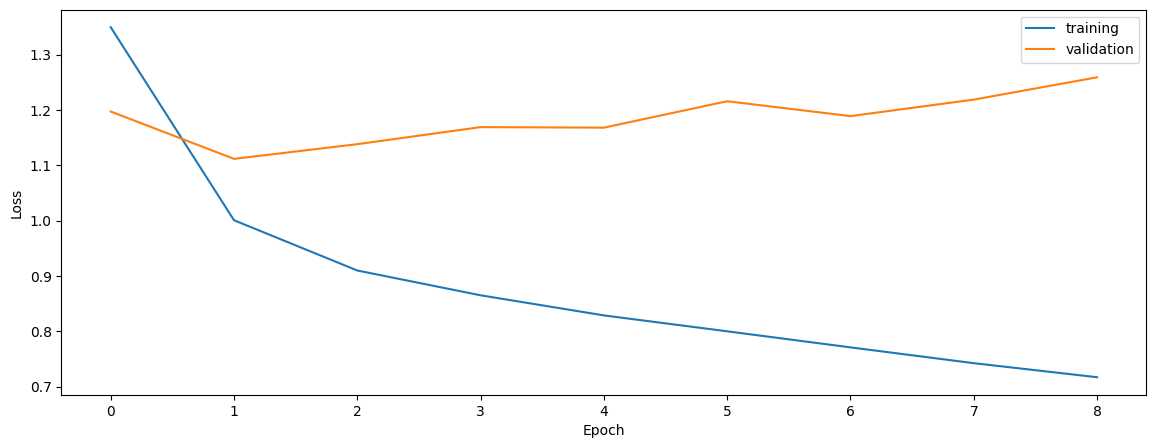

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6355081997966846
0.5916260358699584
0.5849552903517623


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5762658757319948
0.5586273666092944
0.5563675232319707


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5757086380196894
0.5538563098250633
0.5616827743035816


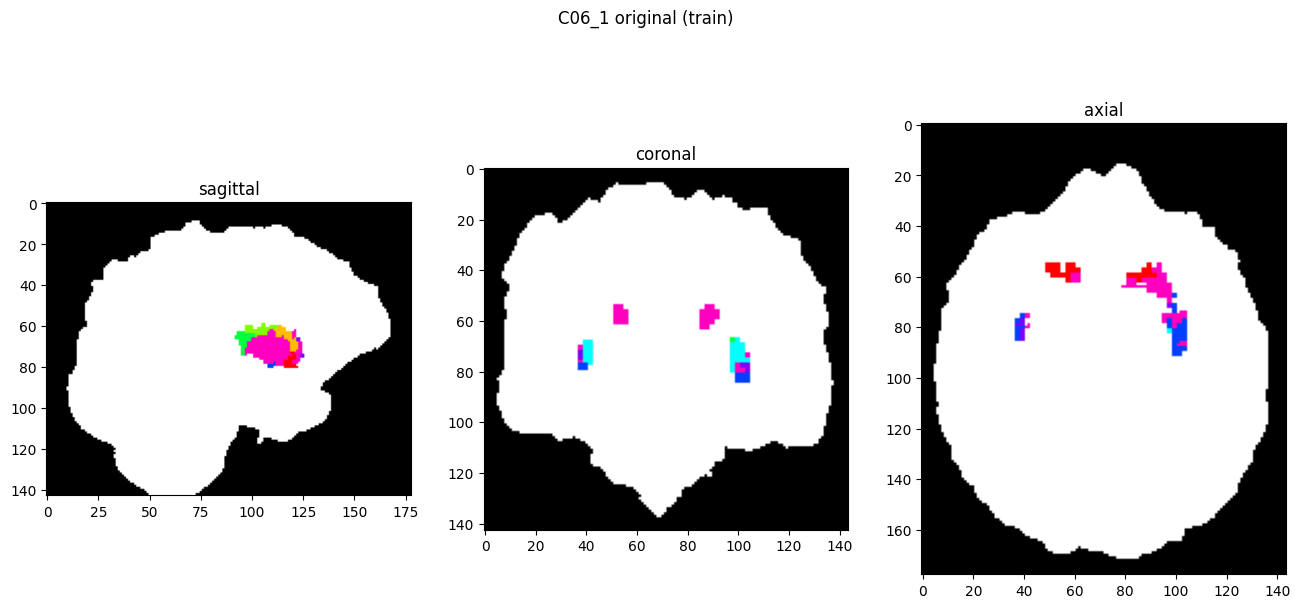

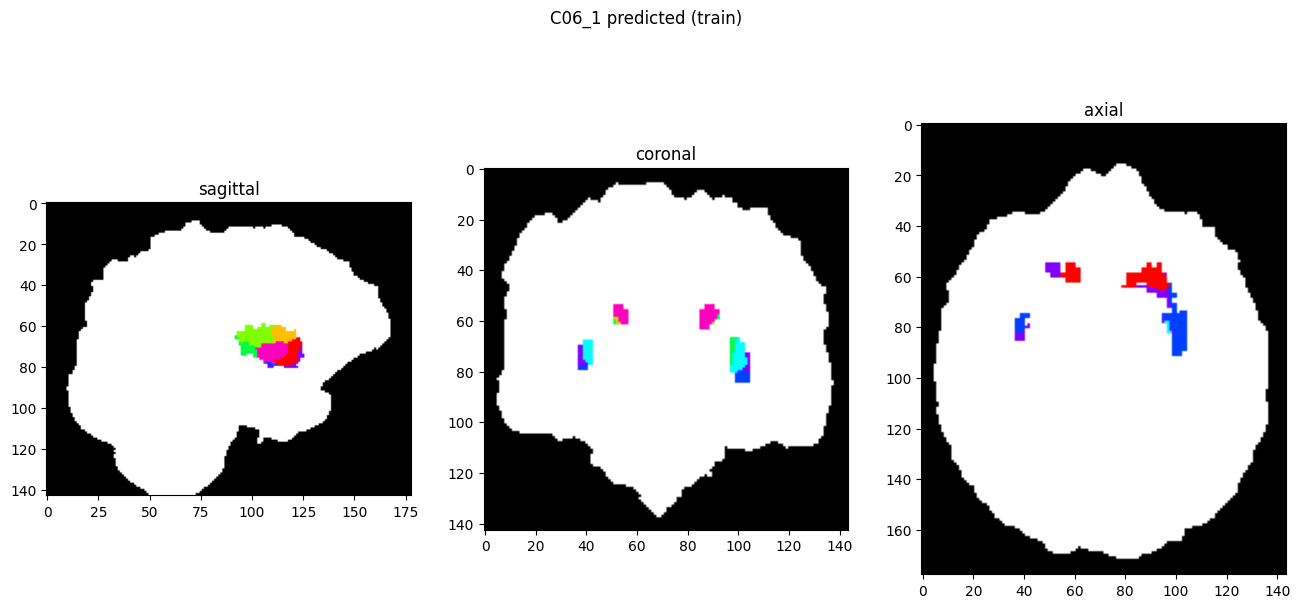

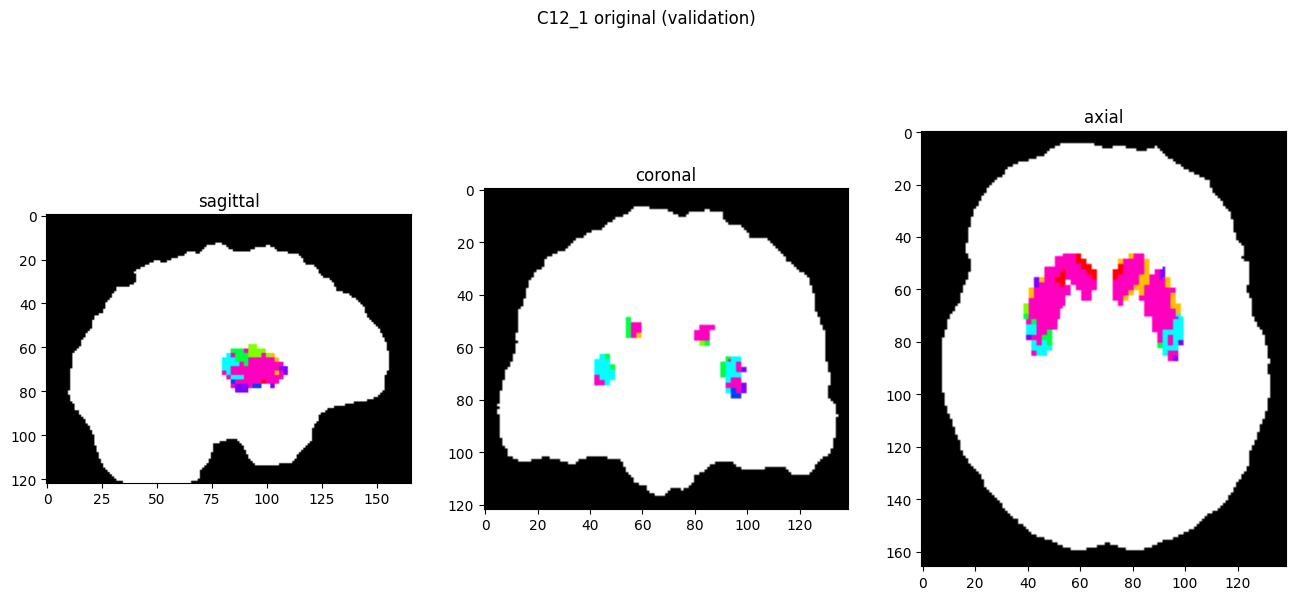

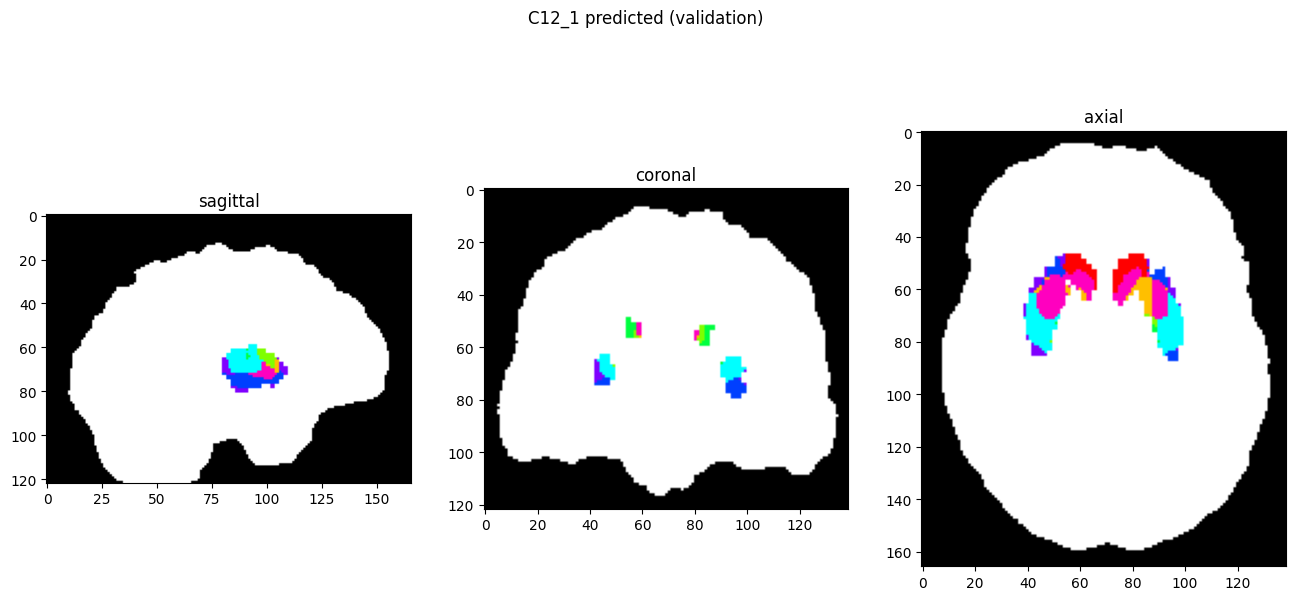

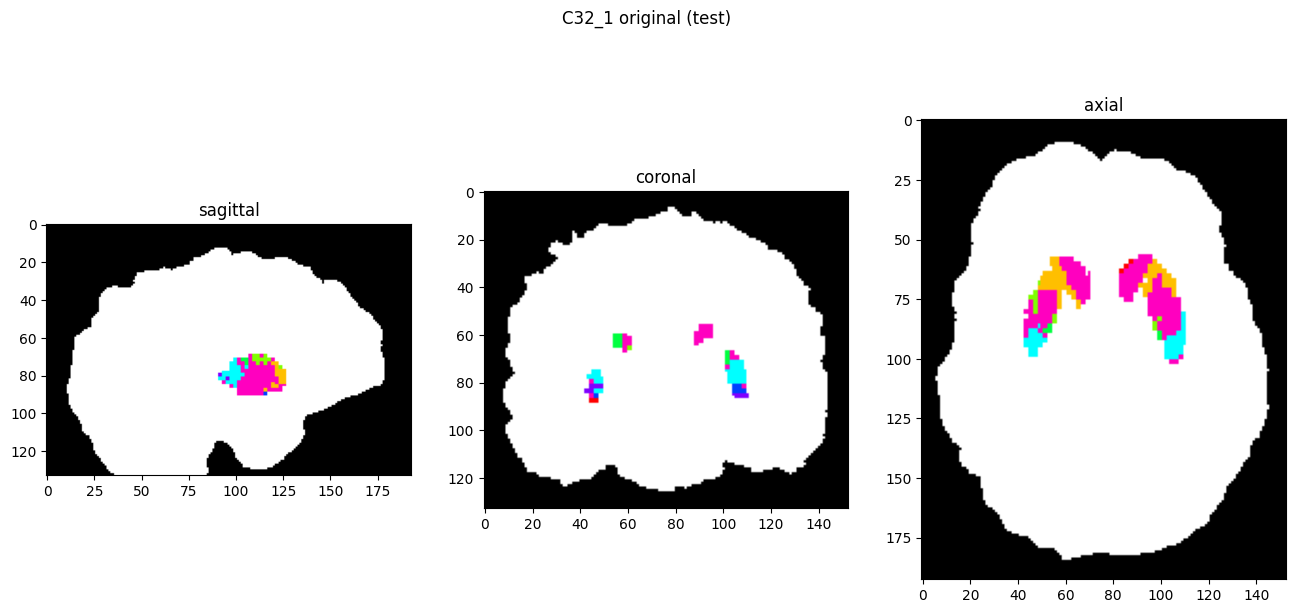

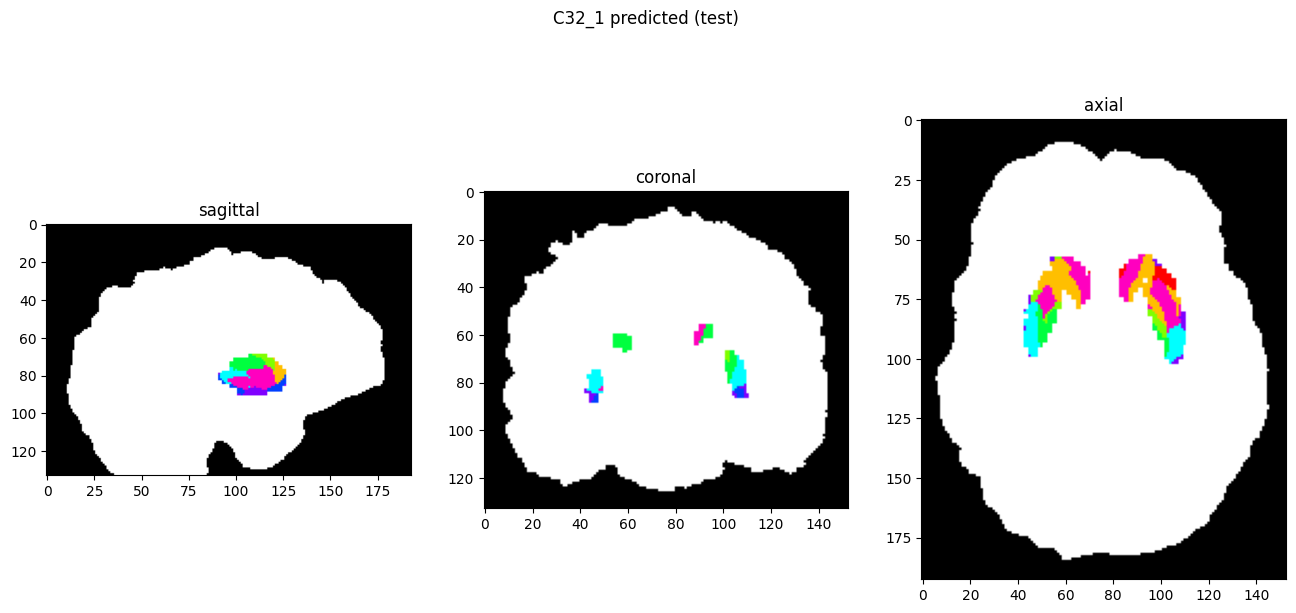

In [10]:
showResults(model, gen, threshold=0)